# Credit Risk

Credit Risk is the possibility of a loss resulting from a borrower's failure to repay a
loan or meet a contractual obligation. The primary goal of a credit risk assessment is to find out whether potential borrowers are creditworthy and have the means to repay their debts so that credit risk or loss can be minimized and the loan is granted to only creditworthy applicants.

If the borrower shows an acceptable level of default risk, then their loan application can be approved upon agreed terms. 

This project involves understanding financial terminologies attached to credit risk and building a classification model for default prediction with Pycaret. Hyperparameter Optimization is done using also the Pycaret library.

# Libraries

In [1]:
#%pip install shap==0.40.0
#%pip install hyperopt==0.2.7

In [2]:
import pandas as pd
import inflection
import missingno as msno
import seaborn as sns
import numpy as np
import re

import scipy.stats as stats
from scipy import stats as ss
from scipy.stats import chi2_contingency
from matplotlib import pyplot as plt
from IPython.display import Image
from utils import *

import ipywidgets as widgets
from ipywidgets import interact
import plotly.express as px

from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, CDSView, IndexFilter
from bokeh.layouts import row, column
from scipy.stats import gaussian_kde
from bokeh.models import RangeSlider

from sklearn import preprocessing as pp
from imblearn import under_sampling as us
from imblearn import over_sampling as oversamp
from pandas_profiling import ProfileReport
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection as ms
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

from sklearn.cluster import KMeans
import matplotlib.gridspec as gridspec
from sklearn.cluster import DBSCAN

import random
from sklearn import metrics as m
from sklearn.metrics import classification_report, cohen_kappa_score, roc_curve, brier_score_loss
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, recall_score, f1_score, roc_auc_score, precision_score, roc_curve
#from sklearn.metrics import plot_precision_recall_curve

from scikitplot import metrics as mt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RandomizedSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, RandomForestClassifier
from sklearn import svm
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA
import category_encoders

from datetime import datetime, timedelta
import pickle

# Loadind Data

In [3]:
pwd

'/Users/lucasquemelli/Documents/repos/credit_default_risk_prediction'

In [4]:
data = pd.read_csv("/Users/lucasquemelli/Documents/repos/credit_default_risk_prediction/credit_risk_data.csv")
data.head()

Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.


,User_id,employment_type,tier_of_employment,industry,role,work_experience,total_income,gender,married,dependents,...,interest_received,number_of_loans,emi_1_dpd,emi_2_dpd,emi_3_dpd,emi_4_dpd,emi_5_dpd,emi_6_dpd,max_dpd,yearmo
0,7013527,Salaried,B,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGAZSEWdkcndwkcnCCM,1-2,125000.000,Female,Yes,4,...,852.690,0,0,90,90,90,90,90,90,202203
1,7014291,Self - Employeed,D,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGNCSEWdkcndwkcnCCM,10+,61000.000,Female,No,1,...,4912.530,0,0,0,0,0,0,0,0,202203
2,7014327,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGNYSEWdkcndwkcnCCM,5-10,100000.000,Other,NaN,3,...,3310.680,0,90,90,90,90,90,90,90,202205
3,7014304,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,2-3,30000.000,Male,NaN,1,...,1459.760,0,0,0,0,0,0,0,0,202203
4,7031995,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,10+,65000.000,Male,NaN,3,...,1793.000,0,0,0,0,0,0,0,0,202203


In [5]:
cols_old = data.columns

snake_case = lambda x: inflection.underscore(x)

cols_new = list(map(snake_case, cols_old))

data.columns = cols_new

In [6]:
data.columns

Index(['user_id', 'employment_type', 'tier_of_employment', 'industry', 'role',
       'work_experience', 'total_income', 'gender', 'married', 'dependents',
       'home_type', 'pincode', 'has_social_profile', 'is_verified',
       'delinq_2yrs', 'total_payement', 'received_principal',
       'interest_received', 'number_of_loans', 'emi_1_dpd', 'emi_2_dpd',
       'emi_3_dpd', 'emi_4_dpd', 'emi_5_dpd', 'emi_6_dpd', 'max_dpd',
       'yearmo'],
      dtype='object')

# Duplication Test

Since this analysis should be at user level, would it be affordable to have more rows than userids? 

In [7]:
data["user_id"].nunique()

133752

In [8]:
data.shape[0]

143727

Notice below that some users appears more than once. Some of them appears 16 times. Let's check it out. 

In [9]:
data["user_id"].value_counts()

3166625     16
2803481     16
2789468     16
3440082     16
3062454     16
            ..
2814679      1
2819122      1
2818821      1
2819179      1
56122051     1
Name: user_id, Length: 133752, dtype: int64

In [10]:
data[data["user_id"] == 3166625]

,user_id,employment_type,tier_of_employment,industry,role,work_experience,total_income,gender,married,dependents,...,interest_received,number_of_loans,emi_1_dpd,emi_2_dpd,emi_3_dpd,emi_4_dpd,emi_5_dpd,emi_6_dpd,max_dpd,yearmo
36527,3166625,Salaried,C,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGHISEWdkcndwkcnCCM,10+,45000.000,Female,Yes,3,...,3355.560,0,90,90,90,90,90,90,90,202201
36528,3166625,Salaried,C,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGHISEWdkcndwkcnCCM,10+,45000.000,Female,Yes,3,...,550.890,0,0,0,0,0,0,0,0,202203
36529,3166625,Salaried,C,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGHISEWdkcndwkcnCCM,10+,45000.000,Female,Yes,2,...,3355.560,0,90,90,90,90,90,90,90,202203
36530,3166625,Salaried,C,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGHISEWdkcndwkcnCCM,10+,45000.000,Female,Yes,2,...,550.890,0,0,0,0,0,0,0,0,202203
36531,3166625,Salaried,D,0,KHMbckjadbckIFGMDSEWdkcndwkcnCCM,0,115000.000,Female,Yes,3,...,3355.560,0,90,90,90,90,90,90,90,202205
36532,3166625,Salaried,D,0,KHMbckjadbckIFGMDSEWdkcndwkcnCCM,0,115000.000,Female,Yes,3,...,550.890,0,0,0,0,0,0,0,0,202205
36533,3166625,Salaried,D,0,KHMbckjadbckIFGMDSEWdkcndwkcnCCM,0,115000.000,Female,Yes,2,...,3355.560,0,90,90,90,90,90,90,90,202202
36534,3166625,Salaried,D,0,KHMbckjadbckIFGMDSEWdkcndwkcnCCM,0,115000.000,Female,Yes,2,...,550.890,0,0,0,0,0,0,0,0,202205
36535,3166625,Salaried,C,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGHISEWdkcndwkcnCCM,10+,45000.000,Female,Yes,3,...,3355.560,0,0,90,90,90,90,90,90,202201
36536,3166625,Salaried,C,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGHISEWdkcndwkcnCCM,10+,45000.000,Female,Yes,3,...,550.890,0,0,0,0,0,0,0,0,202205


In [11]:
data.iloc[:, 0:15]

,user_id,employment_type,tier_of_employment,industry,role,work_experience,total_income,gender,married,dependents,home_type,pincode,has_social_profile,is_verified,delinq_2yrs
0,7013527,Salaried,B,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGAZSEWdkcndwkcnCCM,1-2,125000.000,Female,Yes,4,rent,XX852X,No,NaN,0
1,7014291,Self - Employeed,D,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGNCSEWdkcndwkcnCCM,10+,61000.000,Female,No,1,mortgage,XX286X,NaN,Source Verified,0
2,7014327,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGNYSEWdkcndwkcnCCM,5-10,100000.000,Other,NaN,3,own,XX113X,No,NaN,0
3,7014304,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,2-3,30000.000,Male,NaN,1,rent,XX941X,Yes,NaN,0
4,7031995,NaN,NaN,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGCASEWdkcndwkcnCCM,10+,65000.000,Male,NaN,3,rent,XX913X,No,Verified,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143722,55993166,NaN,NaN,0,KHMbckjadbckIFGTNSEWdkcndwkcnCCM,0,100000.000,Female,No,2,mortgage,XX374X,NaN,Source Verified,1
143723,56263229,NaN,NaN,0,KHMbckjadbckIFGOHSEWdkcndwkcnCCM,0,27000.000,Male,Yes,3,rent,XX436X,No,Source Verified,0
143724,55992716,NaN,NaN,0,KHMbckjadbckIFGCASEWdkcndwkcnCCM,0,53000.000,Female,Yes,2,rent,XX908X,NaN,NaN,0
143725,56363313,NaN,NaN,0,KHMbckjadbckIFGVASEWdkcndwkcnCCM,0,75400.000,Other,No,0,mortgage,XX229X,NaN,Source Verified,0


In [12]:
data.iloc[:, 15:30]

,total_payement,received_principal,interest_received,number_of_loans,emi_1_dpd,emi_2_dpd,emi_3_dpd,emi_4_dpd,emi_5_dpd,emi_6_dpd,max_dpd,yearmo
0,1824.150,971.460,852.690,0,0,90,90,90,90,90,90,202203
1,22912.533,18000.000,4912.530,0,0,0,0,0,0,0,0,202203
2,7800.440,4489.760,3310.680,0,90,90,90,90,90,90,90,202205
3,6672.050,5212.290,1459.760,0,0,0,0,0,0,0,0,202203
4,11793.001,10000.000,1793.000,0,0,0,0,0,0,0,0,202203
...,...,...,...,...,...,...,...,...,...,...,...,...
143722,12842.400,7193.830,5648.570,0,0,0,0,30,0,0,30,202205
143723,839.200,581.670,257.530,0,0,0,0,0,0,0,0,202203
143724,6085.800,2434.490,3651.310,0,0,0,0,0,0,0,0,202204
143725,4080.640,3286.820,793.820,0,0,0,0,0,0,30,30,202202


# Deduplication

Let's consider for deduplication:

1. The most recent updated date in our dataset for every user.
2. The smallest total income. 

In [13]:
# sort the dataframe by 'yearmo' in descending order
data.sort_values(by=['yearmo', 'total_income'], ascending=[False, True], inplace=True)

# drop duplicates based on 'user_id' while keeping the first occurence (maximum 'yearmo')
data = data.drop_duplicates(subset='user_id', keep='first')

# reset the index of the new dataframe
data.reset_index(drop=True, inplace=True)

In [14]:
data["user_id"].nunique()

133752

In [15]:
data.shape[0]

133752

In [16]:
data[data["user_id"] == 3166625]

,user_id,employment_type,tier_of_employment,industry,role,work_experience,total_income,gender,married,dependents,...,interest_received,number_of_loans,emi_1_dpd,emi_2_dpd,emi_3_dpd,emi_4_dpd,emi_5_dpd,emi_6_dpd,max_dpd,yearmo
6922,3166625,Salaried,C,mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtU...,KHMbckjadbckIFGHISEWdkcndwkcnCCM,10+,45000.000,Female,Yes,3,...,550.890,0,0,0,0,0,0,0,0,202205


# Helper Functions

In [17]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y).values
    n = confusion_matrix.sum()
    r,k = confusion_matrix.shape
   
    chi2 = chi2_contingency(confusion_matrix)[0]
    phi2 = chi2/n
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
   
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

# 1. Data Description

- For EMI: DPD equals to 0 is the number of days between 0 and 29. 
- 

In [18]:
df1 = data.copy()


| Columns            | Description                                           |
|--------------------|-------------------------------------------------------|
| User_id            | User Identifier                                       |
| employment_type    | Employment Type (Salaried, Self-Employed)             |
| tier_of_employment | Tier of Employment (According to company performance) |
| industry           | Industry of Employer                                  |
| role               | Role of User in company                               |
| work_experience    | Total Work Experience                                 |
| total_income       | Total Income of customer                              |
| gender             | Gender of Customer                                    |
| married            | Single / Married / Divorced / Widowed etc.            |
| dependents         | No. of dependents on user                             |
| home_type          | Rented / Owned etc.                                   |
| pincode            | Middle 3 digit of Pincode                             |
| has_social_profile | Has FB/Twitter or any other social profile            |
| is_verified        | Is Social Profile Verified                            |
| delinq_2yrs        | Number of loan delinquencies in last 2 years          |
| total_payement     | Total Payment made towards loan in last 2 years       |
| received_principal | Total Principal paid towards loan in last 2 years     |
| interest_received  | Total Interest Received towards loan in last 2 years  |
| number_of_loans    | Number of Loans in last 2 years                       |
| emi_1_dpd          | DPD in repayment of 1st EMI (0, 30+, 60+, 90+)        |
| emi_2_dpd          | DPD in repayment of 2nd EMI (0, 30+, 60+, 90+)        |
| emi_3_dpd          | DPD in repayment of 3rd EMI (0, 30+, 60+, 90+)        |
| emi_4_dpd          | DPD in repayment of 4th EMI (0, 30+, 60+, 90+)        |
| emi_5_dpd          | DPD in repayment of 5th EMI (0, 30+, 60+, 90+)        |
| emi_6_dpd          | DPD in repayment of 6th EMI (0, 30+, 60+, 90+)        |
| max_dpd            | Maximum DPD (0, 30+, 60+, 90+) attained               |
| yearmo             | Year and month of loan application (YYYYMM format)    |



## Action Items

- According to yearmo, split data in Train, Validation, Hold Out.
- DPD Roll Rate Analysis and Window Roll Rate Analysis for defining label (default = dpd X in first Y months, Define X & Y)

## 1.1. Data Dimensions

In [19]:
print("Number of rows: {}".format(df1.shape[0]))
print("Number of cols: {}".format(df1.shape[1]))

Number of rows: 133752
Number of cols: 27


## 1.2. Data Types

In [20]:
df1.dtypes

user_id                 int64
employment_type        object
tier_of_employment     object
industry               object
role                   object
work_experience        object
total_income          float64
gender                 object
married                object
dependents              int64
home_type              object
pincode                object
has_social_profile     object
is_verified            object
delinq_2yrs             int64
total_payement        float64
received_principal    float64
interest_received     float64
number_of_loans         int64
emi_1_dpd               int64
emi_2_dpd               int64
emi_3_dpd               int64
emi_4_dpd               int64
emi_5_dpd               int64
emi_6_dpd               int64
max_dpd                 int64
yearmo                  int64
dtype: object

## 1.3. Data Conversion

In [21]:
df1['yearmo'] = df1['yearmo'].astype(str)  # Garante que 'yearmo' seja uma string
df1['yearmo'] = df1['yearmo'].apply(lambda x: f"{x[:4]}-{x[4:]}")
df1['yearmo'] = pd.to_datetime(df1['yearmo'], format='%Y-%m')

In [22]:
df1.dtypes

user_id                        int64
employment_type               object
tier_of_employment            object
industry                      object
role                          object
work_experience               object
total_income                 float64
gender                        object
married                       object
dependents                     int64
home_type                     object
pincode                       object
has_social_profile            object
is_verified                   object
delinq_2yrs                    int64
total_payement               float64
received_principal           float64
interest_received            float64
number_of_loans                int64
emi_1_dpd                      int64
emi_2_dpd                      int64
emi_3_dpd                      int64
emi_4_dpd                      int64
emi_5_dpd                      int64
emi_6_dpd                      int64
max_dpd                        int64
yearmo                datetime64[ns]
d

## 1.4. Na Check

In [23]:
df1.isna().sum()

user_id                   0
employment_type       79334
tier_of_employment    79334
industry                  4
role                      0
work_experience           4
total_income              0
gender                    0
married               44856
dependents                0
home_type                 0
pincode                   0
has_social_profile    44627
is_verified           33358
delinq_2yrs               0
total_payement            0
received_principal        0
interest_received         0
number_of_loans           0
emi_1_dpd                 0
emi_2_dpd                 0
emi_3_dpd                 0
emi_4_dpd                 0
emi_5_dpd                 0
emi_6_dpd                 0
max_dpd                   0
yearmo                    0
dtype: int64

In [24]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df1.isna().sum()/len(df1)

user_id              0.00
employment_type      0.59
tier_of_employment   0.59
industry             0.00
role                 0.00
work_experience      0.00
total_income         0.00
gender               0.00
married              0.34
dependents           0.00
home_type            0.00
pincode              0.00
has_social_profile   0.33
is_verified          0.25
delinq_2yrs          0.00
total_payement       0.00
received_principal   0.00
interest_received    0.00
number_of_loans      0.00
emi_1_dpd            0.00
emi_2_dpd            0.00
emi_3_dpd            0.00
emi_4_dpd            0.00
emi_5_dpd            0.00
emi_6_dpd            0.00
max_dpd              0.00
yearmo               0.00
dtype: float64

In [25]:
df1.dtypes

user_id                        int64
employment_type               object
tier_of_employment            object
industry                      object
role                          object
work_experience               object
total_income                 float64
gender                        object
married                       object
dependents                     int64
home_type                     object
pincode                       object
has_social_profile            object
is_verified                   object
delinq_2yrs                    int64
total_payement               float64
received_principal           float64
interest_received            float64
number_of_loans                int64
emi_1_dpd                      int64
emi_2_dpd                      int64
emi_3_dpd                      int64
emi_4_dpd                      int64
emi_5_dpd                      int64
emi_6_dpd                      int64
max_dpd                        int64
yearmo                datetime64[ns]
d

In [26]:
df1["employment_type"] = df1["employment_type"].fillna("SI")

df1["tier_of_employment"] = df1["tier_of_employment"].fillna("SI")

df1["industry"] = df1["industry"].fillna("SI")

df1["work_experience"] = df1["work_experience"].fillna("SI")

df1["married"] = df1["married"].fillna("SI")

df1["has_social_profile"] = df1["has_social_profile"].fillna("SI")

df1["is_verified"] = df1["is_verified"].fillna("SI")

In [27]:
df1.isna().sum()

user_id               0
employment_type       0
tier_of_employment    0
industry              0
role                  0
work_experience       0
total_income          0
gender                0
married               0
dependents            0
home_type             0
pincode               0
has_social_profile    0
is_verified           0
delinq_2yrs           0
total_payement        0
received_principal    0
interest_received     0
number_of_loans       0
emi_1_dpd             0
emi_2_dpd             0
emi_3_dpd             0
emi_4_dpd             0
emi_5_dpd             0
emi_6_dpd             0
max_dpd               0
yearmo                0
dtype: int64

## 1.6. Descriptive Statistics

In [28]:
num_attributes = df1.drop(columns=["user_id"]).select_dtypes(include=['int32', 'int64', 'float32', 'float64'])
cat_attributes = df1.select_dtypes(include=['object', 'category'])

### 1.6.1. Numerical Attributes

In [29]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Central Tendency - Mean, Mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,total_income,4000.000,7141778.000,7137778.000,72538.108,62000.000,56122.189,28.837,2791.391
1,dependents,0.000,4.000,4.000,2.002,2.000,1.414,-0.005,-1.300
2,delinq_2yrs,0.000,22.000,22.000,0.284,0.000,0.800,5.421,52.951
3,total_payement,0.000,57777.580,57777.580,10686.194,8046.045,8541.111,1.603,2.748
4,received_principal,0.000,35000.010,35000.010,8273.808,5860.050,7183.243,1.559,2.327
5,interest_received,0.000,24205.620,24205.620,2334.677,1626.310,2416.865,2.848,11.644
6,number_of_loans,0.000,5.000,5.000,0.006,0.000,0.099,22.902,635.940
7,emi_1_dpd,0.000,90.000,90.000,7.700,0.000,23.763,3.023,7.501
8,emi_2_dpd,0.000,90.000,90.000,8.301,0.000,24.595,2.842,6.405
9,emi_3_dpd,0.000,90.000,90.000,8.325,0.000,24.744,2.866,6.519


- The maximum value of DPD is 90 days.
- It seems the majority of users have lower total income, since we found a high standard deviation and positive skew.
- There is no variable with zero variance, but number of loans have standard deviation equals to 0.099. It is almost zero. It may suggest this variable may not be representative - no information to the model.

Let's look at the continuous features in order to perform an analysis. 

#### Total income

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


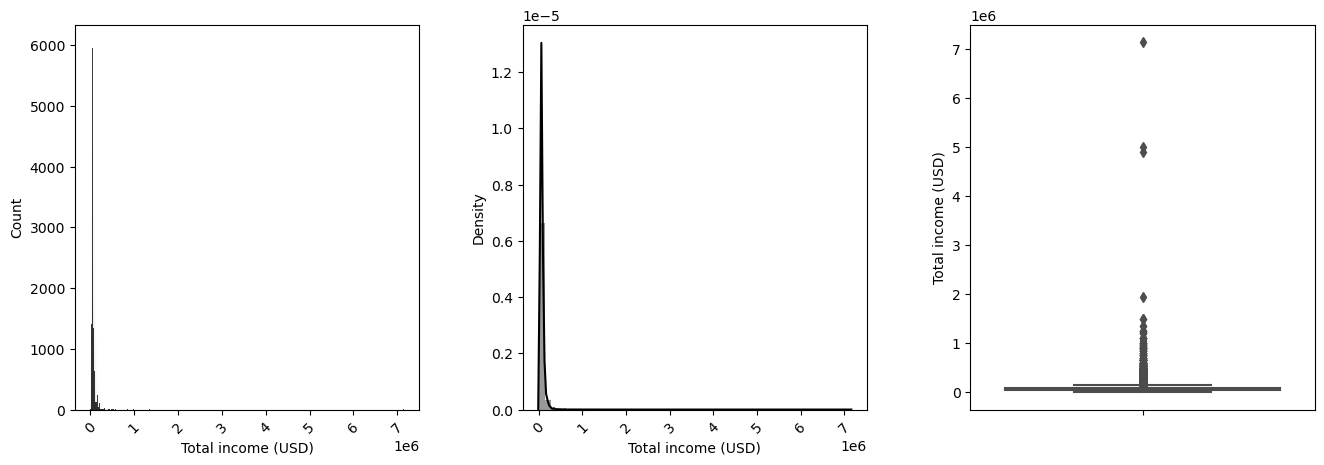

In [30]:
aux = num_attributes.copy()

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["total_income"], color="black")
plt.xlabel("Total income (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["total_income"], color="black")
plt.xlabel("Total income (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='total_income',data=aux, color="gray")
plt.ylabel("Total income (USD)")

plt.subplots_adjust(wspace = 0.30);

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


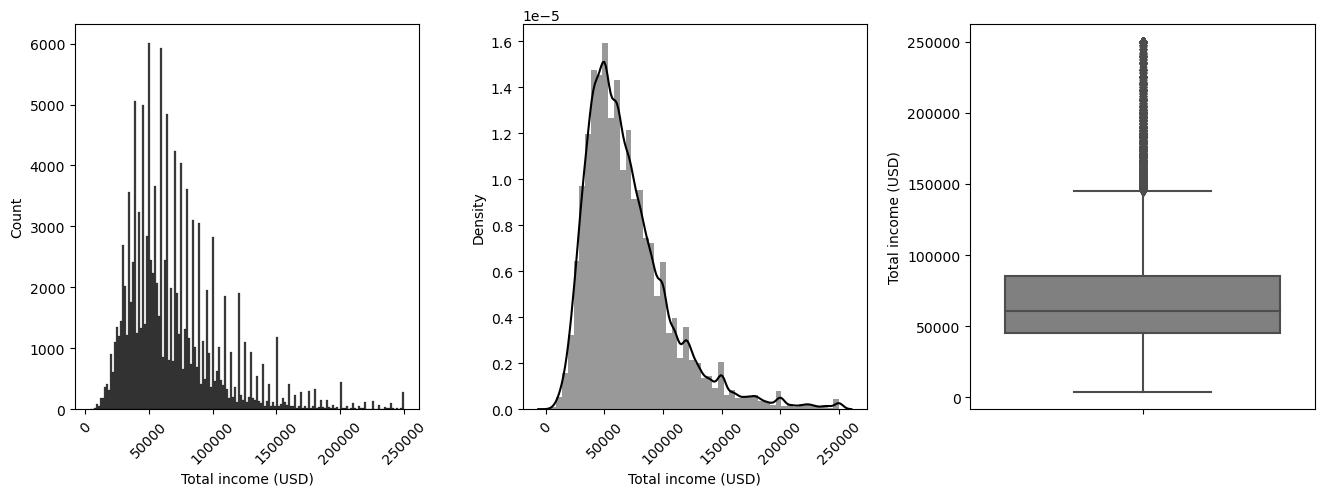

In [31]:
aux = num_attributes.copy()
aux = aux[aux["total_income"] <= 250000]

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["total_income"], color="black")
plt.xlabel("Total income (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["total_income"], color="black")
plt.xlabel("Total income (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='total_income',data=aux, color="gray")
plt.ylabel("Total income (USD)")

plt.subplots_adjust(wspace = 0.30);

In [32]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(aux["total_income"]).describe().T

,count,mean,std,min,25%,50%,75%,max
total_income,132675.00,69857.66,36860.45,4000.00,45000.00,61000.00,85000.00,250000.00


- Since we have high value for skew and a high value for kurtosis, we may assume there are outliers for total income.
- Therefore, median is more representative than mean.
- Median is around 61000 USD. 
- A value lower than 250000 USD should be used as upper limit to remove outliers.

#### Total payment

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


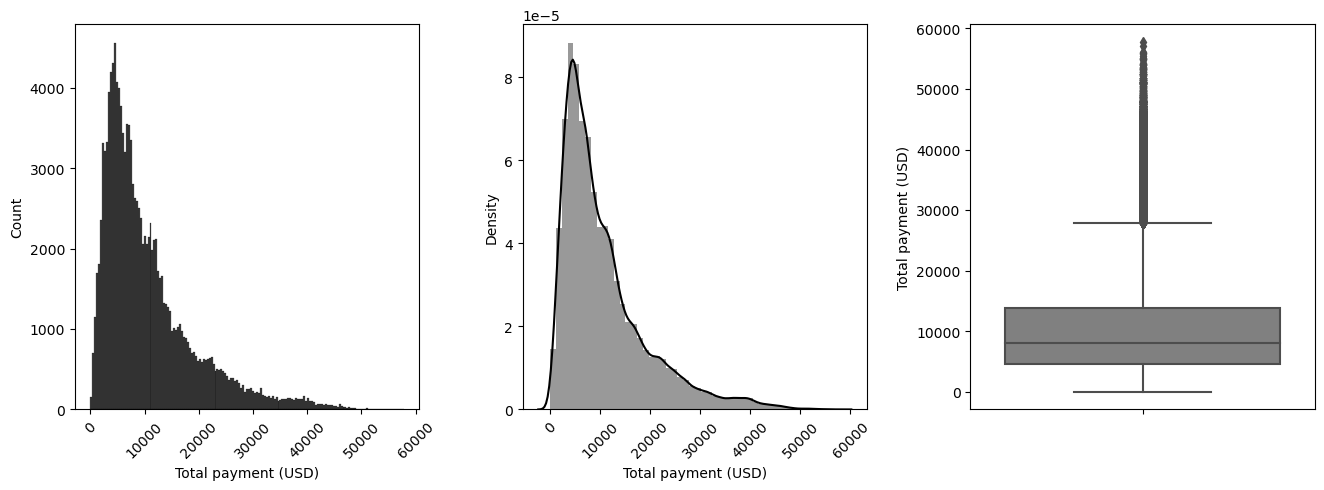

In [33]:
aux = num_attributes.copy()

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["total_payement"], color="black")
plt.xlabel("Total payment (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["total_payement"], color="black")
plt.xlabel("Total payment (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='total_payement',data=aux, color="gray")
plt.ylabel("Total payment (USD)")

plt.subplots_adjust(wspace = 0.30);

In [34]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(aux["total_payement"]).describe().T

,count,mean,std,min,25%,50%,75%,max
total_payement,133752.00,10686.19,8541.14,0.00,4620.92,8046.05,13921.03,57777.58


- We can see some outliers in the distribution chart.
- We may assume median is proper than mean.
- Median is around 8000 USD.

#### Received principal

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


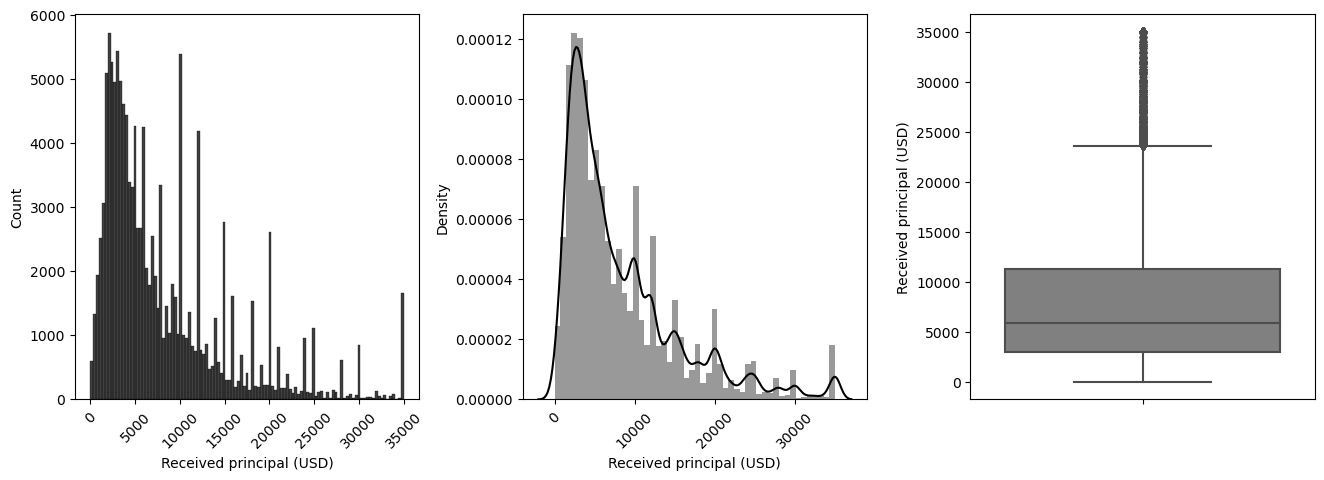

In [35]:
aux = num_attributes.copy()

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["received_principal"], color="black")
plt.xlabel("Received principal (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["received_principal"], color="black")
plt.xlabel("Received principal (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='received_principal',data=aux, color="gray")
plt.ylabel("Received principal (USD)")

plt.subplots_adjust(wspace = 0.30);

In [36]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(aux["received_principal"]).describe().T

,count,mean,std,min,25%,50%,75%,max
received_principal,133752.00,8273.81,7183.27,0.00,3044.25,5860.05,11285.53,35000.01


- We may see some outliers.
- Median is proper.
- Median is around 5800 USD.

#### Interest received

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


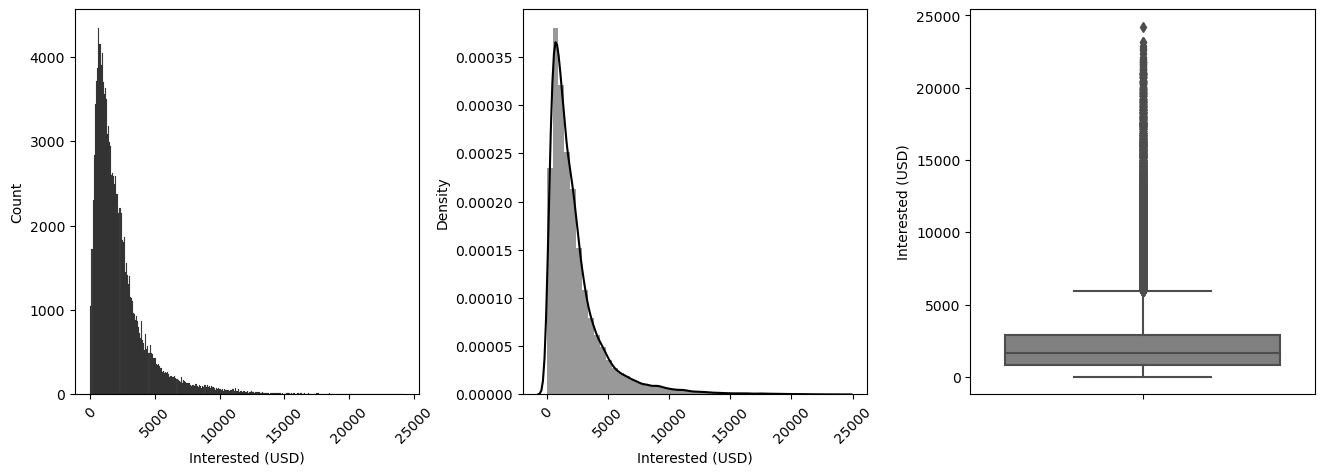

In [37]:
aux = num_attributes.copy()

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["interest_received"], color="black")
plt.xlabel("Interested (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["interest_received"], color="black")
plt.xlabel("Interested (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='interest_received',data=aux, color="gray")
plt.ylabel("Interested (USD)")

plt.subplots_adjust(wspace = 0.30);

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


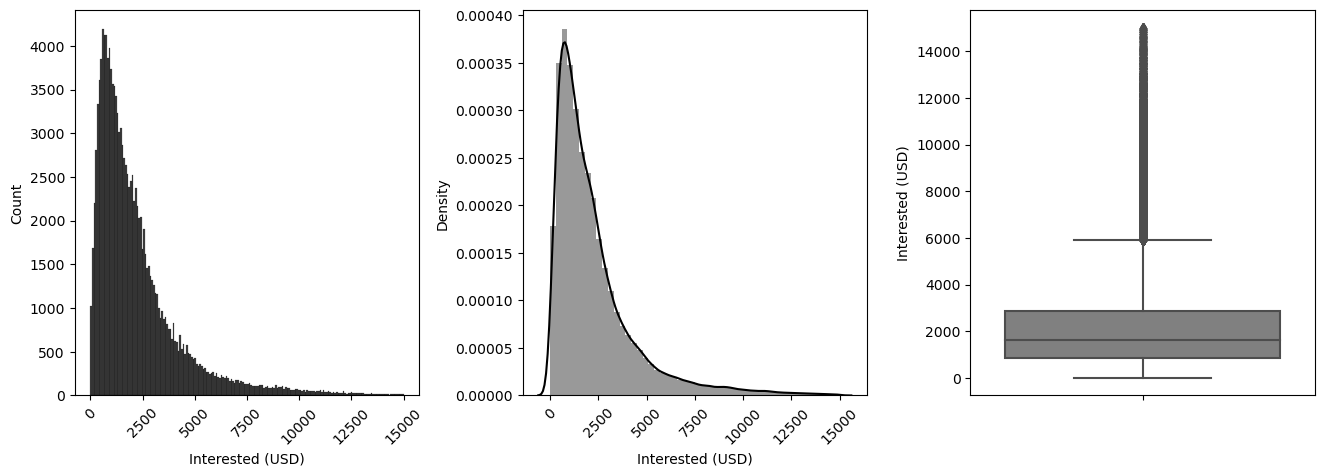

In [38]:
aux = num_attributes.copy()
aux = aux[aux["interest_received"] < 15000]

plt.figure(figsize=(16,5))

plt.subplot(1,3,1)
sns.histplot(aux["interest_received"], color="black")
plt.xlabel("Interested (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,2)
sns.distplot(aux["interest_received"], color="black")
plt.xlabel("Interested (USD)")
plt.xticks(rotation=45);

plt.subplot(1,3,3)
sns.boxplot(y='interest_received',data=aux, color="gray")
plt.ylabel("Interested (USD)")

plt.subplots_adjust(wspace = 0.30);

In [39]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(aux["interest_received"]).describe().T

,count,mean,std,min,25%,50%,75%,max
interest_received,133089.00,2258.06,2160.46,0.00,835.54,1614.72,2860.08,14999.14


- Median around 1600 USD.
- Outliers above 15000.

### 1.6.2. Correlation Matrix

We use it in order to evaluate variables which are highly correlated. The objective is to exclude one of them. 

#### Pearson Correlation Coefficient

Pearson's correlation coefficient is used for linear correlation between variables.

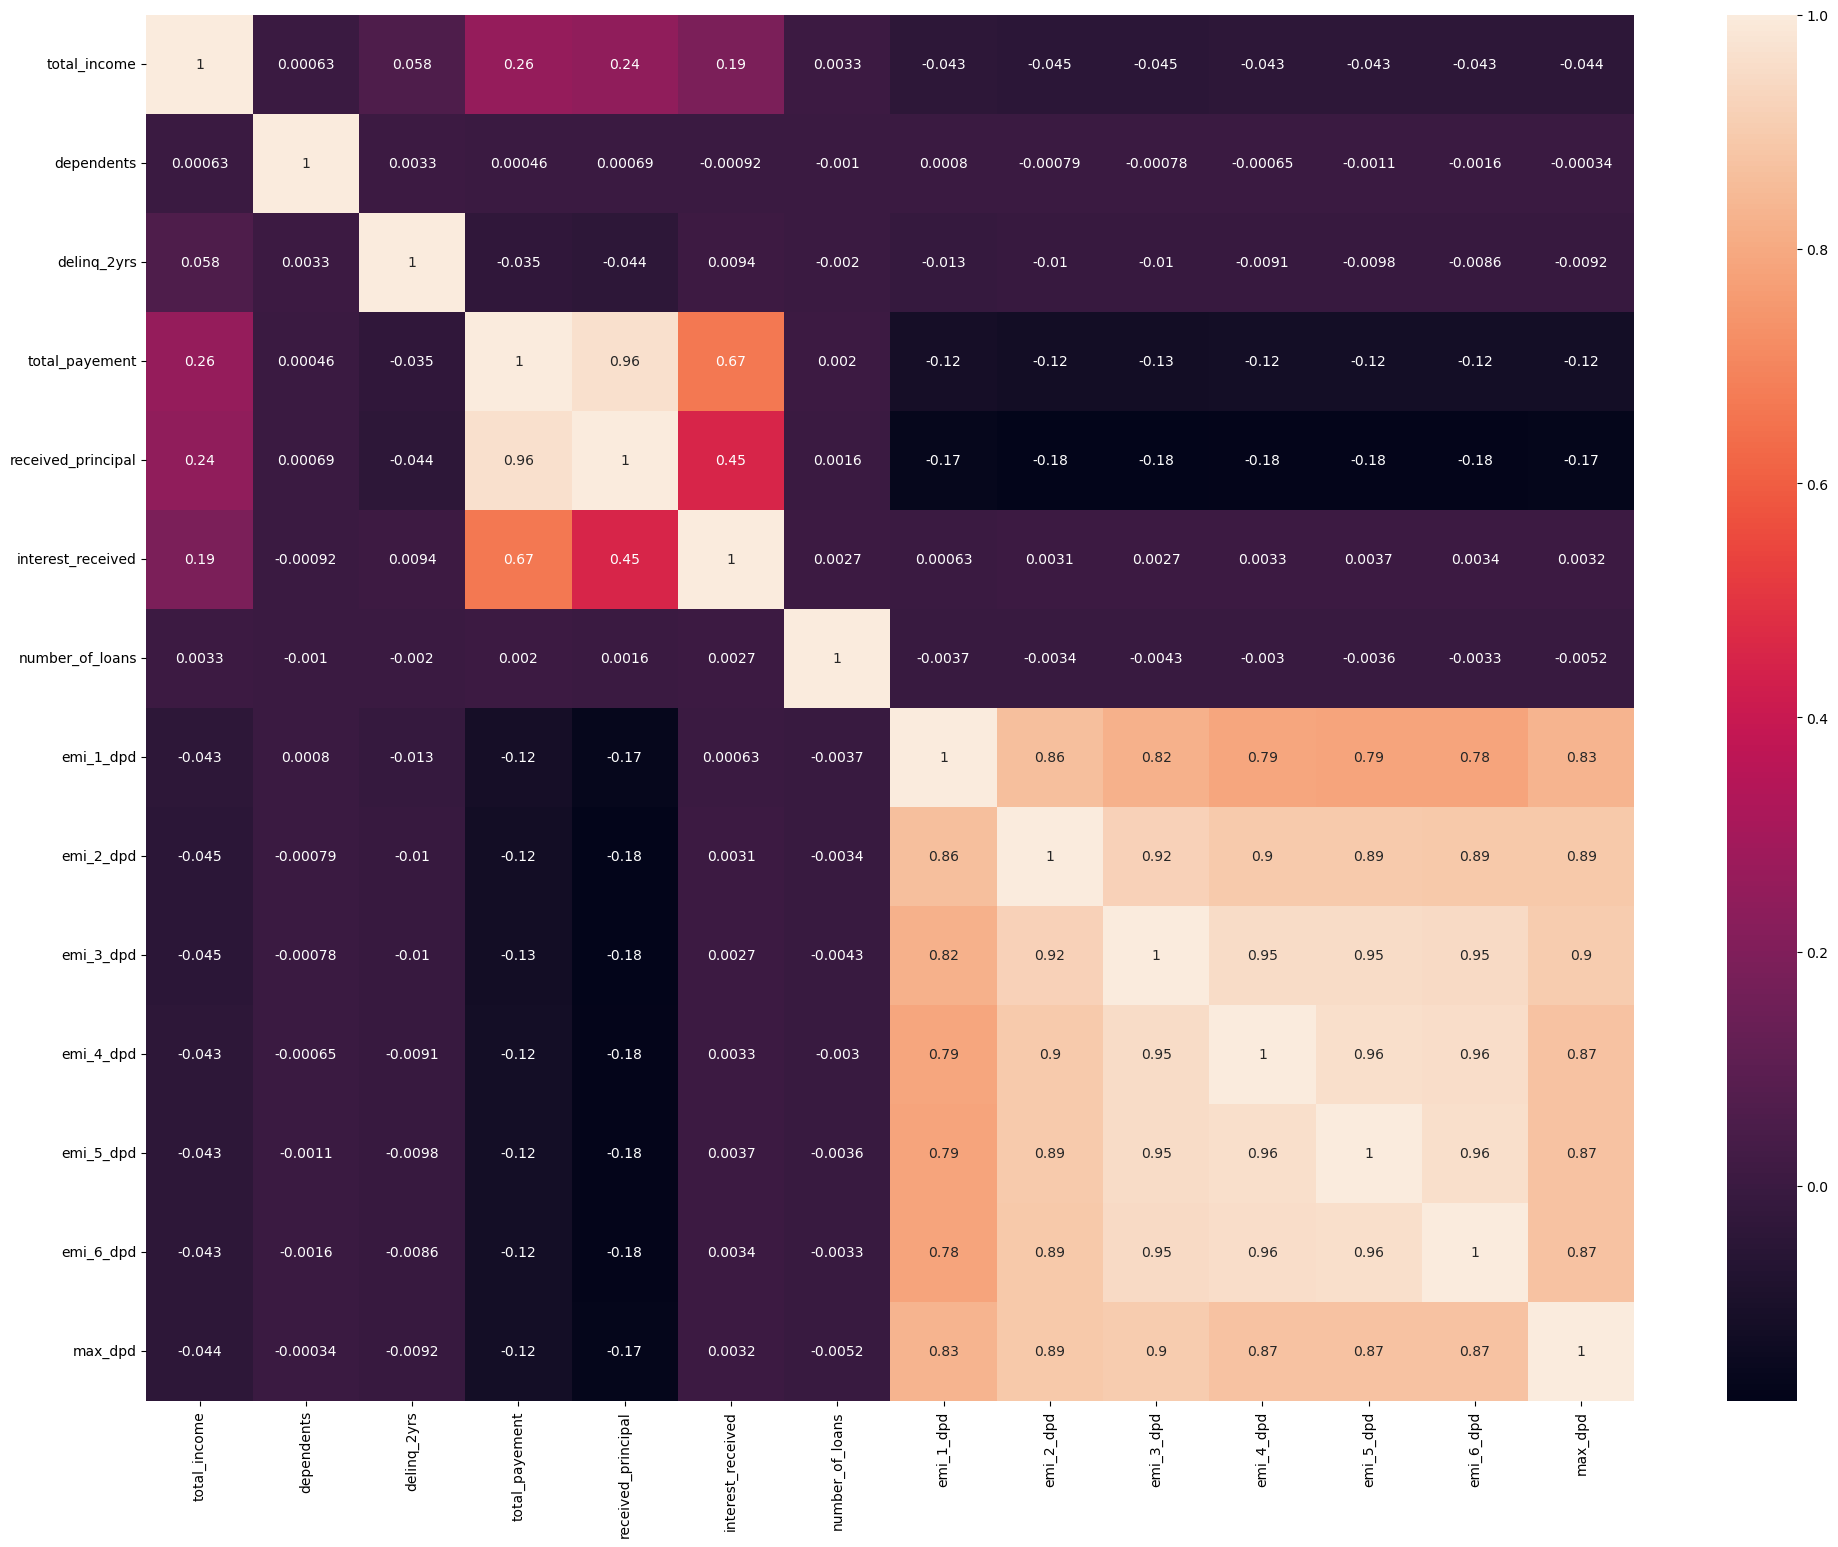

In [40]:
plt.figure(figsize = (24,18))

sns.heatmap(num_attributes.corr(method="pearson"), annot=True);

- received_principal and total_payment.
- interest_received and total_payment.
- All DPD variables.

#### Spearman Correlation Coefficient

Spearman's correlation coefficient is used to measure the monotonic correlation between variables. It is appropriate to use Spearman's correlation coefficient for nonlinear relationships.

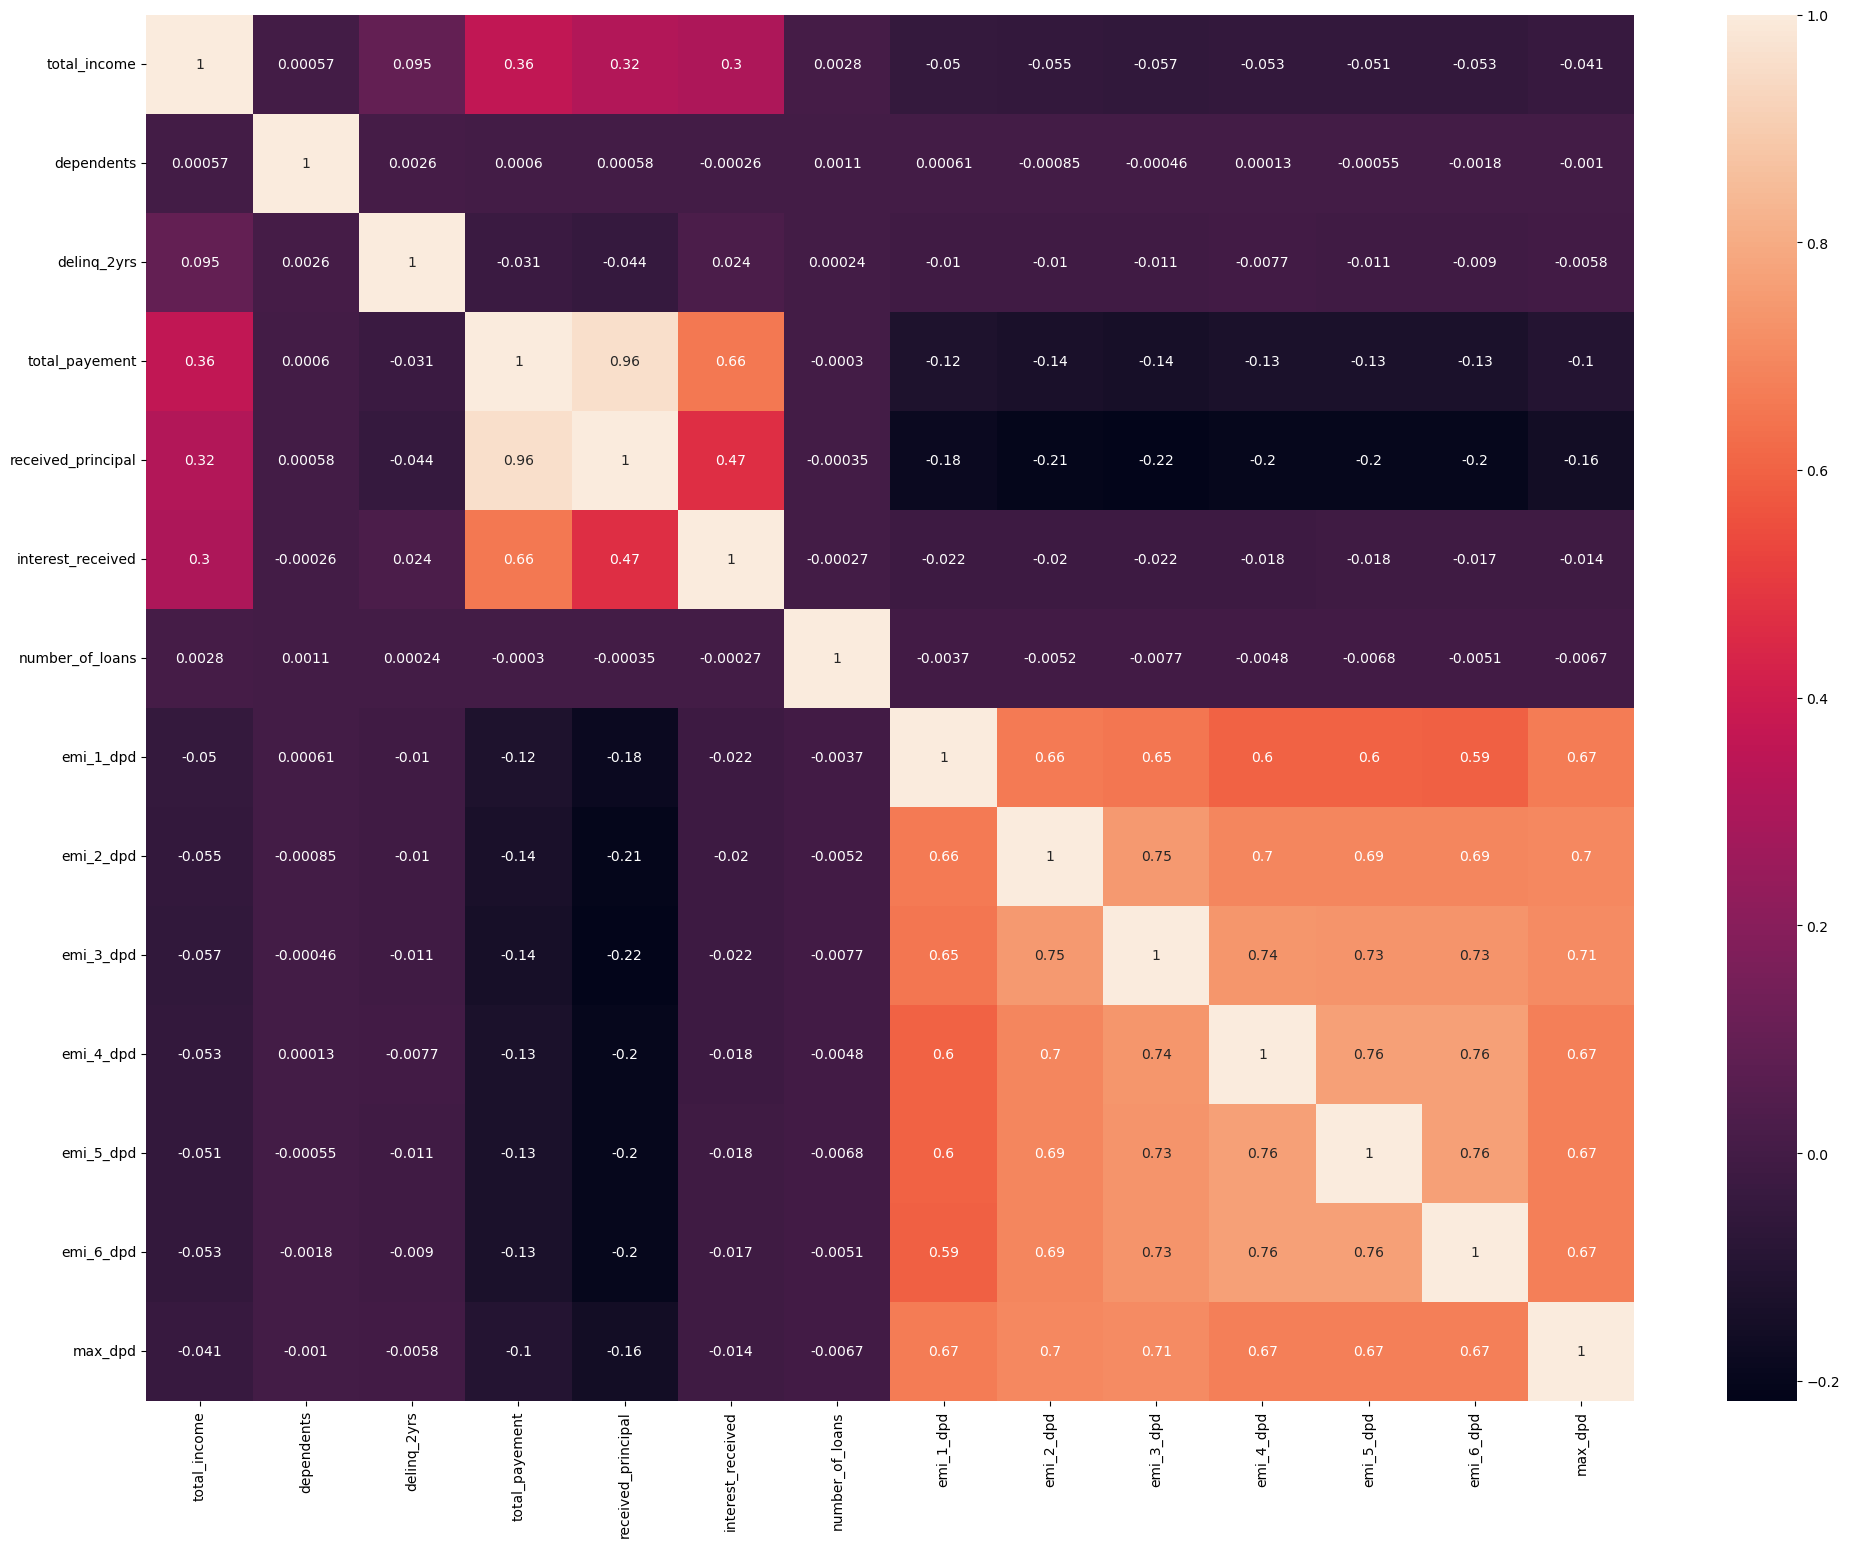

In [41]:
plt.figure(figsize = (24,18))

sns.heatmap(num_attributes.corr(method="spearman"), annot=True);

- received_principal and total_payment.
- interest_received and total_payment.
- All DPD variables.

#### Kendall Correlation Coefficient

Kendall's correlation coefficient, also known as Kendall's tau, is used to measure the strength and direction of the ordinal association between variables. It is appropriate to be used for ordinal and classified data, as well as for non-linear relationships between variables.

overflow encountered in long_scalars


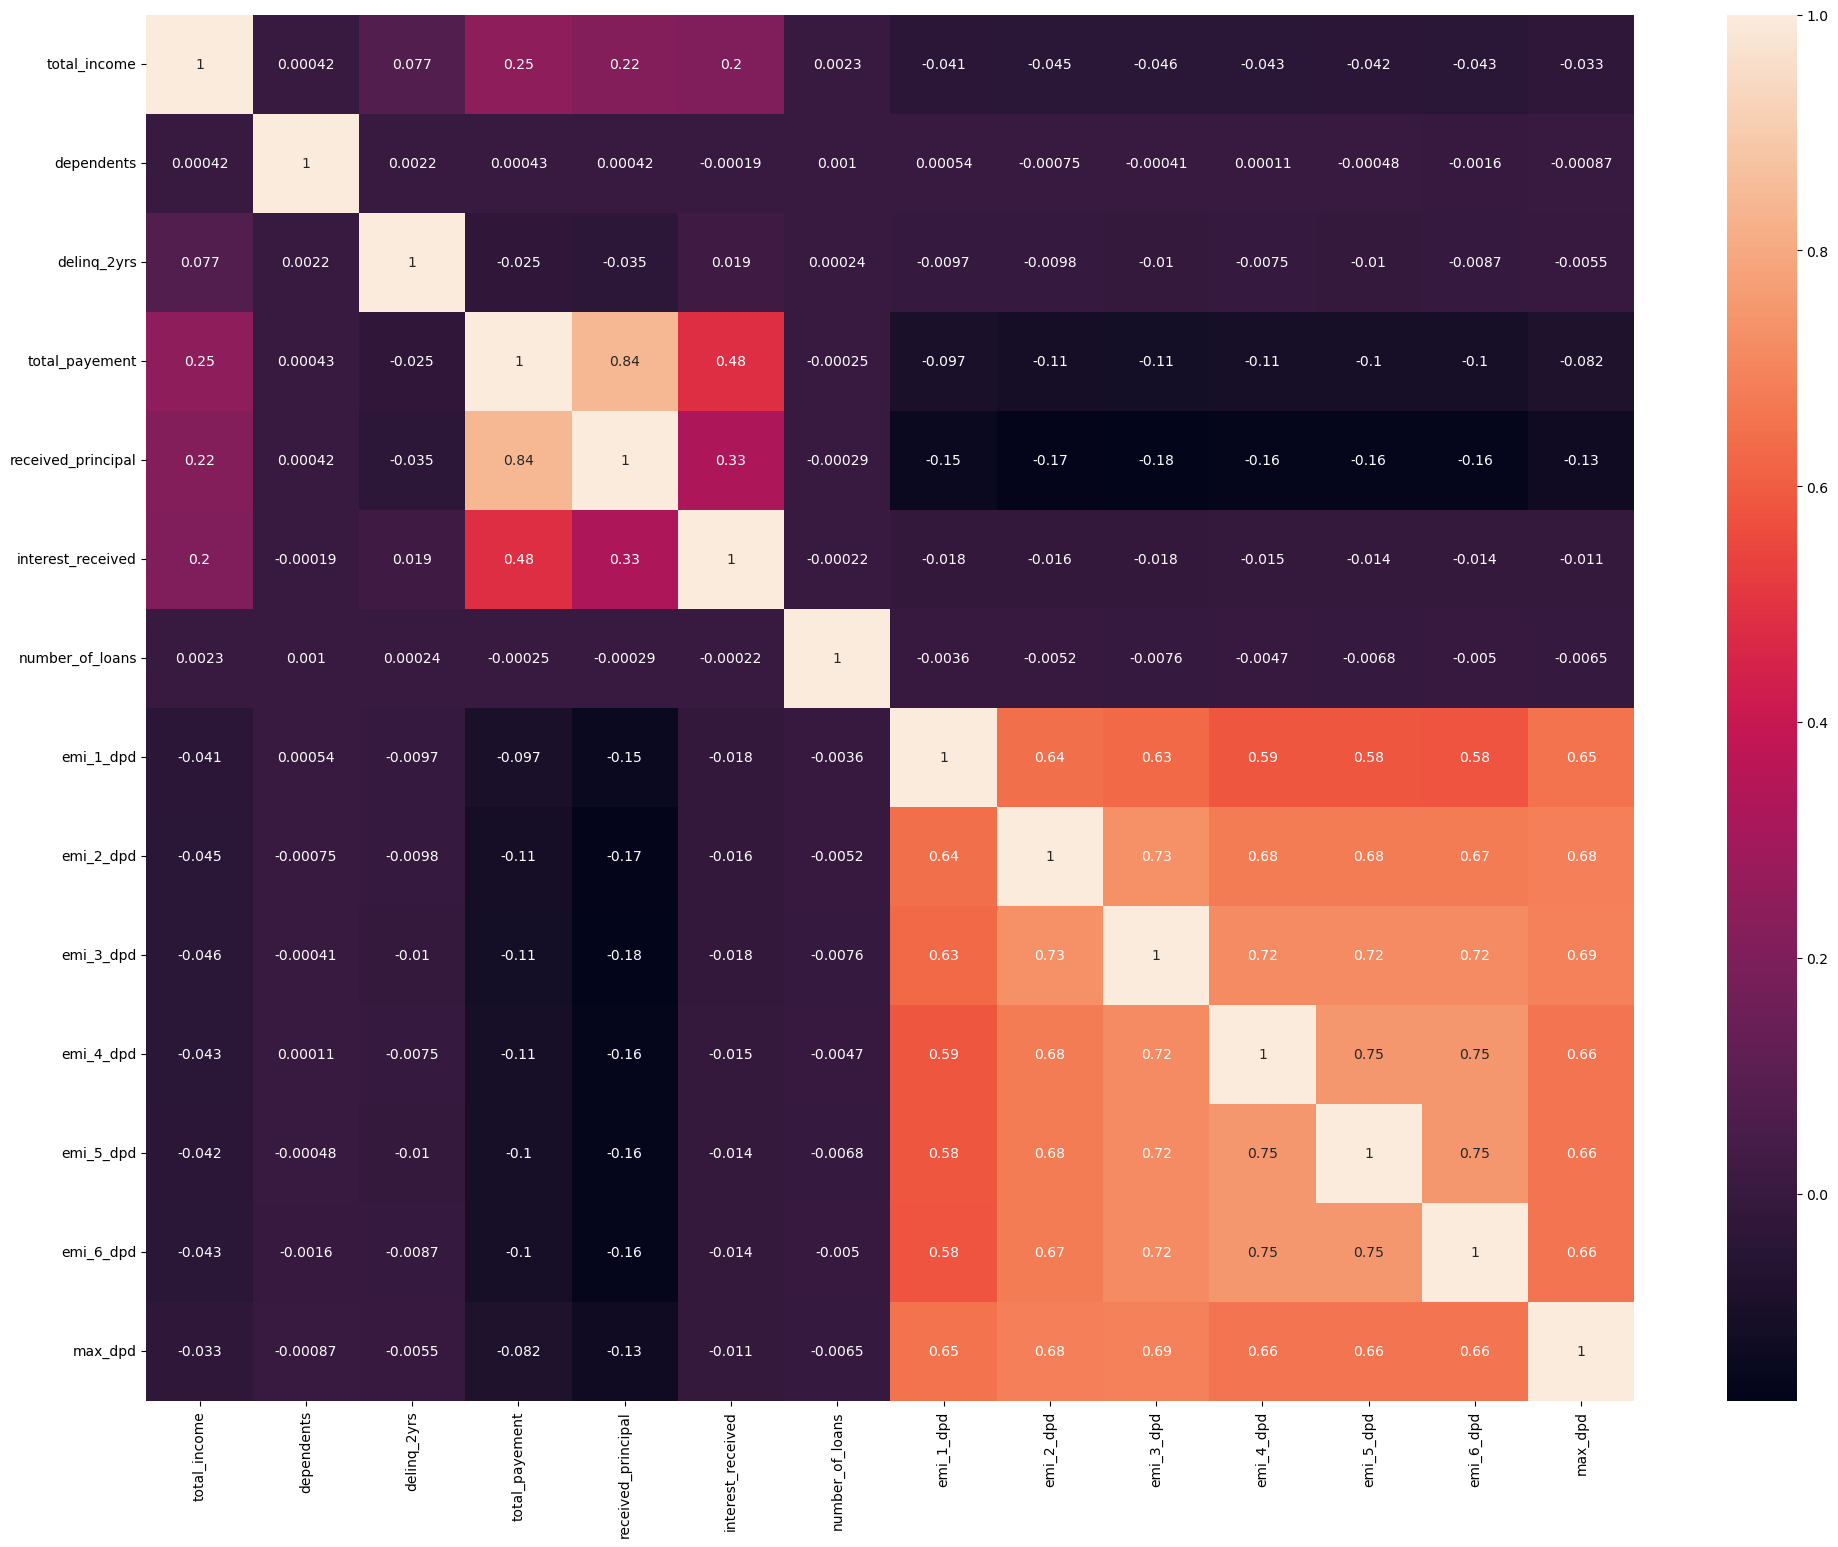

In [42]:
plt.figure(figsize = (24,18))

sns.heatmap(num_attributes.corr(method="kendall"), annot=True);

- received_principal and total_payment.
- All DPD variables

### 1.6.3. Categorical Attributes

In [43]:
cat_attributes.apply(lambda x: x.unique().shape[0])

employment_type           3
tier_of_employment        8
industry              12913
role                     46
work_experience           9
gender                    3
married                   3
home_type                 5
pincode                 844
has_social_profile        3
is_verified               4
dtype: int64

- We will apply target encoder to the variables: **industry**, **role** and **pincode**. These variables has multiple categories.

In [44]:
cat_attributes["employment_type"].unique()

array(['Salaried', 'SI', 'Self - Employeed'], dtype=object)

In [45]:
cat_attributes["tier_of_employment"].unique()

array(['E', 'SI', 'A', 'D', 'C', 'B', 'F', 'G'], dtype=object)

In [46]:
cat_attributes["industry"].unique()

array([0, '0',
       'mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhmLVIVxoGY7TUDJ1FyFoSIYbLnjDpXuW1BK+S9BD7Tw0=',
       ...,
       'mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhnWcLMy6BtCds+1rJfyJxydPB2ANrrLwMhyOzzBXjy1Q=',
       'mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIh1Rk8w4Ucd5yR3KcqZzLdo9gjqKV0vjoJJDvdM9yKd0Q=',
       'mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEiGYtUhXGgZjtNQMnUXIWhIhhNsmDUtVx53lV8hFMrnPuttF3p2+esKYFxjR1R2PMpw='],
      dtype=object)

- Since the feature above is the industry of the employer, we must evaluate if it is really necessary to be used in the model.
- In the Feature Selection section we will apply feature importance to evaluate which variable we will use in the model. 

In [47]:
cat_attributes["role"].unique()

array(['KHMbckjadbckIFGNYSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGNHSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGCASEWdkcndwkcnCCM',
       'KHMbckjadbckIFGUTSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGPASEWdkcndwkcnCCM',
       'KHMbckjadbckIFGVASEWdkcndwkcnCCM',
       'KHMbckjadbckIFGNMSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGCOSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGTXSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGARSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGNCSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGMNSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGLASEWdkcndwkcnCCM',
       'KHMbckjadbckIFGTNSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGKYSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGILSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGMSSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGMISEWdkcndwkcnCCM',
       'KHMbckjadbckIFGWASEWdkcndwkcnCCM',
       'KHMbckjadbckIFGHISEWdkcndwkcnCCM',
       'KHMbckjadbckIFGORSEWdkcndwkcnCCM',
       'KHMbckjadbckIFGWISEWdkcndwkcnCCM',
       'KHMbckjadbckIFGFLSEWdkcndwkcnCCM',
       'KHM

- I suppose we will not use this field, since it is and identification field.

In [48]:
cat_attributes["work_experience"].unique()

array([0, '0', '5-10', '<1', '1-2', '3-5', '10+', '2-3', 'SI'],
      dtype=object)

- Maybe we should apply some numeric transformation to the lebels.

In [49]:
cat_attributes["gender"].unique()

array(['Other', 'Female', 'Male'], dtype=object)

In [50]:
cat_attributes["married"].unique()

array(['SI', 'No', 'Yes'], dtype=object)

In [51]:
cat_attributes["home_type"].unique()

array(['rent', 'own', 'mortgage', 'none', 'other'], dtype=object)

In [52]:
cat_attributes["pincode"].unique()

array(['XX117X', 'XX30X', 'XX917X', 'XX325X', 'XX116X', 'XX185X',
       'XX223X', 'XX884X', 'XX805X', 'XX762X', 'XX724X', 'XX191X',
       'XX941X', 'XX286X', 'XX554X', 'XX551X', 'XX377X', 'XX104X',
       'XX928X', 'XX242X', 'XX411X', 'XX600X', 'XX122X', 'XX913X',
       'XX173X', 'XX207X', 'XX386X', 'XX926X', 'XX782X', 'XX492X',
       'XX922X', 'XX992X', 'XX967X', 'XX107X', 'XX975X', 'XX532X',
       'XX972X', 'XX328X', 'XX482X', 'XX846X', 'XX780X', 'XX38X',
       'XX347X', 'XX722X', 'XX730X', 'XX208X', 'XX175X', 'XX425X',
       'XX315X', 'XX334X', 'XX852X', 'XX919X', 'XX241X', 'XX845X',
       'XX215X', 'XX775X', 'XX894X', 'XX760X', 'XX180X', 'XX294X',
       'XX980X', 'XX493X', 'XX633X', 'XX728X', 'XX275X', 'XX467X',
       'XX718X', 'XX765X', 'XX329X', 'XX306X', 'XX752X', 'XX446X',
       'XX100X', 'XX703X', 'XX900X', 'XX970X', 'XX209X', 'XX890X',
       'XX181X', 'XX206X', 'XX902X', 'XX144X', 'XX489X', 'XX495X',
       'XX940X', 'XX945X', 'XX982X', 'XX629X', 'XX137X', 'XX394X

- It seems pincode will not be chosen by the feature importance algorithm, since it is a kind of identification column.

In [53]:
cat_attributes["has_social_profile"].unique()

array(['SI', 'No', 'Yes'], dtype=object)

In [54]:
cat_attributes["is_verified"].unique()

array(['Not Verified', 'Verified', 'Source Verified', 'SI'], dtype=object)

### 1.6.4. Correlation Matrix

In [55]:
cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}
for i in range( len (cat_attributes_list)):
    corr_list = []
    for j in range(len( cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramers_v(cat_attributes[ref], cat_attributes[feat])
        
        # append a list
        corr_list.append(corr)
    
    # append a correlation list for each ref attribute
    corr_dict[ref] = corr_list

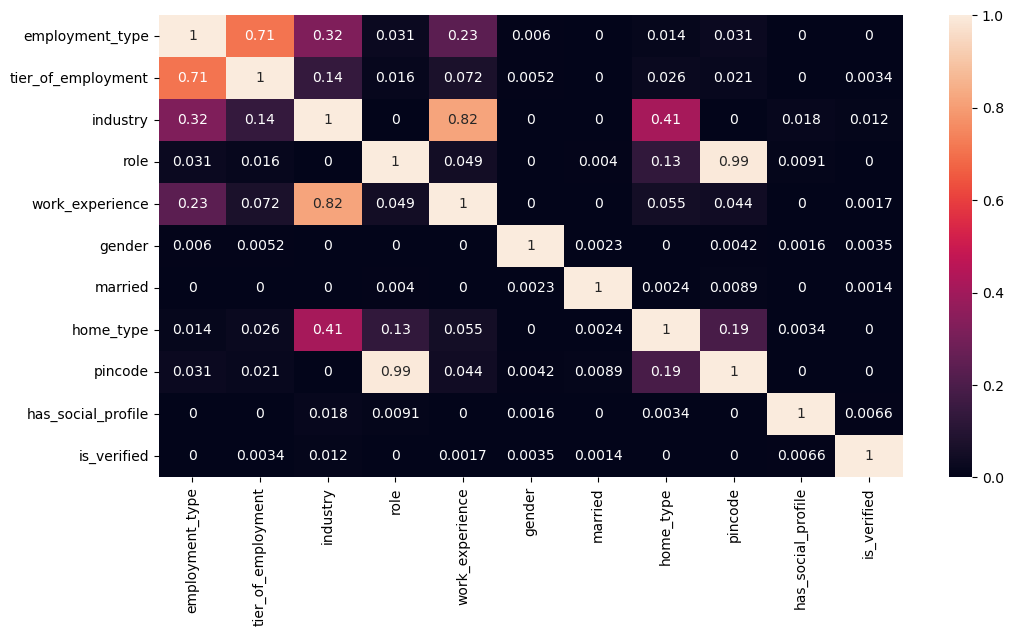

In [56]:
plt.figure(figsize =(12,6))

d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

- tier_of_employment and employment_type.
- work_experience and industry.
- pincode and role. 

### 1.6.5. Date Attributes

In [57]:
df1.dtypes

user_id                        int64
employment_type               object
tier_of_employment            object
industry                      object
role                          object
work_experience               object
total_income                 float64
gender                        object
married                       object
dependents                     int64
home_type                     object
pincode                       object
has_social_profile            object
is_verified                   object
delinq_2yrs                    int64
total_payement               float64
received_principal           float64
interest_received            float64
number_of_loans                int64
emi_1_dpd                      int64
emi_2_dpd                      int64
emi_3_dpd                      int64
emi_4_dpd                      int64
emi_5_dpd                      int64
emi_6_dpd                      int64
max_dpd                        int64
yearmo                datetime64[ns]
d

In [58]:
df1["yearmo"].unique()

array(['2022-05-01T00:00:00.000000000', '2022-04-01T00:00:00.000000000',
       '2022-03-01T00:00:00.000000000', '2022-02-01T00:00:00.000000000',
       '2022-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

- We only have the 2022 year.
- We only have months from January to May. 

#### Training, Test and Validation Dicussion

- We must select a period for training and test: January up to April.
- The month 5 we will use for validation (back test). 

# 2. Feature Engineering

In [59]:
df2 = df1.copy()

## 2.1. Target 

The **RIGHT QUESTION** must be done: what will we consider to classify a customer as a defaulter? 

The majority of defaulters cross DPD 60 in 3 months (after the third installment) as we saw in the sections 3.1 and 3.2. Thus, we are going to consider the customers which achieved this situation as defaulters. 

In [60]:
# We will call Class 1 a defaulter
df2 = create_label(df2, dpd = 60, months = 3)

Label/target column added to dataframe!


In [61]:
df2["target"].value_counts()

0    121687
1     12065
Name: target, dtype: int64

In [62]:
df2["target"].value_counts(normalize=True)

0   0.91
1   0.09
Name: target, dtype: float64

- 9% of our entire dataset is made of defaulters.

## 2.2. Features

- **interest_received_ratio**: customers with a high interest rate has high risk as well as a low interest rate has low risk.
- **total_payement_per_loan**: amount of total payment per loan. If the number of loans are higher, it is possible that the total payment is higher too. 
- **delinq_2yrs_ratio**: ratio of delinquencies per loan. 

In [63]:
df2['interest_received_ratio'] = (df2['interest_received']/df2['total_payement']).replace([np.inf, -np.inf], 0).fillna(0)
df2['total_payement_per_loan'] = (df2['total_payement']/df2['number_of_loans']).replace([np.inf, -np.inf], 0).fillna(0)
df2['delinq_2yrs_ratio'] = (df2['delinq_2yrs']/df2['number_of_loans']).replace([np.inf, -np.inf], 0).fillna(0)

df2['month_yearmo'] = df2['yearmo'].dt.month

In [64]:
df2.head()

,user_id,employment_type,tier_of_employment,industry,role,work_experience,total_income,gender,married,dependents,...,emi_4_dpd,emi_5_dpd,emi_6_dpd,max_dpd,yearmo,target,interest_received_ratio,total_payement_per_loan,delinq_2yrs_ratio,month_yearmo
0,72851048,Salaried,E,0,KHMbckjadbckIFGNYSEWdkcndwkcnCCM,0,4000.00,Other,SI,1,...,0,0,0,0,2022-05-01,0,0.38,0.00,0.00,5
1,2425104,SI,SI,0,KHMbckjadbckIFGNHSEWdkcndwkcnCCM,0,6695.00,Female,No,0,...,0,0,0,30,2022-05-01,0,0.08,0.00,0.00,5
2,2886381,Salaried,A,0,KHMbckjadbckIFGCASEWdkcndwkcnCCM,0,7000.00,Male,Yes,1,...,0,30,0,30,2022-05-01,0,0.12,0.00,0.00,5
3,2598860,SI,SI,0,KHMbckjadbckIFGUTSEWdkcndwkcnCCM,0,7800.00,Male,Yes,3,...,0,0,0,0,2022-05-01,0,0.27,0.00,0.00,5
4,57033271,Salaried,D,0,KHMbckjadbckIFGNYSEWdkcndwkcnCCM,0,7956.00,Male,SI,1,...,0,0,0,0,2022-05-01,0,0.34,0.00,0.00,5


# 3. Exploratory Data Analysis (EDA)

This section is designed to gain business knowledge for decision making. It is a section for analytical data exploration and for hypothesys tests. 

In [65]:
df3 = df2.copy()

## 3.1. DPD Roll Rate

Firstly, let's understand the percentage of people through different DPDs (with DPD zero as basis). This rate calculates the number and percentage of people who achieved different DPDs. 

In [66]:
# % of customer achieved X dpd (Since everyone starts at 0 dpd so 100% will be at 0 dpd)
dpd_roll_rate(df3)

,dpd,user_count,user_percent
0,0,133752,100.0 %
1,30,33972,25.4 %
2,60,12139,9.08 %
3,90,11881,8.88 %


- (100 - 25.4)% customer paid back after crossing DPD 30.
- We may see that after DPD 60, the rate almost does not vary. It means DPD 60 is our cutoff (label).

## 3.2. Window Roll Rate

Then, let's understand how many people which crossed DPD 60 (cutoff above) in many EMI lifecyles. In other words, this is the percentage of people which crossed DPD 60 (60 days without pay back) for each installment.  

In [67]:
# For DPD 60 analyzing % of customer attain dpd60 on various lifecycle of EMI
window_roll_rate(df3, 60)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,first_default_emi,users_count,% of Users
0,1,9767,80.46 %
1,2,1664,13.71 %
2,3,634,5.22 %
3,4,40,0.33 %
4,5,25,0.21 %
5,6,9,0.07 %


- 80.5% of Defaulters default in 1st EMI: they took over 60 days to pay back the first installment.
- 5.2% default in 3rd EMI: they took over 60 days to pay back the third installment.
- After the third installment (number 3), tha rate almost does not vary. It means EMI 3 is our cutoff (label).

## 3.3. Bivariate Analysis

In [68]:
num_attributes = df2.drop(columns=["user_id"]).select_dtypes(include=['int32', 'int64', 'float32', 'float64'])
cat_attributes = df2.select_dtypes(include=['object', 'category'])

### 3.3.1. Categorical Attributes

In [69]:
cat_attributes.apply(lambda x: x.unique().shape[0] )

employment_type           3
tier_of_employment        8
industry              12913
role                     46
work_experience           9
gender                    3
married                   3
home_type                 5
pincode                 844
has_social_profile        3
is_verified               4
dtype: int64

#### Employment type

In [70]:
# number of users which are not defaulters
aux1 = df3[df3["target"] == 0][["user_id", "employment_type"]].groupby("employment_type").nunique().\
                                                 reset_index().sort_values("employment_type", ascending=True).\
                                                 rename(columns={"user_id":"count"}) 
aux1["total"] = aux1["count"].sum()
aux1["percentage"] = aux1.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux1["category"] = "not defaulters"

# Number of defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "employment_type"]].groupby("employment_type").\
                                    nunique().reset_index().sort_values("employment_type", ascending=True).\
                                    rename(columns={"user_id":"count"})
aux2["total"] = aux2["count"].sum()
aux2["percentage"] = aux2.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

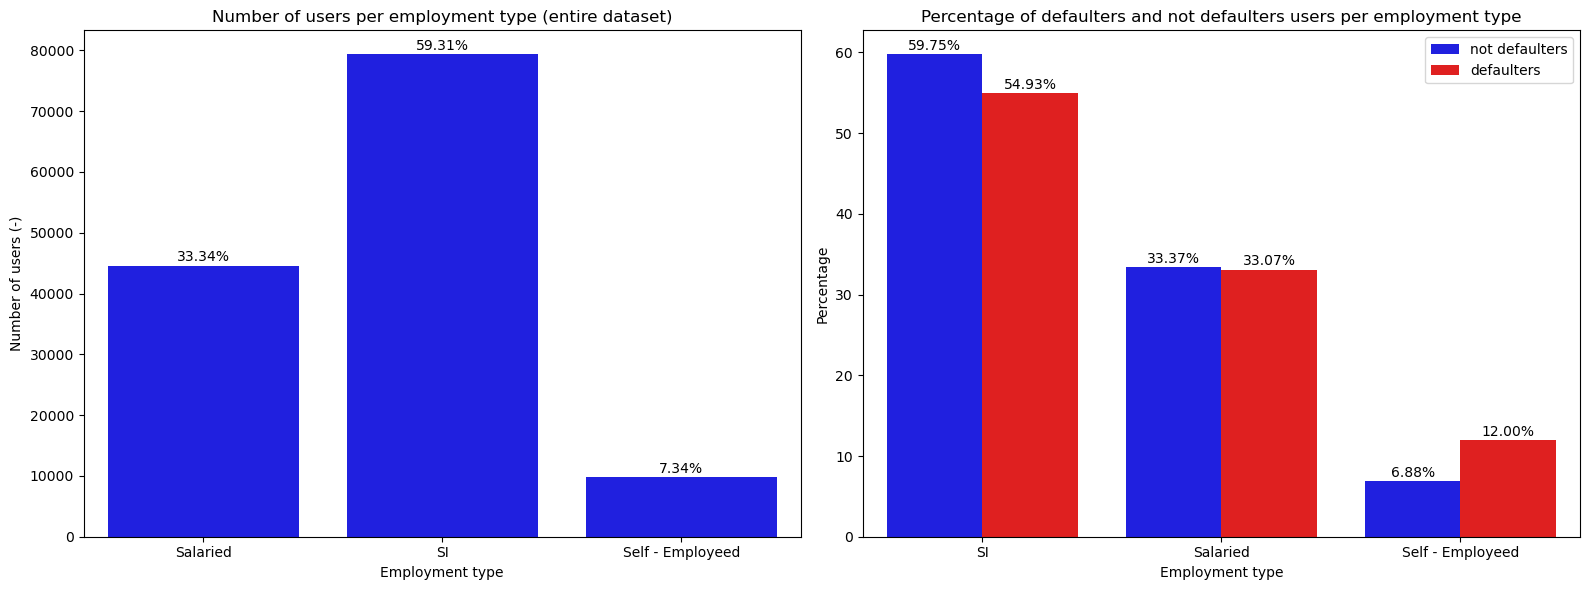

In [71]:
aux = df3.copy()

plt.figure(figsize=(16, 6))

plt.subplot(121)
ax1 = sns.countplot(x = 'employment_type', data = aux, color="blue")
for p in ax1.patches:
        ax1.annotate(format(str((p.get_height()/len(aux)*100).round(2)) + '%'), 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')
ax1 = plt.title("Number of users per employment type (entire dataset)", fontsize=12)
ax1 = plt.xlabel("Employment type", fontsize=10)
ax1 = plt.ylabel("Number of users (-)", fontsize=10)
#ax1 = plt.xticks(rotation=30)

plt.subplot(122)
ax1 = sns.barplot(x="employment_type", y="percentage", hue="category", data=aux3, 
                  hue_order=["not defaulters", "defaulters"], palette=["blue", "red"])

# bar labels 
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f') + '%', 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')

# titles
ax1 = plt.title("Percentage of defaulters and not defaulters users per employment type", fontsize=12)
ax1 = plt.xlabel("Employment type", fontsize=10)
ax1 = plt.ylabel("Percentage", fontsize=10)

# Adjustments
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

- Although self employed has the minority of people in the entire dataset, they showed higher percentage of defaulters when compared with not defaulters.
- This is an alert because people from this dataset which were self employed were more prone to be defaulters.
- These results suggest to include employment type as a variable of the model.

        - Majority: SI.
        - Which were more prone: self employed.

#### Tier of employment

In [72]:
# number of users which are not defaulters
aux1 = df3[df3["target"] == 0][["user_id", "tier_of_employment"]].groupby("tier_of_employment").nunique().\
                                                 reset_index().sort_values("tier_of_employment", ascending=True).\
                                                 rename(columns={"user_id":"count"}) 
aux1["total"] = aux1["count"].sum()
aux1["percentage"] = aux1.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux1["category"] = "not defaulters"

# number of defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "tier_of_employment"]].groupby("tier_of_employment").\
                                    nunique().reset_index().sort_values("tier_of_employment", ascending=True).\
                                    rename(columns={"user_id":"count"})
aux2["total"] = aux2["count"].sum()
aux2["percentage"] = aux2.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

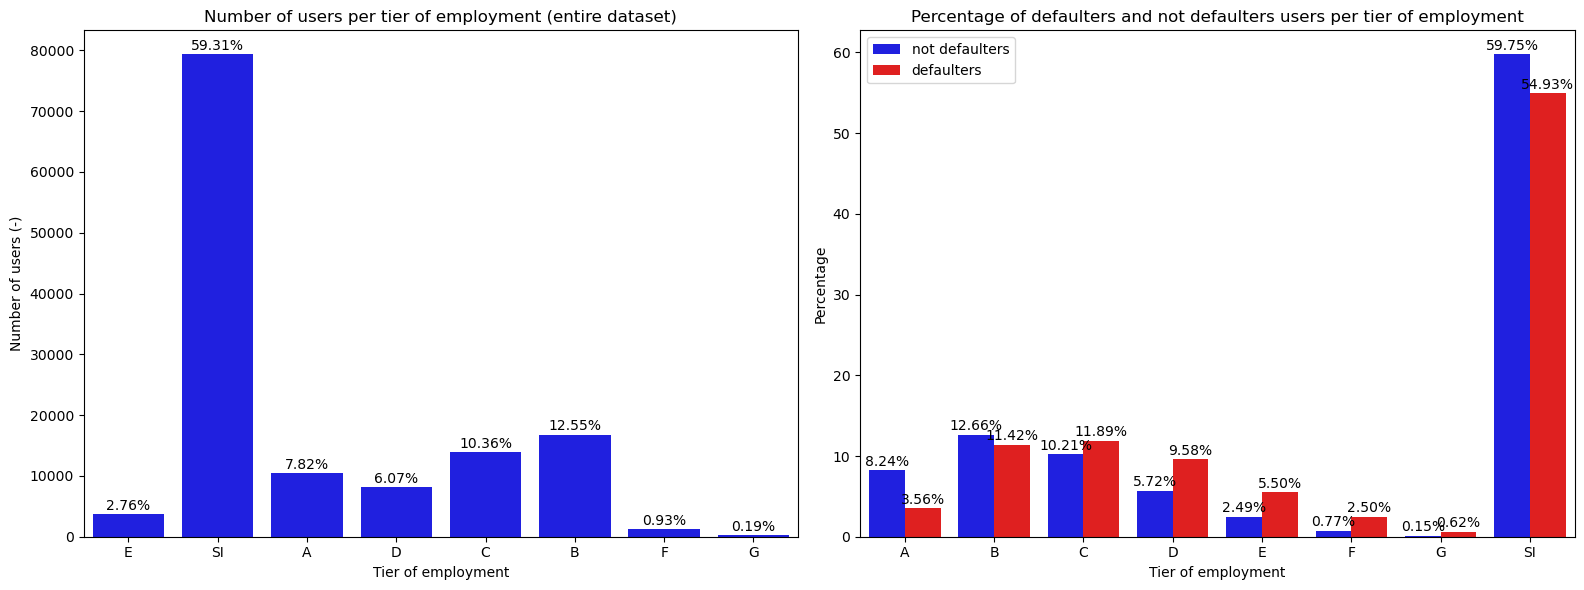

In [73]:
aux = df3.copy()

plt.figure(figsize=(16, 6))

plt.subplot(121)
ax1 = sns.countplot(x = 'tier_of_employment', data = aux, color="blue")
for p in ax1.patches:
        ax1.annotate(format(str((p.get_height()/len(aux)*100).round(2)) + '%'), 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')
ax1 = plt.title("Number of users per tier of employment (entire dataset)", fontsize=12)
ax1 = plt.xlabel("Tier of employment", fontsize=10)
ax1 = plt.ylabel("Number of users (-)", fontsize=10)
#ax1 = plt.xticks(rotation=30)

plt.subplot(122)
ax1 = sns.barplot(x="tier_of_employment", y="percentage", hue="category", data=aux3, 
                  hue_order=["not defaulters", "defaulters"], palette=["blue", "red"])

# bar labels 
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f') + '%', 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')

# titles
ax1 = plt.title("Percentage of defaulters and not defaulters users per tier of employment", fontsize=12)
ax1 = plt.xlabel("Tier of employment", fontsize=10)
ax1 = plt.ylabel("Percentage", fontsize=10)

# Adjustments
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

- Majority: SI.
- Which were more prone: C, D, E and F.

#### Role

In [74]:
# number of users which are not defaulters
aux1 = df3[df3["target"] == 0][["user_id", "role"]].groupby("role").nunique().\
                                                 reset_index().sort_values("role", ascending=True).\
                                                 rename(columns={"user_id":"count"}) 
aux1["total"] = aux1["count"].sum()
aux1["percentage"] = aux1.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux1["category"] = "not defaulters"

# Number of defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "role"]].groupby("role").\
                                    nunique().reset_index().sort_values("role", ascending=True).\
                                    rename(columns={"user_id":"count"})
aux2["total"] = aux2["count"].sum()
aux2["percentage"] = aux2.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

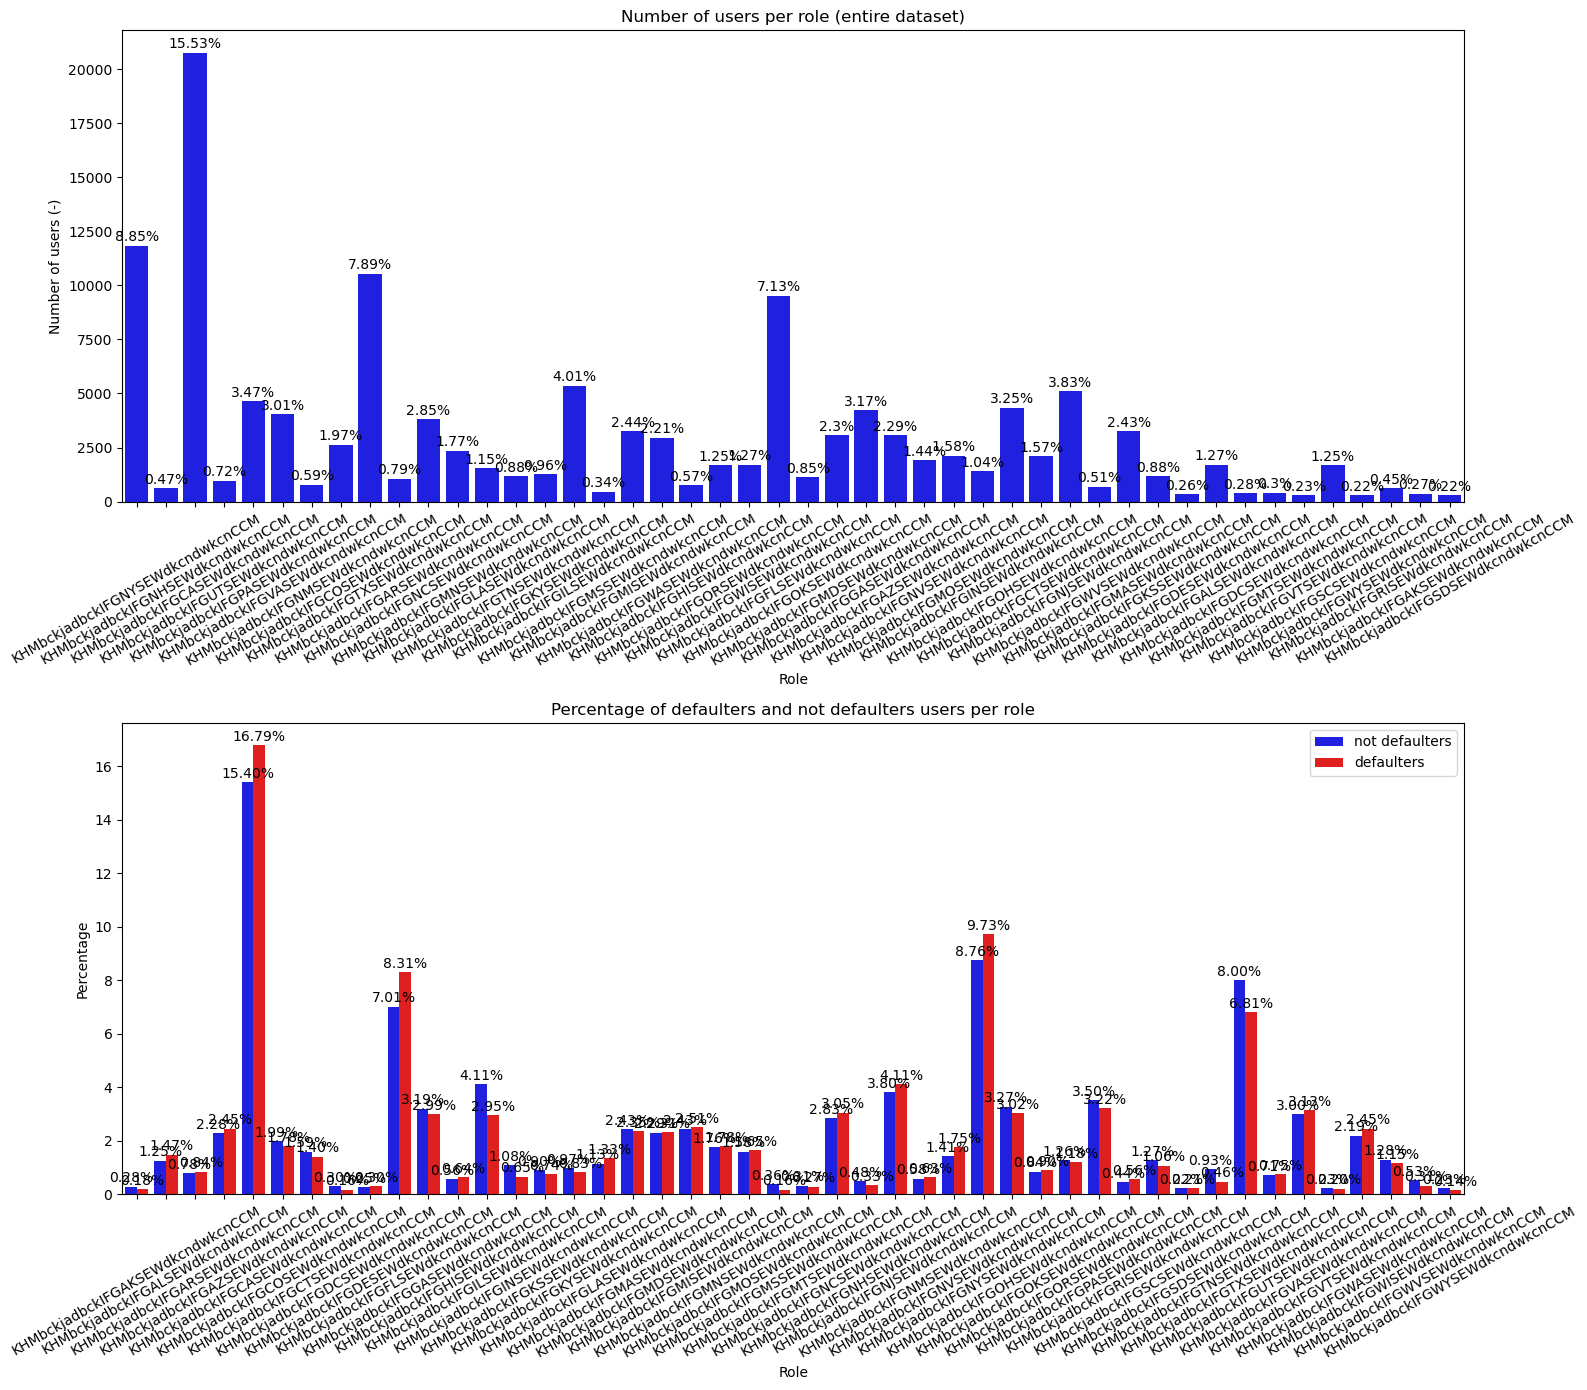

In [75]:
aux = df3.copy()

plt.figure(figsize=(16, 14))

plt.subplot(211)
ax1 = sns.countplot(x = 'role', data = aux, color="blue")
for p in ax1.patches:
        ax1.annotate(format(str((p.get_height()/len(aux)*100).round(2)) + '%'), 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')
ax1 = plt.title("Number of users per role (entire dataset)", fontsize=12)
ax1 = plt.xlabel("Role", fontsize=10)
ax1 = plt.ylabel("Number of users (-)", fontsize=10)
ax1 = plt.xticks(rotation=30)

plt.subplot(212)
ax1 = sns.barplot(x="role", y="percentage", hue="category", data=aux3, 
                  hue_order=["not defaulters", "defaulters"], palette=["blue", "red"])

# bar labels 
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f') + '%', 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')

# titles
ax1 = plt.title("Percentage of defaulters and not defaulters users per role", fontsize=12)
ax1 = plt.xlabel("Role", fontsize=10)
ax1 = plt.ylabel("Percentage", fontsize=10)
ax1 = plt.xticks(rotation=30)

# Adjustments
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

- Possibly we will not use it as a variable of the model since it seems an identification column.

#### Work experience

In [76]:
df3["work_experience"].dtypes

dtype('O')

In [77]:
# convert
df3["work_experience"] = df3["work_experience"].astype('str')

# standardize labels
df3["work_experience"] = df3["work_experience"].apply(lambda x: "0" if x == "0.0" else x)

In [78]:
# number of users which are not defaulters
aux1 = df3[df3["target"] == 0][["user_id", "work_experience"]].groupby("work_experience").nunique().\
                                                 reset_index().sort_values("work_experience", ascending=True).\
                                                 rename(columns={"user_id":"count"}) 
aux1["total"] = aux1["count"].sum()
aux1["percentage"] = aux1.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux1["category"] = "not defaulters"

# number of defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "work_experience"]].groupby("work_experience").\
                                    nunique().reset_index().sort_values("work_experience", ascending=True).\
                                    rename(columns={"user_id":"count"})
aux2["total"] = aux2["count"].sum()
aux2["percentage"] = aux2.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

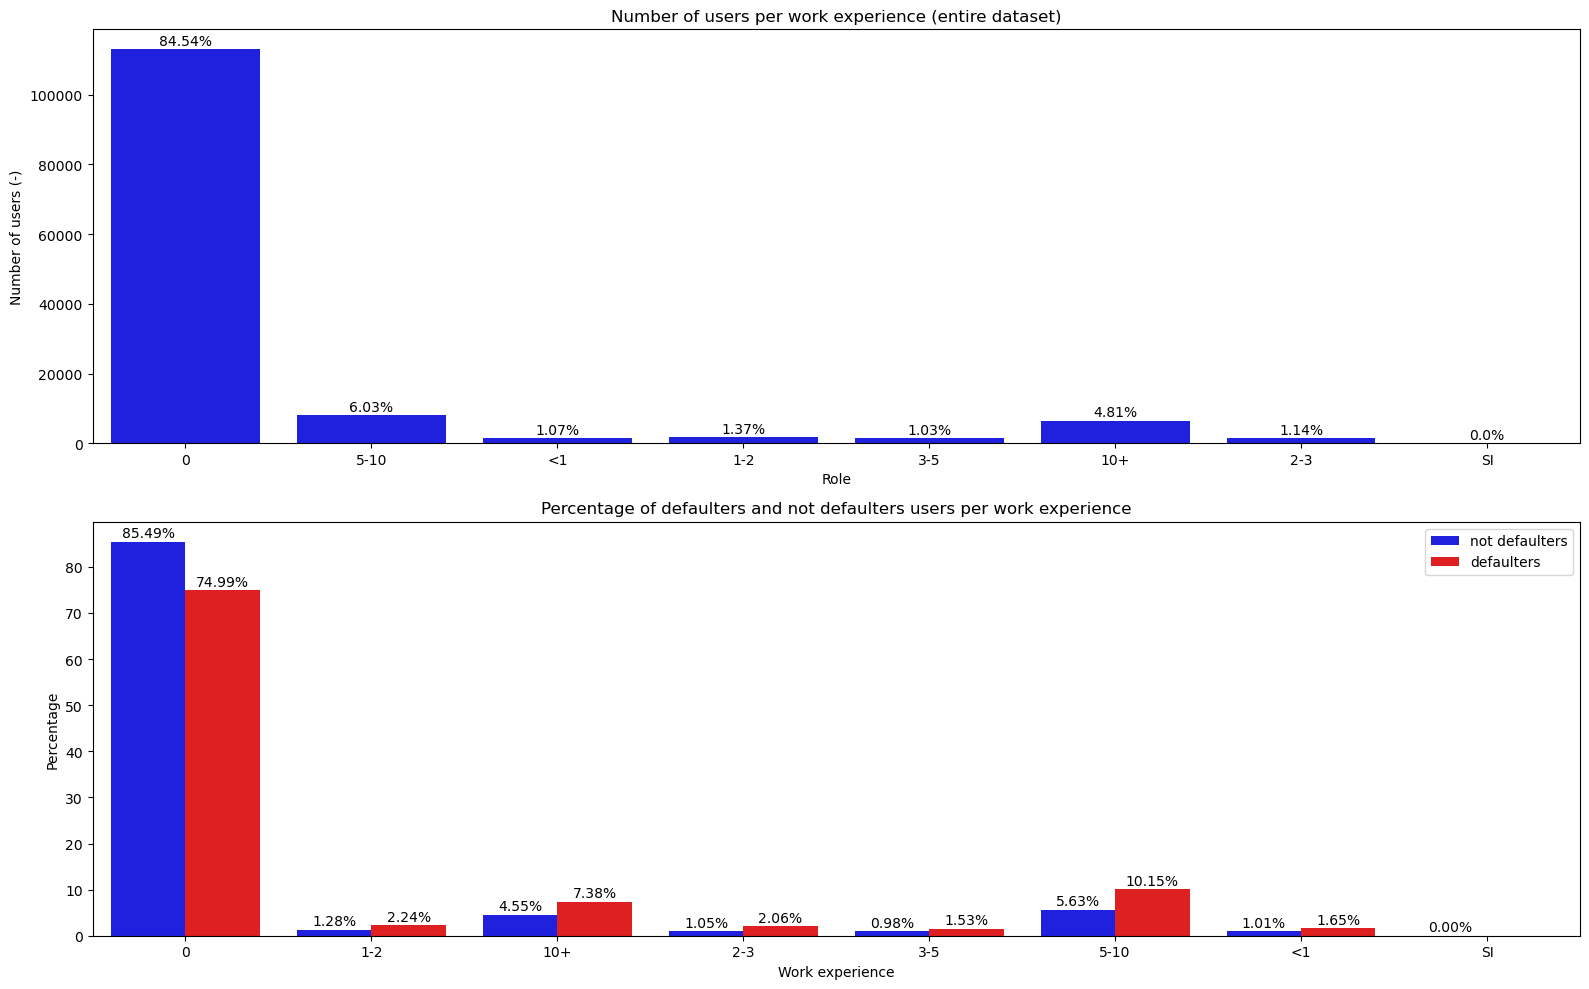

In [79]:
aux = df3.copy()

plt.figure(figsize=(16, 10))

plt.subplot(211)
ax1 = sns.countplot(x = 'work_experience', data = aux, color="blue")
for p in ax1.patches:
        ax1.annotate(format(str((p.get_height()/len(aux)*100).round(2)) + '%'), 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')
ax1 = plt.title("Number of users per work experience (entire dataset)", fontsize=12)
ax1 = plt.xlabel("Role", fontsize=10)
ax1 = plt.ylabel("Number of users (-)", fontsize=10)
# ax1 = plt.xticks(rotation=30)

plt.subplot(212)
ax1 = sns.barplot(x="work_experience", y="percentage", hue="category", data=aux3, 
                  hue_order=["not defaulters", "defaulters"], palette=["blue", "red"])

# bar labels 
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f') + '%', 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')

# titles
ax1 = plt.title("Percentage of defaulters and not defaulters users per work experience", fontsize=12)
ax1 = plt.xlabel("Work experience", fontsize=10)
ax1 = plt.ylabel("Percentage", fontsize=10)
# ax1 = plt.xticks(rotation=30)

# Adjustments
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

- Majority: 0.
- Which were more prone: 5-10 and 10+.

#### Gender

In [80]:
# number of users which are not defaulters
aux1 = df3[df3["target"] == 0][["user_id", "gender"]].groupby("gender").nunique().\
                                                 reset_index().sort_values("gender", ascending=True).\
                                                 rename(columns={"user_id":"count"}) 
aux1["total"] = aux1["count"].sum()
aux1["percentage"] = aux1.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux1["category"] = "not defaulters"

# number of defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "gender"]].groupby("gender").\
                                    nunique().reset_index().sort_values("gender", ascending=True).\
                                    rename(columns={"user_id":"count"})
aux2["total"] = aux2["count"].sum()
aux2["percentage"] = aux2.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

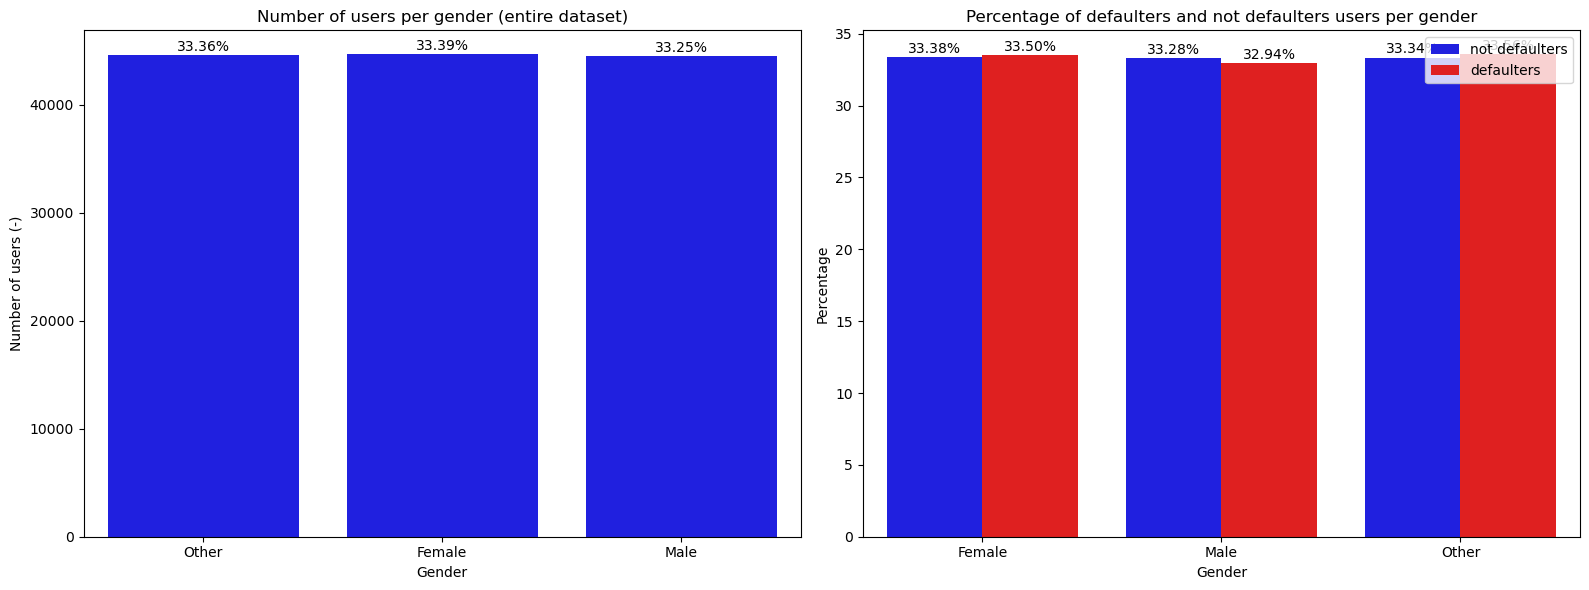

In [81]:
aux = df3.copy()

plt.figure(figsize=(16, 6))

plt.subplot(121)
ax1 = sns.countplot(x = 'gender', data = aux, color="blue")
for p in ax1.patches:
        ax1.annotate(format(str((p.get_height()/len(aux)*100).round(2)) + '%'), 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')
ax1 = plt.title("Number of users per gender (entire dataset)", fontsize=12)
ax1 = plt.xlabel("Gender", fontsize=10)
ax1 = plt.ylabel("Number of users (-)", fontsize=10)
# ax1 = plt.xticks(rotation=30)

plt.subplot(122)
ax1 = sns.barplot(x="gender", y="percentage", hue="category", data=aux3, 
                  hue_order=["not defaulters", "defaulters"], palette=["blue", "red"])

# bar labels 
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f') + '%', 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')

# titles
ax1 = plt.title("Percentage of defaulters and not defaulters users per gender", fontsize=12)
ax1 = plt.xlabel("Gender", fontsize=10)
ax1 = plt.ylabel("Percentage", fontsize=10)
# ax1 = plt.xticks(rotation=30)

# Adjusments
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

- None gender were more prone than the other.
- Maybe we may not select gender as a variable for the model.
- We mus take caution to use gender and develop a discriminant model.

#### Married

In [82]:
# number of users which are not defaulters
aux1 = df3[df3["target"] == 0][["user_id", "married"]].groupby("married").nunique().\
                                                 reset_index().sort_values("married", ascending=True).\
                                                 rename(columns={"user_id":"count"}) 
aux1["total"] = aux1["count"].sum()
aux1["percentage"] = aux1.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux1["category"] = "not defaulters"

# number of defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "married"]].groupby("married").\
                                    nunique().reset_index().sort_values("married", ascending=True).\
                                    rename(columns={"user_id":"count"})
aux2["total"] = aux2["count"].sum()
aux2["percentage"] = aux2.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

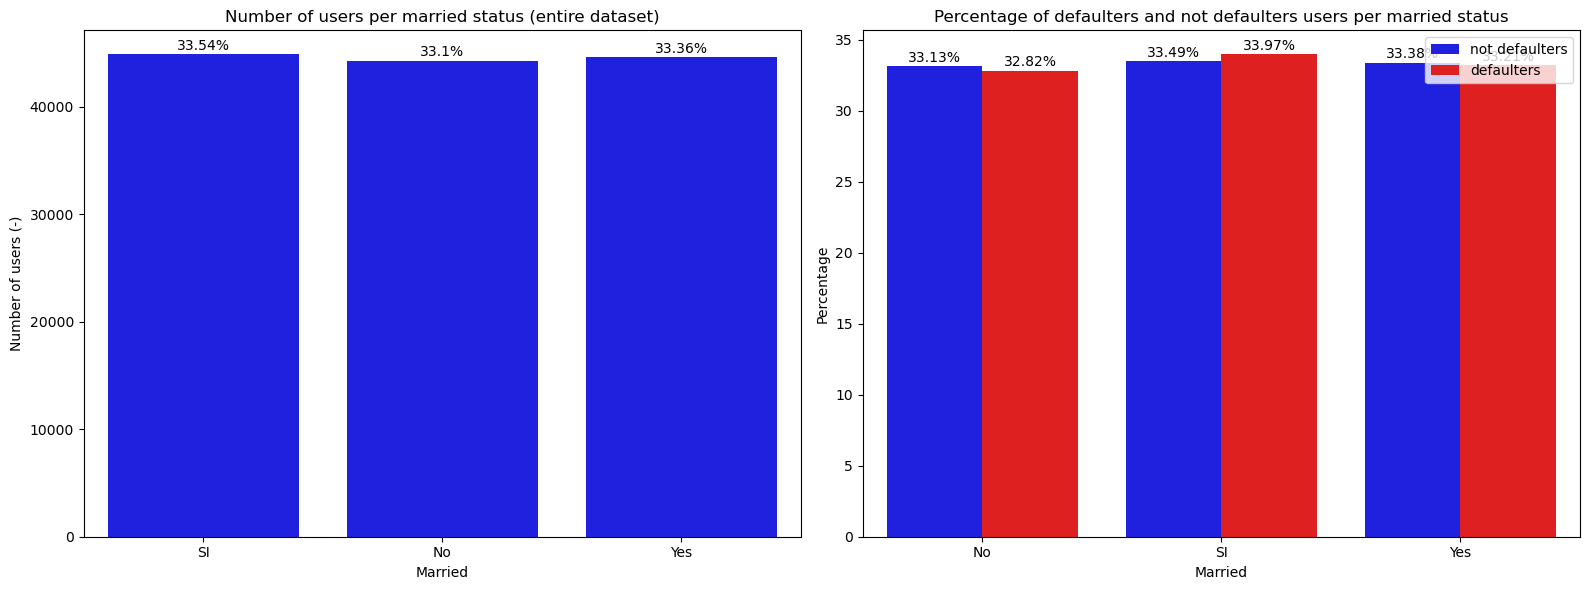

In [83]:
aux = df3.copy()

plt.figure(figsize=(16, 6))

plt.subplot(121)
ax1 = sns.countplot(x = 'married', data = aux, color="blue")
for p in ax1.patches:
        ax1.annotate(format(str((p.get_height()/len(aux)*100).round(2)) + '%'), 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')
ax1 = plt.title("Number of users per married status (entire dataset)", fontsize=12)
ax1 = plt.xlabel("Married", fontsize=10)
ax1 = plt.ylabel("Number of users (-)", fontsize=10)
# ax1 = plt.xticks(rotation=30)

plt.subplot(122)
ax1 = sns.barplot(x="married", y="percentage", hue="category", data=aux3, 
                  hue_order=["not defaulters", "defaulters"], palette=["blue", "red"])

# bar labels 
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f') + '%', 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')

# titles
ax1 = plt.title("Percentage of defaulters and not defaulters users per married status", fontsize=12)
ax1 = plt.xlabel("Married", fontsize=10)
ax1 = plt.ylabel("Percentage", fontsize=10)
# ax1 = plt.xticks(rotation=30)

# Adjustments
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

- None married status were more prone than the other.
- Maybe we may not select married status as a variable for the model.

#### Home type

In [84]:
# number of users which are not defaulters
aux1 = df3[df3["target"] == 0][["user_id", "home_type"]].groupby("home_type").nunique().\
                                                 reset_index().sort_values("home_type", ascending=True).\
                                                 rename(columns={"user_id":"count"}) 
aux1["total"] = aux1["count"].sum()
aux1["percentage"] = aux1.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux1["category"] = "not defaulters"

# number of defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "home_type"]].groupby("home_type").\
                                    nunique().reset_index().sort_values("home_type", ascending=True).\
                                    rename(columns={"user_id":"count"})
aux2["total"] = aux2["count"].sum()
aux2["percentage"] = aux2.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

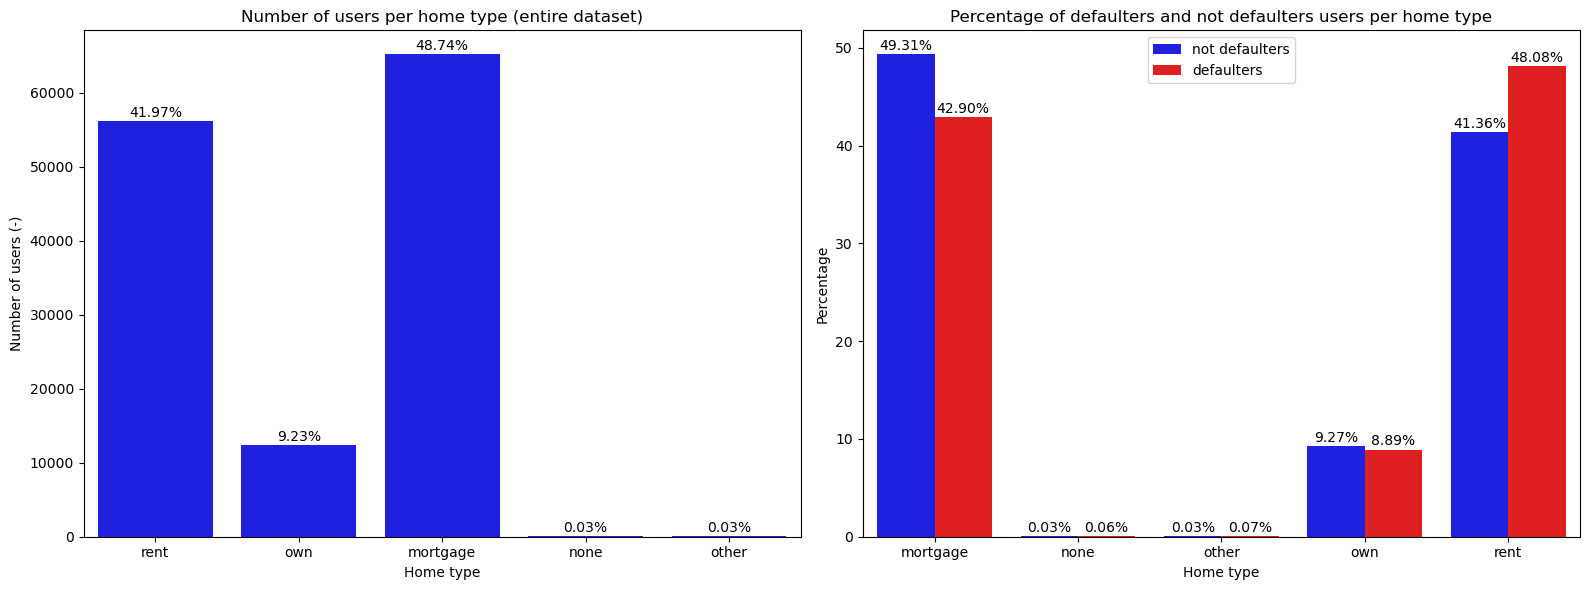

In [85]:
aux = df3.copy()

plt.figure(figsize=(16, 6))

plt.subplot(121)
ax1 = sns.countplot(x = 'home_type', data = aux, color="blue")
for p in ax1.patches:
        ax1.annotate(format(str((p.get_height()/len(aux)*100).round(2)) + '%'), 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')
ax1 = plt.title("Number of users per home type (entire dataset)", fontsize=12)
ax1 = plt.xlabel("Home type", fontsize=10)
ax1 = plt.ylabel("Number of users (-)", fontsize=10)
# ax1 = plt.xticks(rotation=30)

plt.subplot(122)
ax1 = sns.barplot(x="home_type", y="percentage", hue="category", data=aux3, 
                  hue_order=["not defaulters", "defaulters"], palette=["blue", "red"])

# bar labels 
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f') + '%', 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')

# titles
ax1 = plt.title("Percentage of defaulters and not defaulters users per home type", fontsize=12)
ax1 = plt.xlabel("Home type", fontsize=10)
ax1 = plt.ylabel("Percentage", fontsize=10)
# ax1 = plt.xticks(rotation=30)

# Adjustments
plt.legend(loc="upper center")
plt.tight_layout()
plt.show()

- Majority is of mortgage category for home type.
- However, people of the rent home type were more prone to be a defaulter.
- This is a very important variable to be used in the model.

#### Has social profile

In [86]:
# number of users which are not defaulters
aux1 = df3[df3["target"] == 0][["user_id", "has_social_profile"]].groupby("has_social_profile").nunique().\
                                                 reset_index().sort_values("has_social_profile", ascending=True).\
                                                 rename(columns={"user_id":"count"}) 
aux1["total"] = aux1["count"].sum()
aux1["percentage"] = aux1.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux1["category"] = "not defaulters"

# number of defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "has_social_profile"]].groupby("has_social_profile").\
                                    nunique().reset_index().sort_values("has_social_profile", ascending=True).\
                                    rename(columns={"user_id":"count"})
aux2["total"] = aux2["count"].sum()
aux2["percentage"] = aux2.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

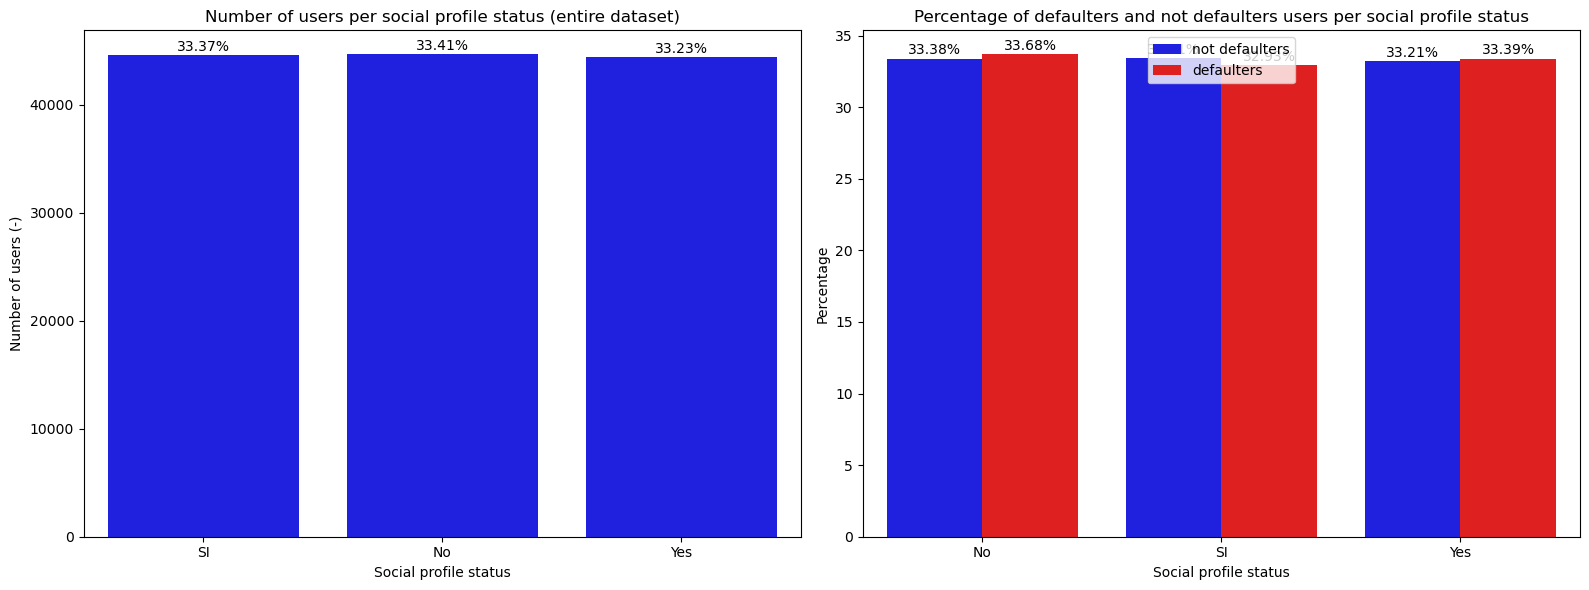

In [87]:
aux = df3.copy()

plt.figure(figsize=(16, 6))

plt.subplot(121)
ax1 = sns.countplot(x = 'has_social_profile', data = aux, color="blue")
for p in ax1.patches:
        ax1.annotate(format(str((p.get_height()/len(aux)*100).round(2)) + '%'), 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')
ax1 = plt.title("Number of users per social profile status (entire dataset)", fontsize=12)
ax1 = plt.xlabel("Social profile status", fontsize=10)
ax1 = plt.ylabel("Number of users (-)", fontsize=10)
# ax1 = plt.xticks(rotation=30)

plt.subplot(122)
ax1 = sns.barplot(x="has_social_profile", y="percentage", hue="category", data=aux3, 
                  hue_order=["not defaulters", "defaulters"], palette=["blue", "red"])

# bar labels 
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f') + '%', 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')

# titles
ax1 = plt.title("Percentage of defaulters and not defaulters users per social profile status", fontsize=12)
ax1 = plt.xlabel("Social profile status", fontsize=10)
ax1 = plt.ylabel("Percentage", fontsize=10)
# ax1 = plt.xticks(rotation=30)

# Adjustments
plt.legend(loc="upper center")
plt.tight_layout()
plt.show()

- None social profile status were more prone than the other.
- Maybe we may not select social profile status as a variable for the model.

#### Verified social profile

In [88]:
# number of users which are not defaulters
aux1 = df3[df3["target"] == 0][["user_id", "is_verified"]].groupby("is_verified").nunique().\
                                                 reset_index().sort_values("is_verified", ascending=True).\
                                                 rename(columns={"user_id":"count"}) 
aux1["total"] = aux1["count"].sum()
aux1["percentage"] = aux1.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux1["category"] = "not defaulters"

# number of defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "is_verified"]].groupby("is_verified").\
                                    nunique().reset_index().sort_values("is_verified", ascending=True).\
                                    rename(columns={"user_id":"count"})
aux2["total"] = aux2["count"].sum()
aux2["percentage"] = aux2.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

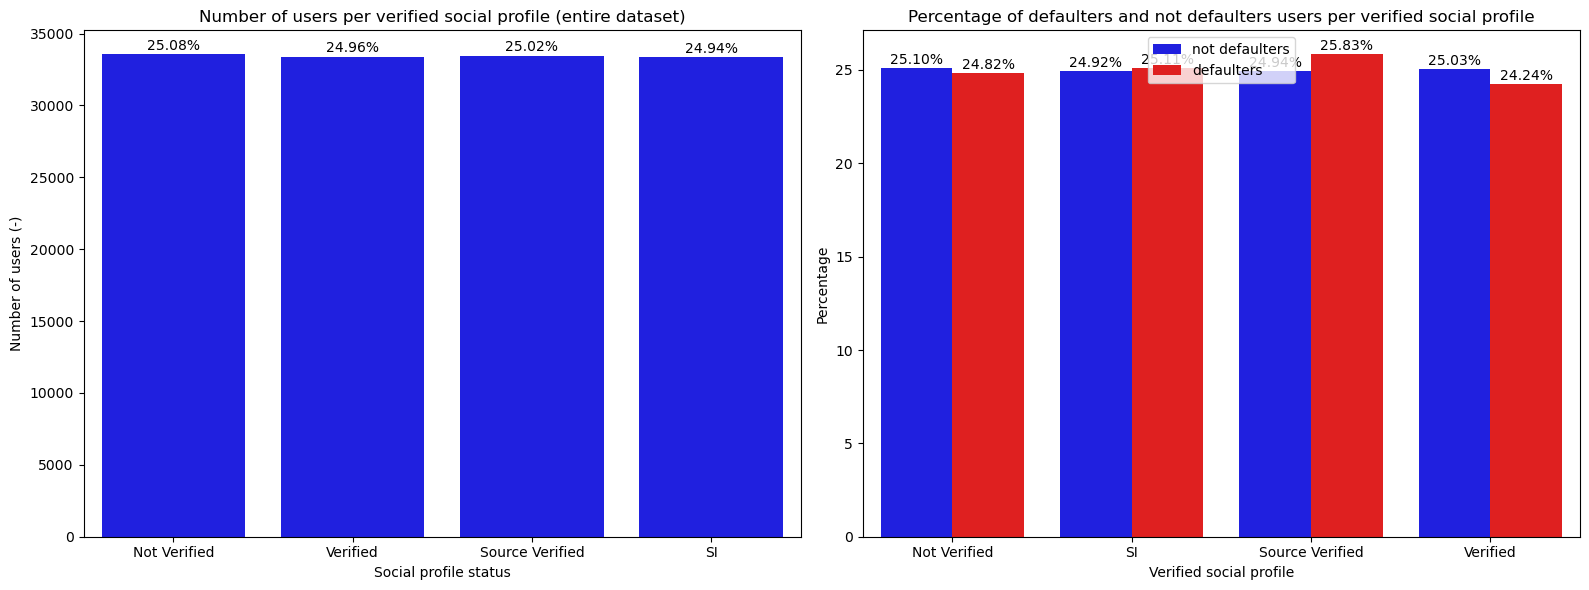

In [89]:
aux = df3.copy()

plt.figure(figsize=(16, 6))

plt.subplot(121)
ax1 = sns.countplot(x = 'is_verified', data = aux, color="blue")
for p in ax1.patches:
        ax1.annotate(format(str((p.get_height()/len(aux)*100).round(2)) + '%'), 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')
ax1 = plt.title("Number of users per verified social profile (entire dataset)", fontsize=12)
ax1 = plt.xlabel("Social profile status", fontsize=10)
ax1 = plt.ylabel("Number of users (-)", fontsize=10)
# ax1 = plt.xticks(rotation=30)

plt.subplot(122)
ax1 = sns.barplot(x="is_verified", y="percentage", hue="category", data=aux3, 
                  hue_order=["not defaulters", "defaulters"], palette=["blue", "red"])

# bar labels 
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f') + '%', 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')

# titles
ax1 = plt.title("Percentage of defaulters and not defaulters users per verified social profile", fontsize=12)
ax1 = plt.xlabel("Verified social profile", fontsize=10)
ax1 = plt.ylabel("Percentage", fontsize=10)
# ax1 = plt.xticks(rotation=30)

# Adjustments
plt.legend(loc="upper center")
plt.tight_layout()
plt.show()

- Since we may not use social profile status variable, the verified social profile variable does not make sense to be used. 
- None social profile status were more prone than the other.
- Maybe we may not select social profile status as a variable for the model.

### 3.3.2. Numerical Attributes (continuous)

In [90]:
num_attributes.apply(lambda x: x.unique().shape[0] )

total_income                11344
dependents                      5
delinq_2yrs                    22
total_payement             103619
received_principal          41878
interest_received           93402
number_of_loans                 5
emi_1_dpd                       4
emi_2_dpd                       4
emi_3_dpd                       4
emi_4_dpd                       4
emi_5_dpd                       4
emi_6_dpd                       4
max_dpd                         4
target                          2
interest_received_ratio    104890
total_payement_per_loan       561
delinq_2yrs_ratio              10
month_yearmo                    5
dtype: int64

#### Total income

In [91]:
# not defaulters users
aux1 = df3[df3["target"] == 0][["user_id", "total_income"]]
aux1["category"] = "not defaulters"

# defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "total_income"]]
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

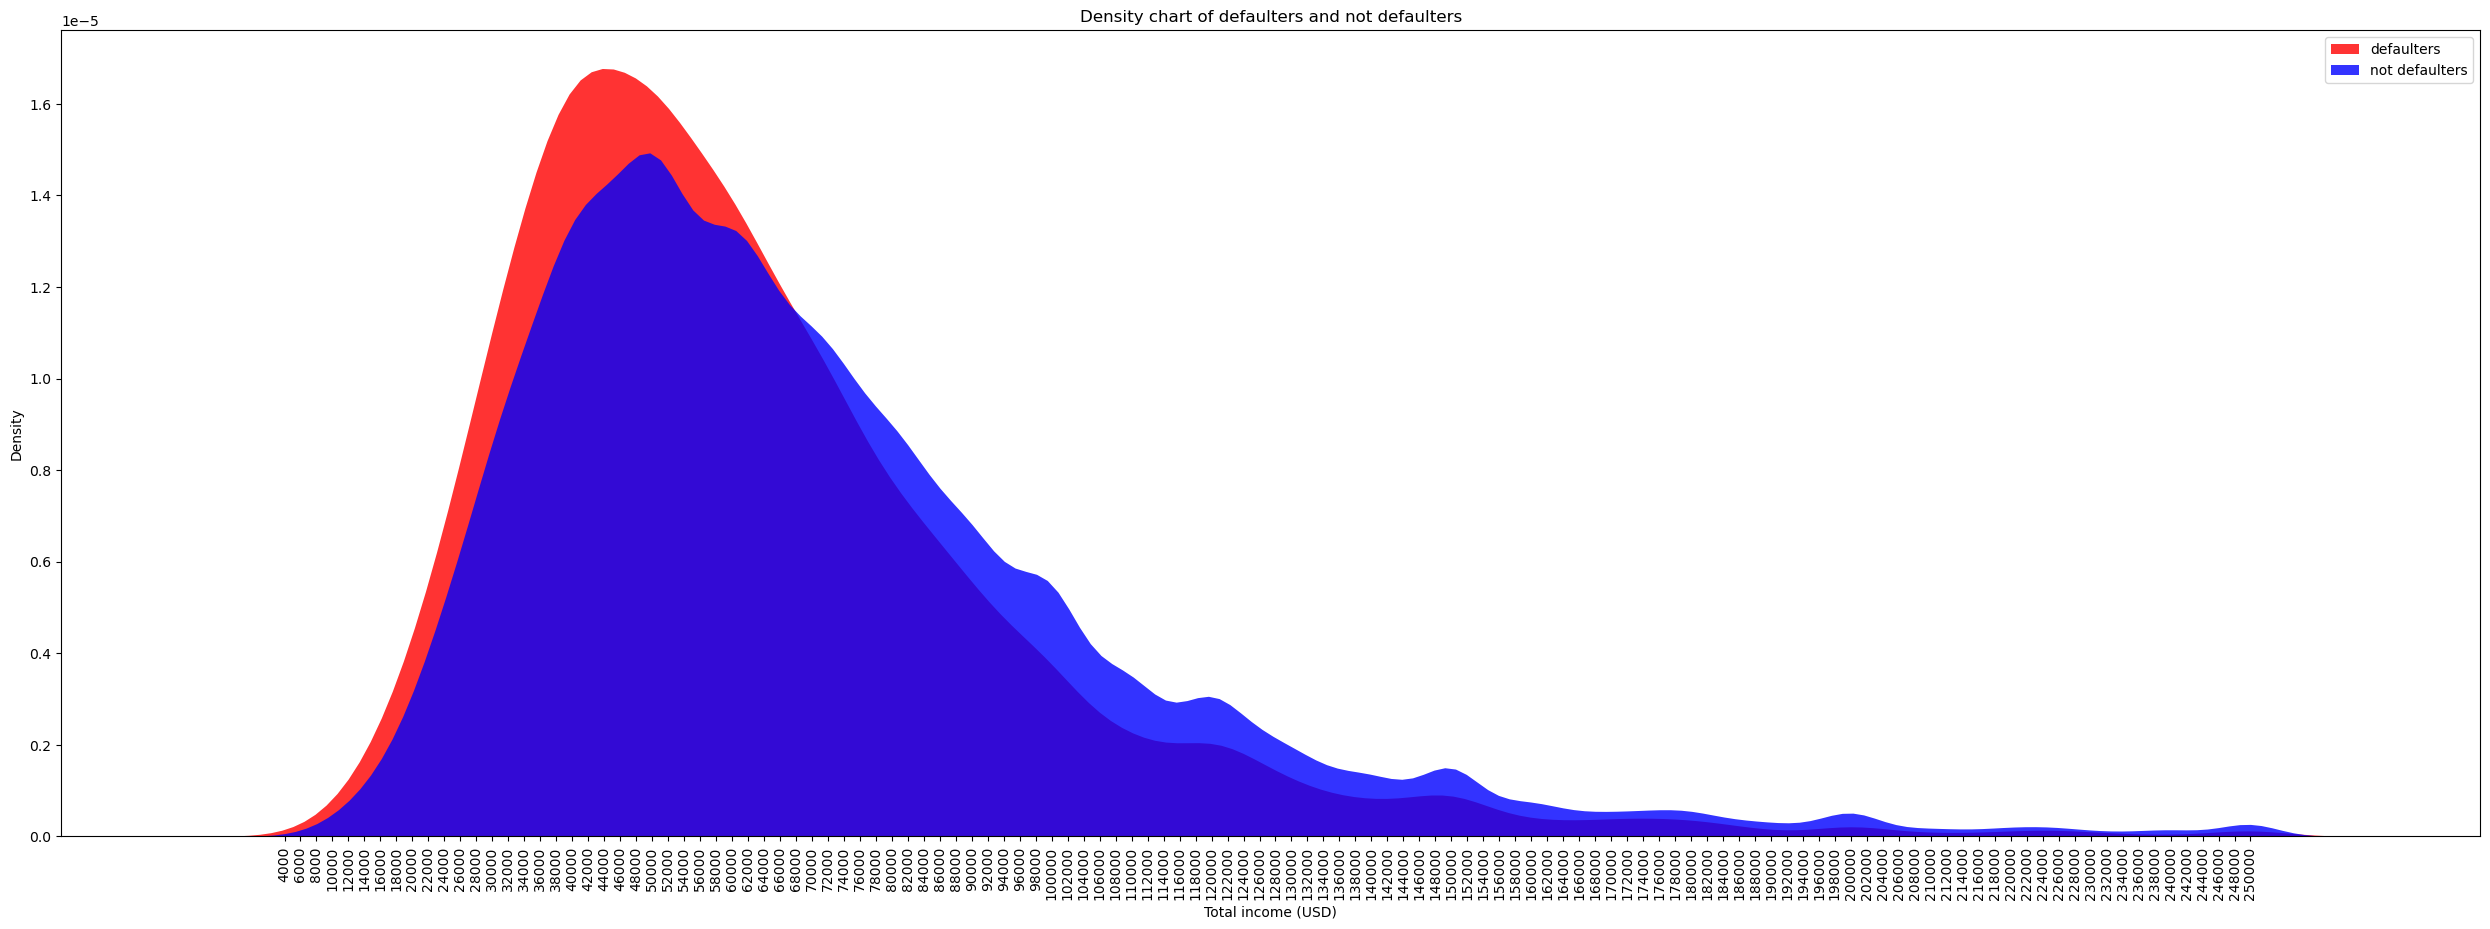

In [92]:
# Chart dimensions
fig, ax = plt.subplots(figsize = (25, 9))

# Data filtering
aux3 = aux3[(aux3["total_income"].notnull()) & (aux3["total_income"] >= 0)
           & (aux3["total_income"] <= 250000)]

# Plot 
sns.kdeplot(data=aux3, x="total_income", hue="category", hue_order=["not defaulters", "defaulters"],
            palette=["blue", "red"], fill=True, alpha=0.8, common_norm=False, linewidth=0)

# Titles
ax.set_title("Density chart of defaulters and not defaulters", fontsize=12)
ax.set_xlabel("Total income (USD)", fontsize=10)
ax.set_ylabel("Density", fontsize=10)

# Adjustments
plt.legend(labels=["defaulters", "not defaulters"], loc="upper right")
plt.tight_layout()

# changing x-axis grading
min_value = int(min(aux3["total_income"]))
max_value = int(max(aux3["total_income"]))
plt.xticks(range(min_value, max_value + 50, 2000))
plt.xticks(rotation=90)

# display chart
plt.show()

In [93]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(df3[(df3["target"] == 1)]["total_income"]).describe().T

,count,mean,std,min,25%,50%,75%,max
total_income,12065.00,64070.35,39098.94,4800.00,40000.00,55000.00,76000.00,900000.00


- Range where we could find defaulters: lower than 70000 USD.
- Total income median for defaulters: 55000 USD.
- Total income average for defaulters: 64000 USD.

- People with lower total income were more prone to be defaulters.
- This variable may be a good variable to give information to the model.

#### Total payement

In [94]:
# not defaulters users
aux1 = df3[df3["target"] == 0][["user_id", "total_payement"]]
aux1["category"] = "not defaulters"

# defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "total_payement"]]
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

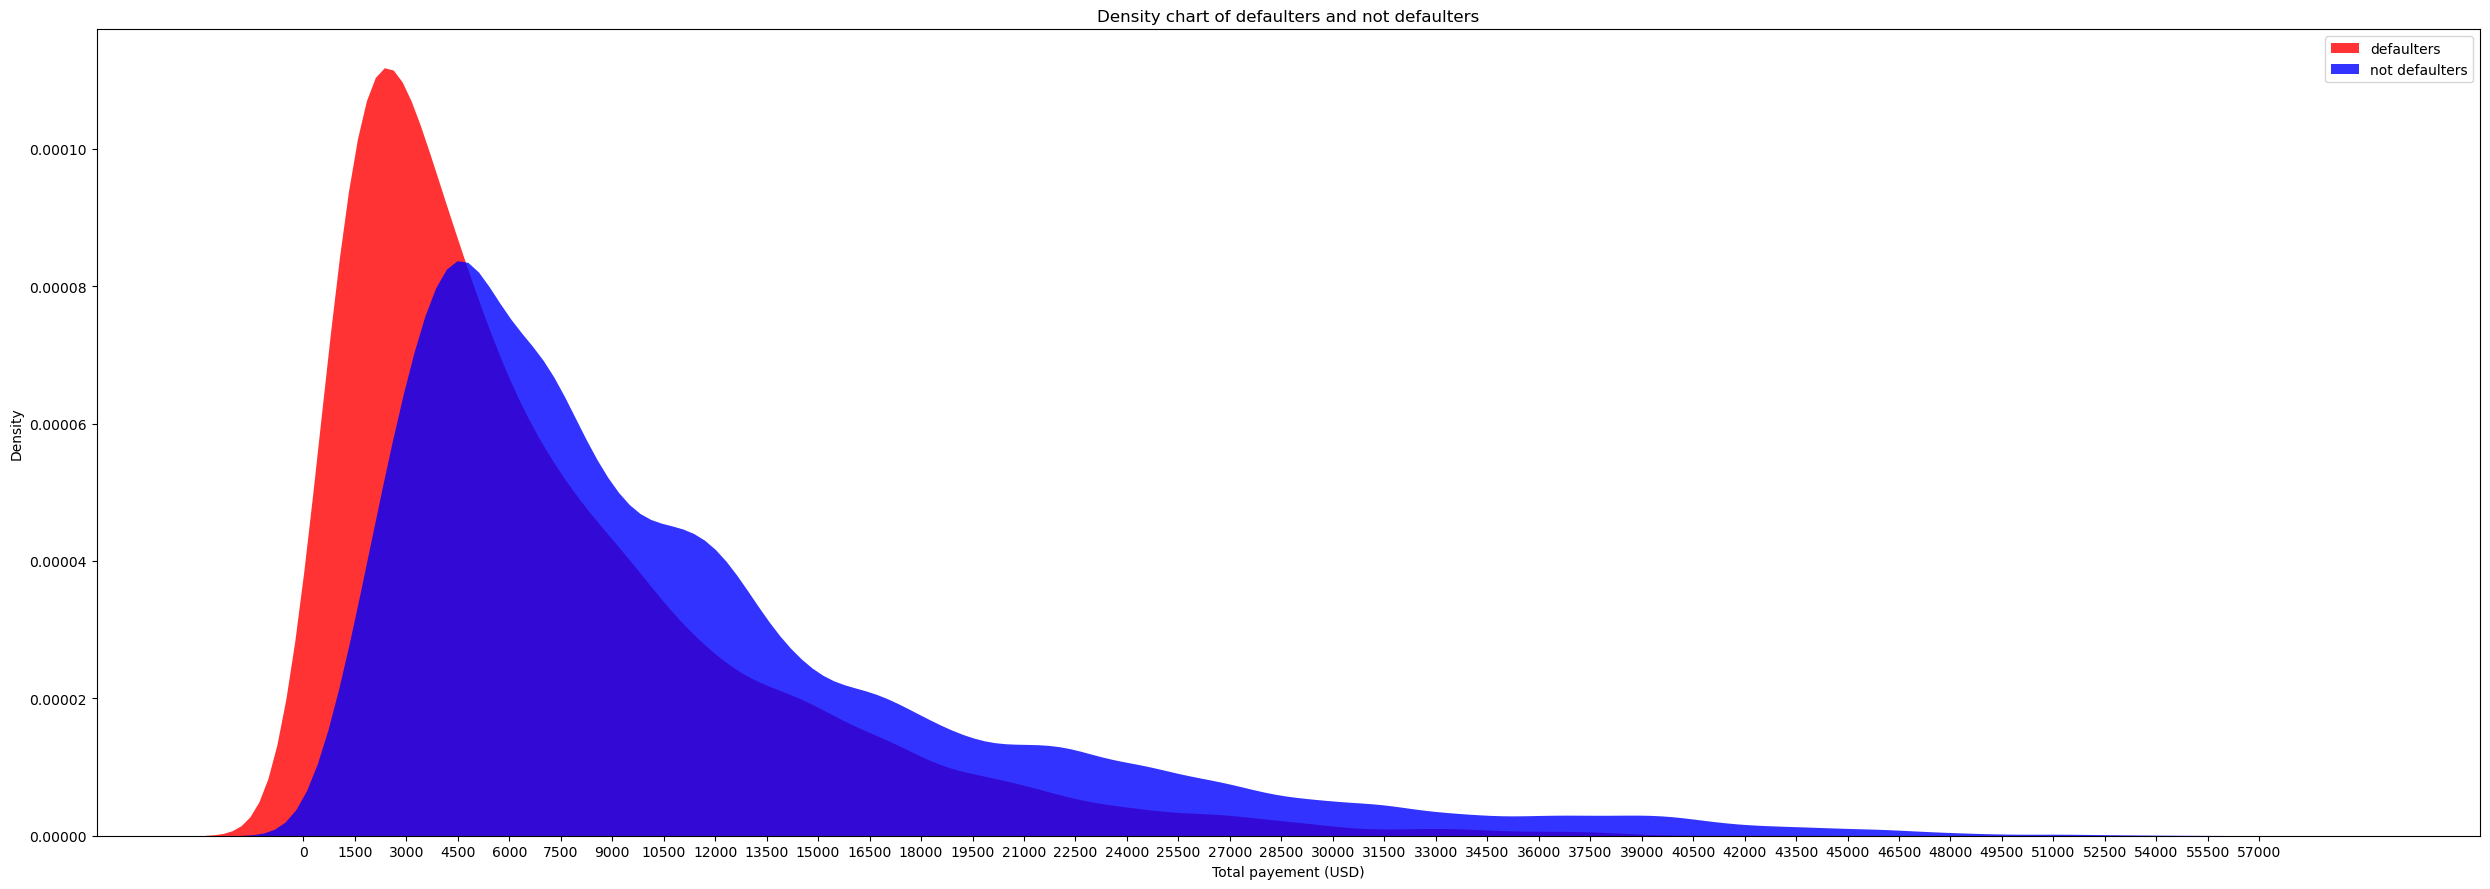

In [95]:
# Chart dimensions
fig, ax = plt.subplots(figsize = (25, 9))

# Data filtering
# aux3 = aux3[(aux3["total_payement"].notnull()) & (aux3["total_payement"] >= 0)
#            & (aux3["total_payement"] <= 250000)]

# Plot 
sns.kdeplot(data=aux3, x="total_payement", hue="category", hue_order=["not defaulters", "defaulters"],
            palette=["blue", "red"], fill=True, alpha=0.8, common_norm=False, linewidth=0)

# Titles
ax.set_title("Density chart of defaulters and not defaulters", fontsize=12)
ax.set_xlabel("Total payement (USD)", fontsize=10)
ax.set_ylabel("Density", fontsize=10)

# Adjustments
plt.legend(labels=["defaulters", "not defaulters"], loc="upper right")
plt.tight_layout()

# changing x-axis grading
min_value = int(min(aux3["total_payement"]))
max_value = int(max(aux3["total_payement"]))
plt.xticks(range(min_value, max_value + 50, 1500))
#plt.xticks(rotation=90)

# display chart
plt.show()

In [96]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(df3[(df3["target"] == 1)]["total_payement"]).describe().T

,count,mean,std,min,25%,50%,75%,max
total_payement,12065.00,7101.68,6247.19,0.00,2559.49,5127.44,9750.24,46199.44


- Range where we could find defaulters: lower than 4500 USD.
- Total payement median for defaulters: 5000 USD.
- Total payement average for defaulters: 7000 USD.

- People with lower total payement were more prone to be a defaulter.
- This variable may be a good variable to give information to the model.

#### Received principal

In [97]:
# not defaulters users
aux1 = df3[df3["target"] == 0][["user_id", "received_principal"]]
aux1["category"] = "not defaulters"

# defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "received_principal"]]
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

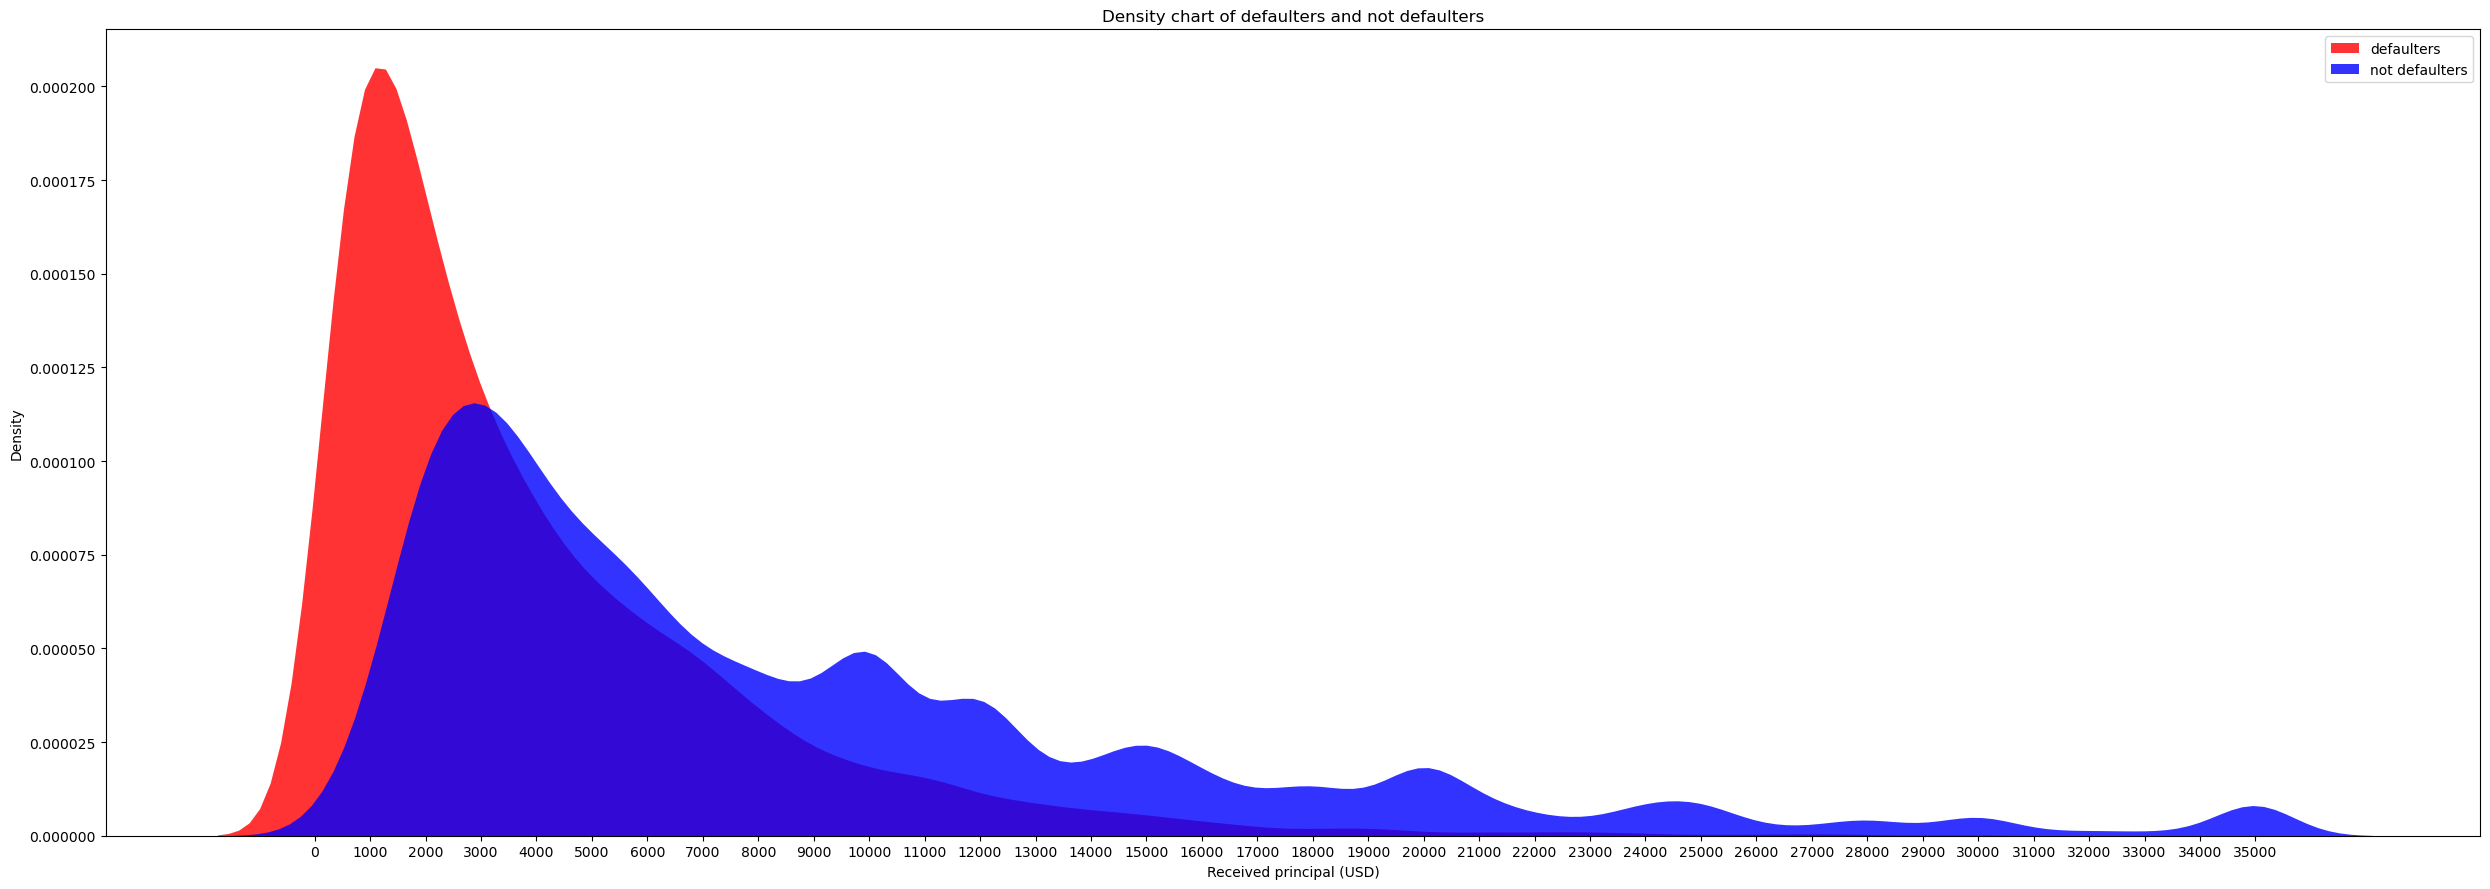

In [98]:
# Chart dimensions
fig, ax = plt.subplots(figsize = (25, 9))

# Data filtering
# aux3 = aux3[(aux3["received_principal"].notnull()) & (aux3["received_principal"] >= 0)
#            & (aux3["received_principal"] <= 250000)]

# Plot 
sns.kdeplot(data=aux3, x="received_principal", hue="category", hue_order=["not defaulters", "defaulters"],
            palette=["blue", "red"], fill=True, alpha=0.8, common_norm=False, linewidth=0)

# Titles
ax.set_title("Density chart of defaulters and not defaulters", fontsize=12)
ax.set_xlabel("Received principal (USD)", fontsize=10)
ax.set_ylabel("Density", fontsize=10)

# Adjustments
plt.legend(labels=["defaulters", "not defaulters"], loc="upper right")
plt.tight_layout()

# changing x-axis grading
min_value = int(min(aux3["received_principal"]))
max_value = int(max(aux3["received_principal"]))
plt.xticks(range(min_value, max_value + 50, 1000))
#plt.xticks(rotation=90)

# display chart
plt.show()

In [99]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(df3[(df3["target"] == 1)]["received_principal"]).describe().T

,count,mean,std,min,25%,50%,75%,max
received_principal,12065.00,3889.17,3819.87,0.00,1218.62,2620.19,5411.39,34130.64


- Range where we could find defaulters: lower than 3000 USD.
- Received principal median for defaulters: 2600 USD.
- Received principal average for defaulters: 3900 USD.

- People with lower received principal were more prone to be a defaulter.
- This variable may be a good variable to give information to the model.

#### Interest received

In [100]:
# not defaulters users
aux1 = df3[df3["target"] == 0][["user_id", "interest_received"]]
aux1["category"] = "not defaulters"

# defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "interest_received"]]
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

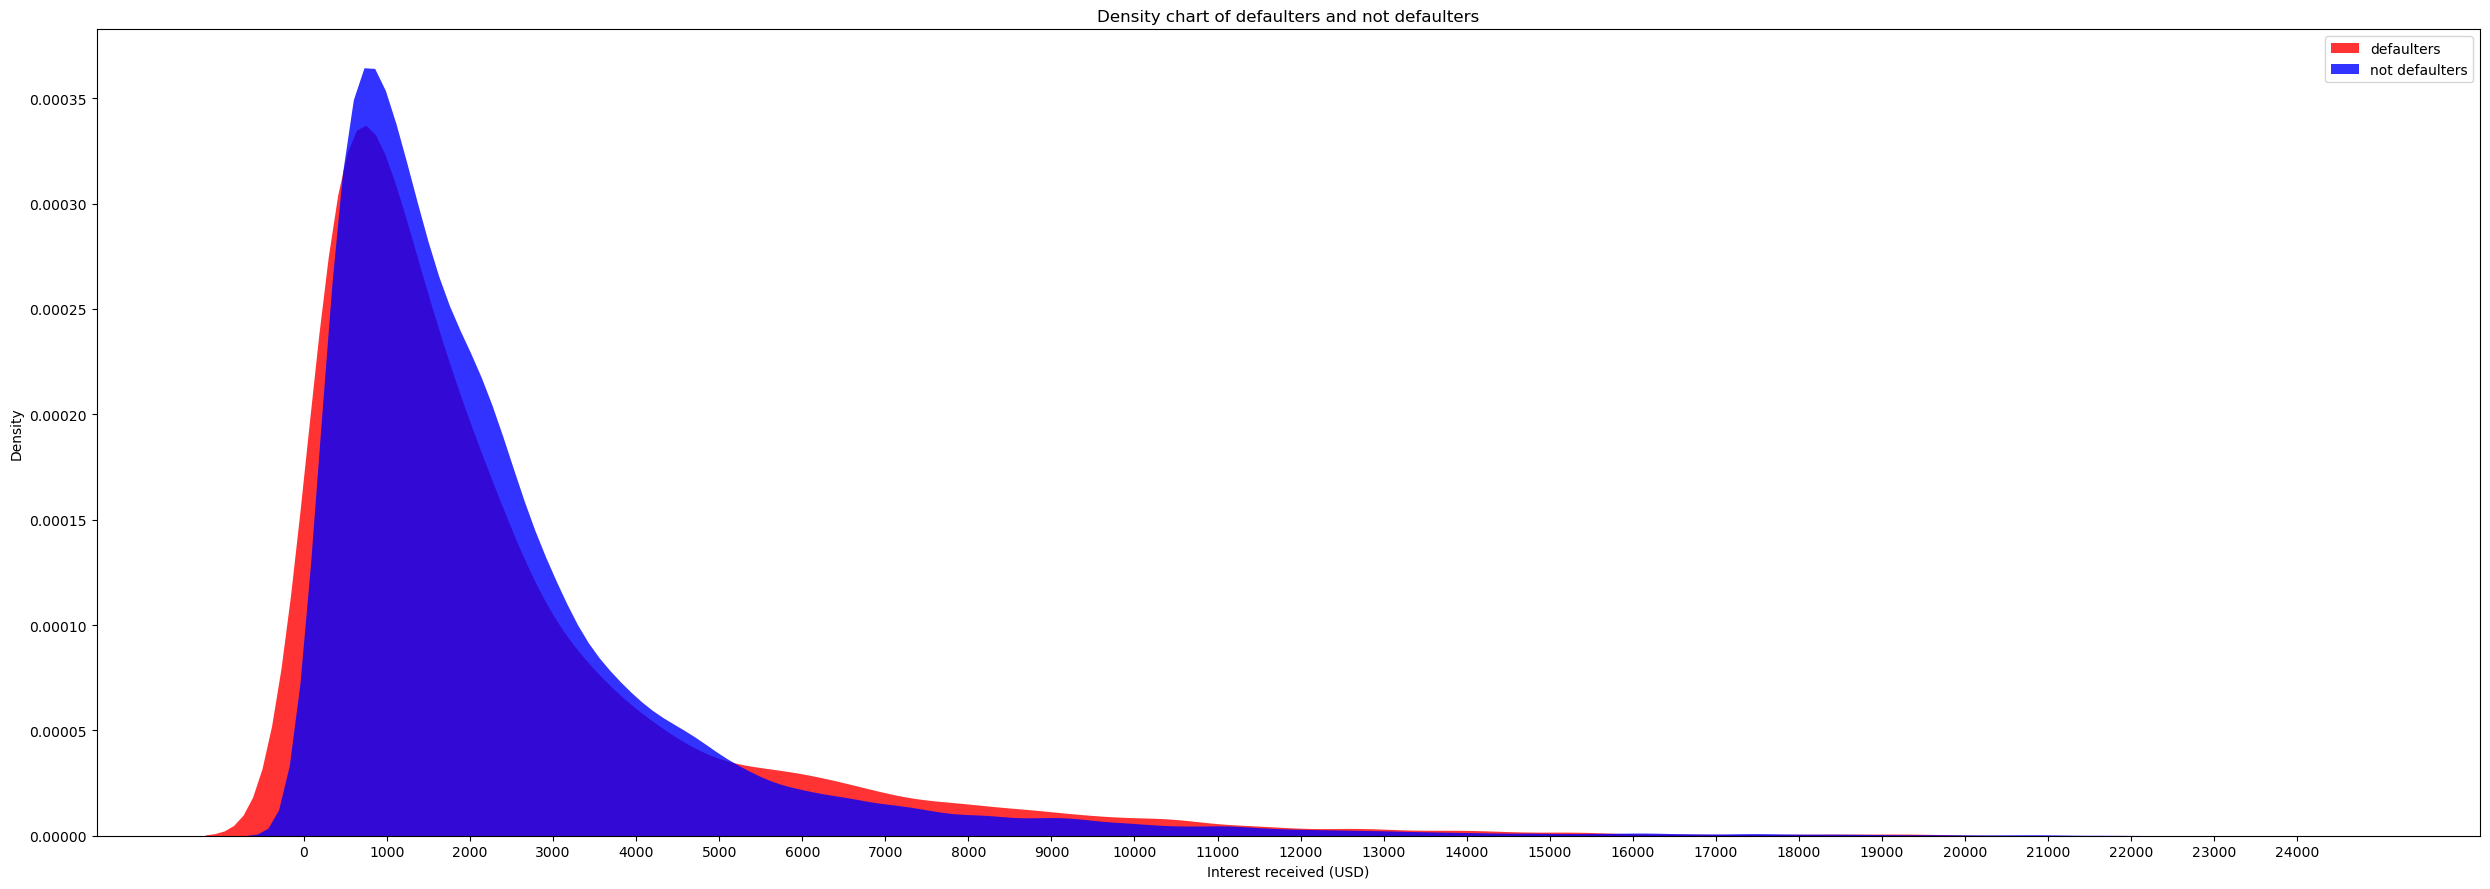

In [101]:
# Chart dimensions
fig, ax = plt.subplots(figsize = (25, 9))

# Data filtering
# aux3 = aux3[(aux3["interest_received"].notnull()) & (aux3["interest_received"] >= 0)
#            & (aux3["interest_received"] <= 250000)]

# Plot 
sns.kdeplot(data=aux3, x="interest_received", hue="category", hue_order=["not defaulters", "defaulters"],
            palette=["blue", "red"], fill=True, alpha=0.8, common_norm=False, linewidth=0)

# Titles
ax.set_title("Density chart of defaulters and not defaulters", fontsize=12)
ax.set_xlabel("Interest received (USD)", fontsize=10)
ax.set_ylabel("Density", fontsize=10)

# Adjustments
plt.legend(labels=["defaulters", "not defaulters"], loc="upper right")
plt.tight_layout()

# changing x-axis grading
min_value = int(min(aux3["interest_received"]))
max_value = int(max(aux3["interest_received"]))
plt.xticks(range(min_value, max_value + 50, 1000))
#plt.xticks(rotation=90)

# display chart
plt.show()

In [102]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(df3[(df3["target"] == 1)]["interest_received"]).describe().T

,count,mean,std,min,25%,50%,75%,max
interest_received,12065.00,2354.21,2596.54,0.00,694.47,1482.60,2944.46,20295.76


- Range where we could find defaulters: 6000 up to 10000 USD.
- Interest received median for defaulters: 1500 USD.
- Interest received average for defaulters: 2300 USD.

- People with interest received between 6000 and 10000 USD were more prone to be a defaulter.
- This variable may be a good variable to give information to the model.

#### Interest received ratio

Juros recebido/pagamento total.

In [103]:
# not defaulters users
aux1 = df3[df3["target"] == 0][["user_id", "interest_received_ratio"]]
aux1["category"] = "not defaulters"

# defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "interest_received_ratio"]]
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

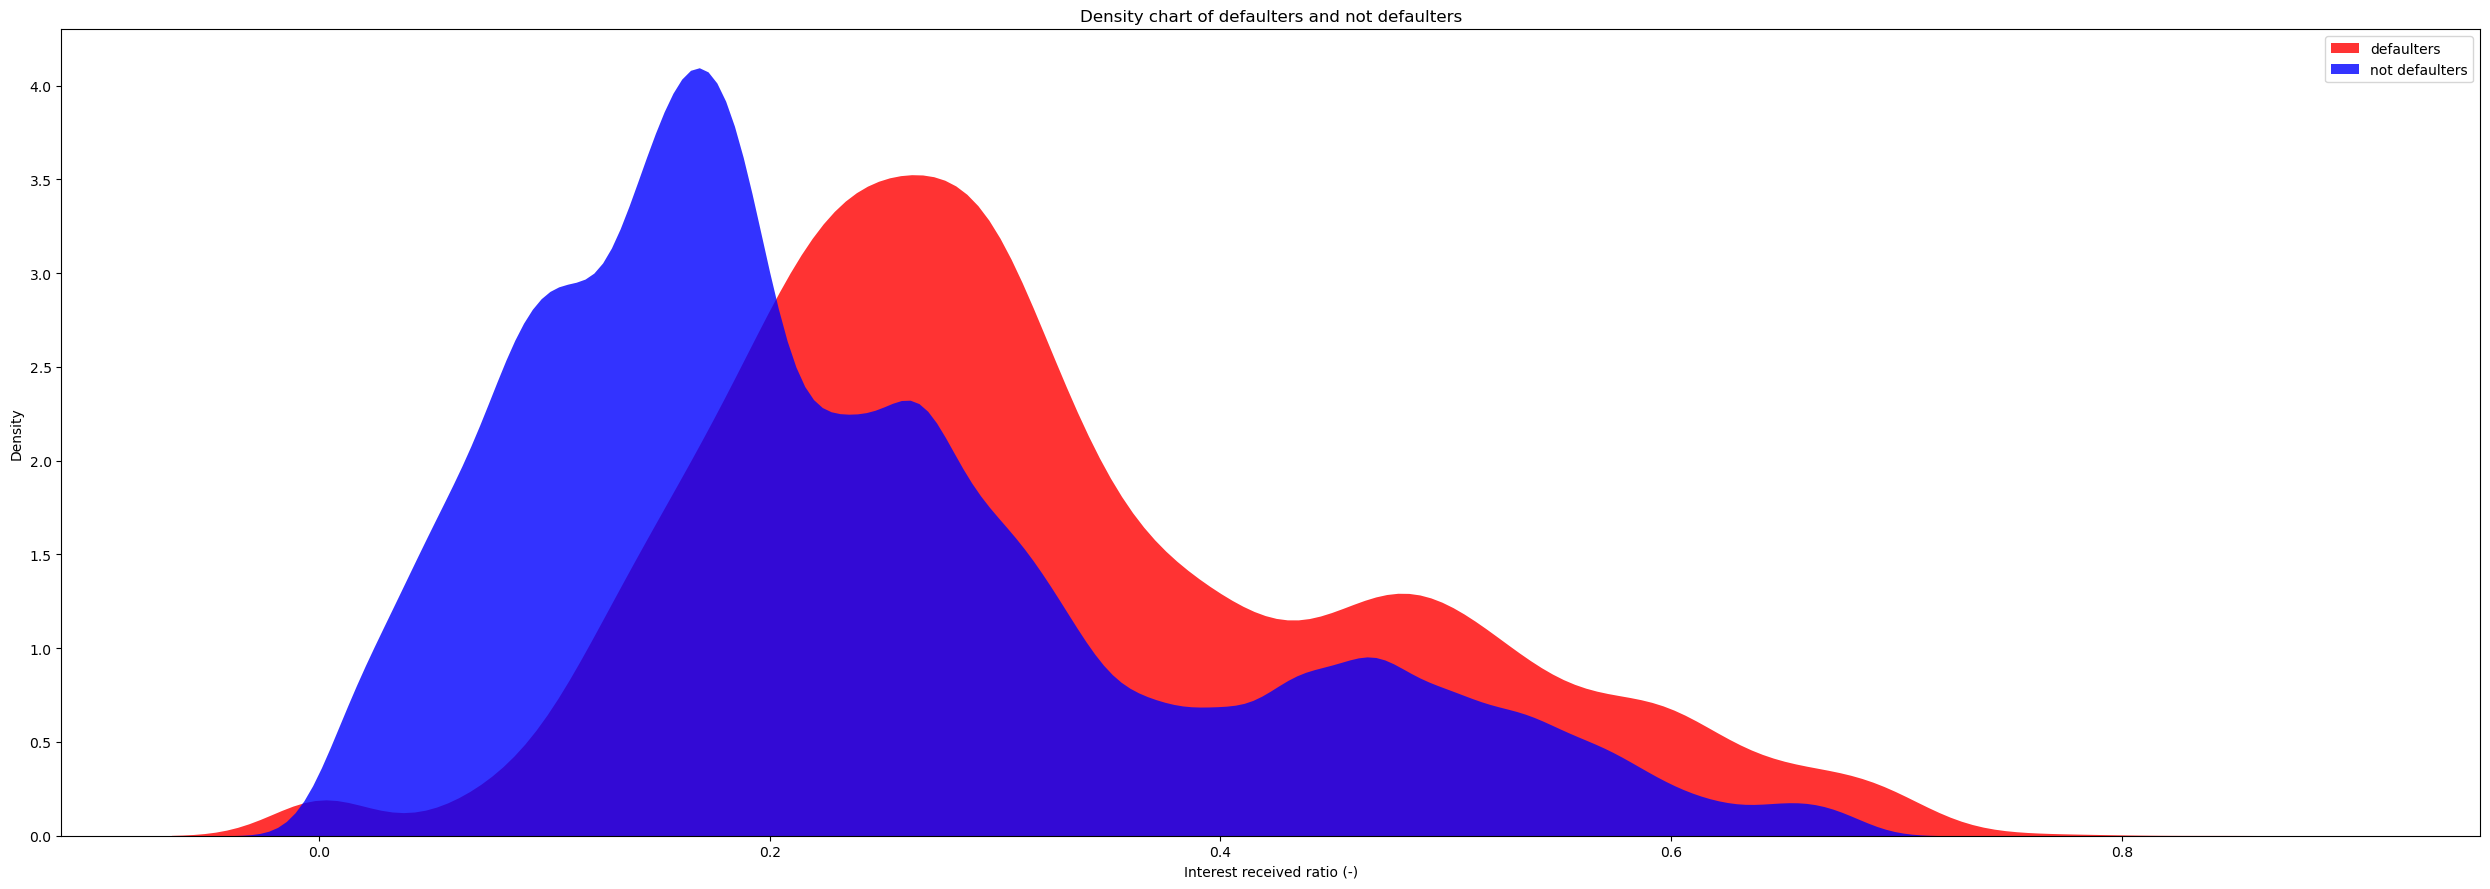

In [104]:
# Chart dimensions
fig, ax = plt.subplots(figsize = (25, 9))

# Data filtering
# aux3 = aux3[(aux3["interest_received_ratio"].notnull()) & (aux3["interest_received_ratio"] >= 0)
#            & (aux3["interest_received_ratio"] <= 250000)]

# Plot 
sns.kdeplot(data=aux3, x="interest_received_ratio", hue="category", hue_order=["not defaulters", "defaulters"],
            palette=["blue", "red"], fill=True, alpha=0.8, common_norm=False, linewidth=0)

# Titles
ax.set_title("Density chart of defaulters and not defaulters", fontsize=12)
ax.set_xlabel("Interest received ratio (-)", fontsize=10)
ax.set_ylabel("Density", fontsize=10)

# Adjustments
plt.legend(labels=["defaulters", "not defaulters"], loc="upper right")
plt.tight_layout()

# changing x-axis grading
min_value = int(min(aux3["interest_received_ratio"]))
max_value = int(max(aux3["interest_received_ratio"]))
# plt.xticks(range(min_value, max_value + 1, 1))
#plt.xticks(rotation=90)

# display chart
plt.show()

In [105]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.DataFrame(df3[(df3["target"] == 1)]["interest_received_ratio"]).describe().T

,count,mean,std,min,25%,50%,75%,max
interest_received_ratio,12065.00,0.32,0.14,0.00,0.22,0.29,0.41,0.84


- Range where we could find defaulters: higher than 0.2.
- Interest received median for defaulters: 0.29 USD.
- Interest received average for defaulters: 0.32 USD.

- People with interest received higher than 0.2 were more prone to be a defaulter.
- The higher the interest received: probability to be classified as a defaulter.
- This variable may be a good variable to give information to the model.

#### Total payement per loan

In [106]:
# not defaulters users
aux1 = df3[df3["target"] == 0][["user_id", "total_payement_per_loan"]]
aux1["category"] = "not defaulters"

# defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "total_payement_per_loan"]]
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


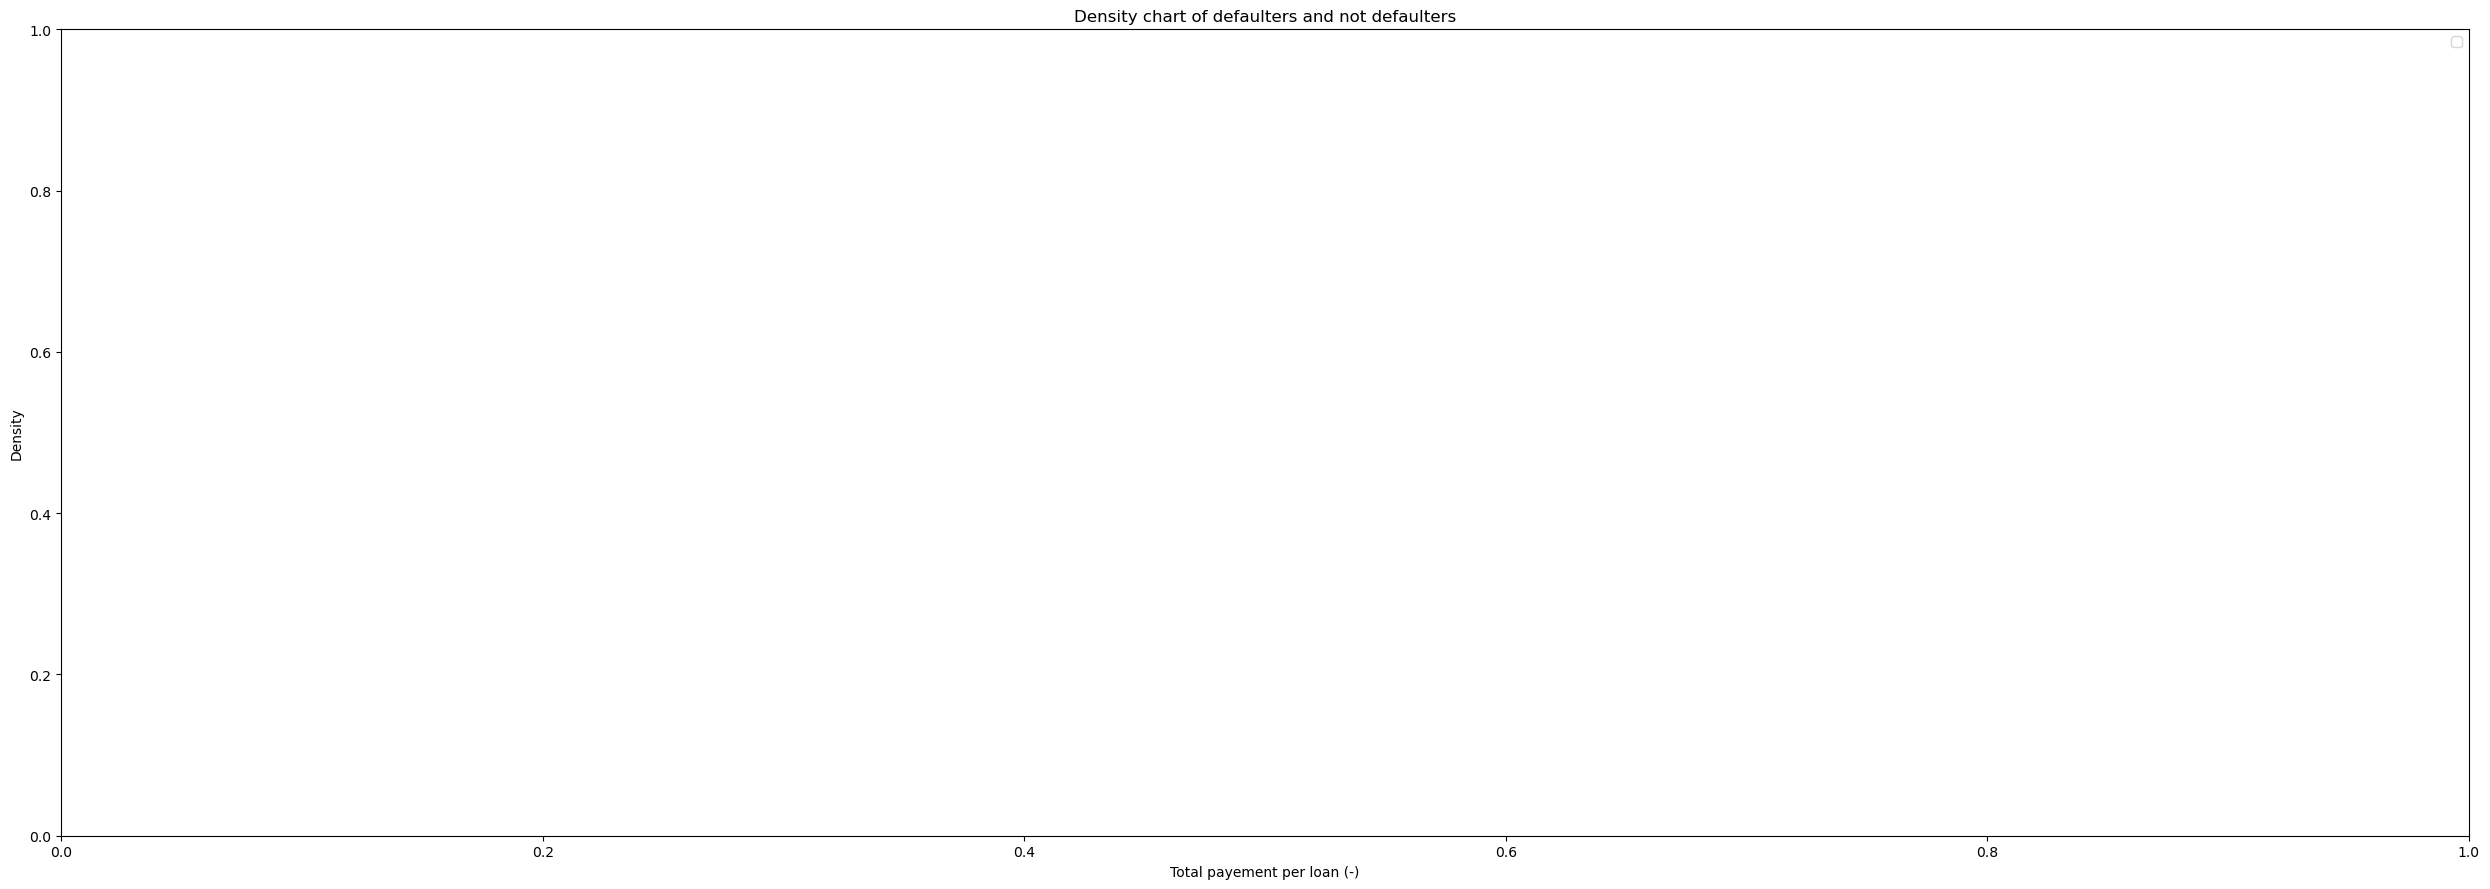

In [107]:
# Chart dimensions
fig, ax = plt.subplots(figsize = (25, 9))

# Data filtering
aux3 = aux3[(aux3["total_payement_per_loan"].notnull()) & (aux3["total_payement_per_loan"] >= 0)
           & (aux3["total_payement_per_loan"] <= 100)]

# Plot 
sns.kdeplot(data=aux3, x="total_payement_per_loan", hue="category", hue_order=["not defaulters", "defaulters"],
            palette=["blue", "red"], fill=True, alpha=0.8, common_norm=False, linewidth=0)

# Titles
ax.set_title("Density chart of defaulters and not defaulters", fontsize=12)
ax.set_xlabel("Total payement per loan (-)", fontsize=10)
ax.set_ylabel("Density", fontsize=10)

# Adjustments
plt.legend(labels=["defaulters", "not defaulters"], loc="upper right")
plt.tight_layout()

# changing x-axis grading
min_value = int(min(aux3["total_payement_per_loan"]))
max_value = int(max(aux3["total_payement_per_loan"]))
# plt.xticks(range(min_value, max_value + 1, 1))
#plt.xticks(rotation=90)

# display chart
plt.show()

- It is possible that this variable is not as informative as we want, since it has no variability.
- We will confirm that in the feature importance section.

### 3.3.3. Numerical Attributes (discrete)

In [108]:
num_attributes.apply(lambda x: x.unique().shape[0] )

total_income                11344
dependents                      5
delinq_2yrs                    22
total_payement             103619
received_principal          41878
interest_received           93402
number_of_loans                 5
emi_1_dpd                       4
emi_2_dpd                       4
emi_3_dpd                       4
emi_4_dpd                       4
emi_5_dpd                       4
emi_6_dpd                       4
max_dpd                         4
target                          2
interest_received_ratio    104890
total_payement_per_loan       561
delinq_2yrs_ratio              10
month_yearmo                    5
dtype: int64

#### Dependents

In [109]:
# number of users which are not defaulters
aux1 = df3[df3["target"] == 0][["user_id", "dependents"]].groupby("dependents").nunique().\
                                                 reset_index().sort_values("dependents", ascending=True).\
                                                 rename(columns={"user_id":"count"}) 
aux1["total"] = aux1["count"].sum()
aux1["percentage"] = aux1.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux1["category"] = "not defaulters"

# number of defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "dependents"]].groupby("dependents").\
                                    nunique().reset_index().sort_values("dependents", ascending=True).\
                                    rename(columns={"user_id":"count"})
aux2["total"] = aux2["count"].sum()
aux2["percentage"] = aux2.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

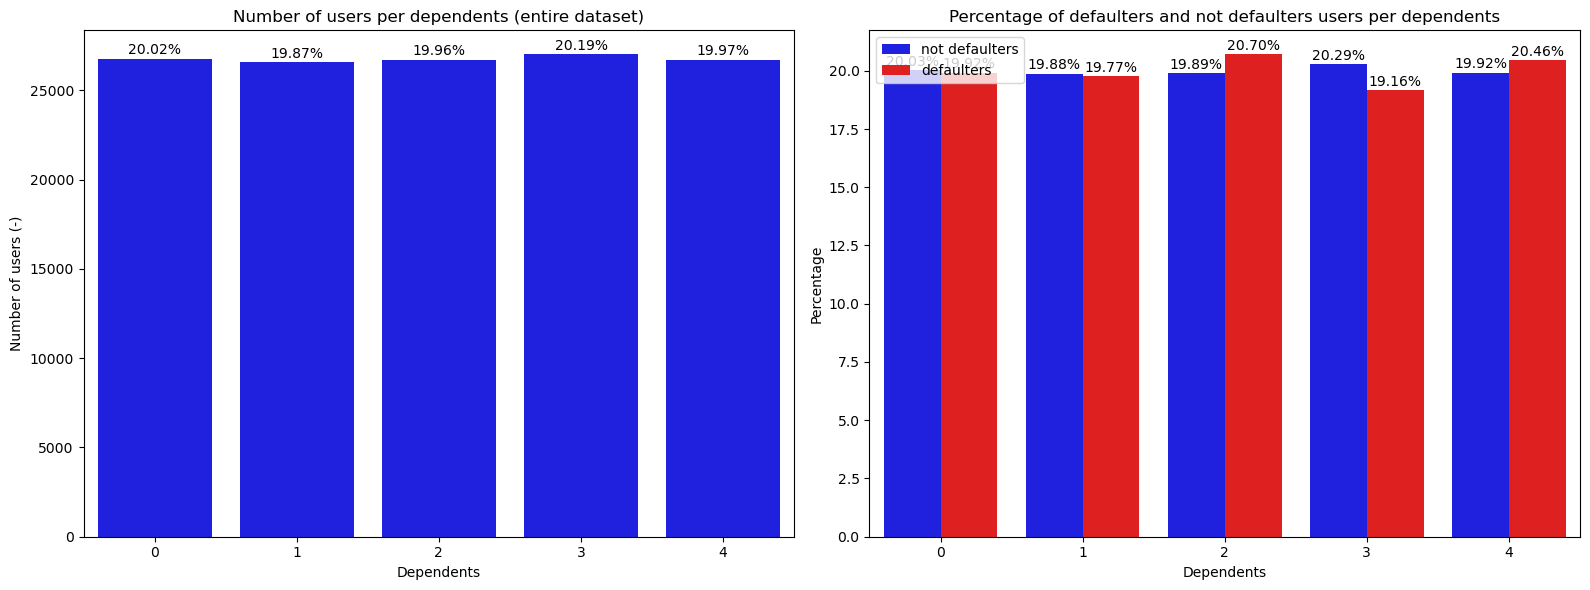

In [110]:
aux = df3.copy()

plt.figure(figsize=(16, 6))

plt.subplot(121)
ax1 = sns.countplot(x = 'dependents', data = aux, color="blue")
for p in ax1.patches:
        ax1.annotate(format(str((p.get_height()/len(aux)*100).round(2)) + '%'), 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')
ax1 = plt.title("Number of users per dependents (entire dataset)", fontsize=12)
ax1 = plt.xlabel("Dependents", fontsize=10)
ax1 = plt.ylabel("Number of users (-)", fontsize=10)
# ax1 = plt.xticks(rotation=30)

plt.subplot(122)
ax1 = sns.barplot(x="dependents", y="percentage", hue="category", data=aux3, 
                  hue_order=["not defaulters", "defaulters"], palette=["blue", "red"])

# bar labels 
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f') + '%', 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')

# titles
ax1 = plt.title("Percentage of defaulters and not defaulters users per dependents", fontsize=12)
ax1 = plt.xlabel("Dependents", fontsize=10)
ax1 = plt.ylabel("Percentage", fontsize=10)
# ax1 = plt.xticks(rotation=30)

# Adjustments
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

- 2 dependents were a class more prone to identify a defaulter.
- Maybe it is not an informative variable. After feature importance we may decide for sure.

#### Loan delinquecies in last 2 years

In [111]:
# number of users which are not defaulters
aux1 = df3[df3["target"] == 0][["user_id", "delinq_2yrs"]].groupby("delinq_2yrs").nunique().\
                                                 reset_index().sort_values("delinq_2yrs", ascending=True).\
                                                 rename(columns={"user_id":"count"}) 
aux1["total"] = aux1["count"].sum()
aux1["percentage"] = aux1.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux1["category"] = "not defaulters"

# number of defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "delinq_2yrs"]].groupby("delinq_2yrs").\
                                    nunique().reset_index().sort_values("delinq_2yrs", ascending=True).\
                                    rename(columns={"user_id":"count"})
aux2["total"] = aux2["count"].sum()
aux2["percentage"] = aux2.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

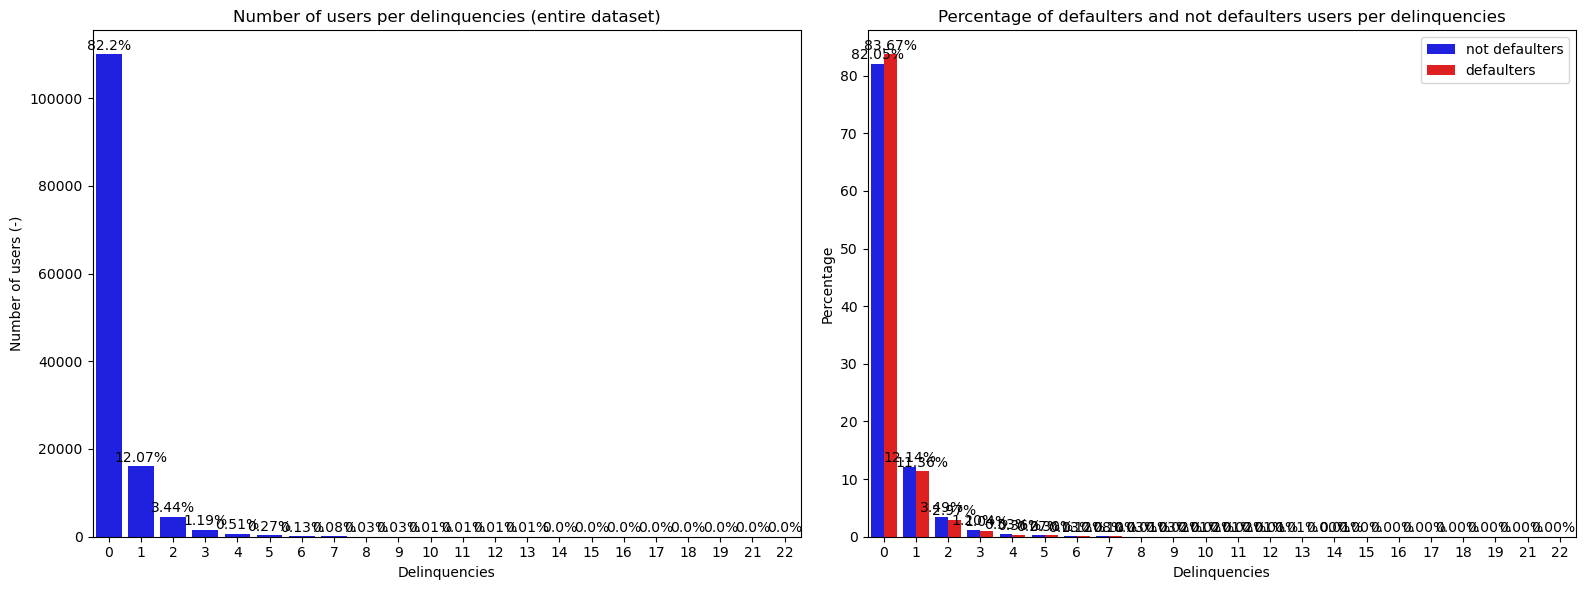

In [112]:
aux = df3.copy()

plt.figure(figsize=(16, 6))

plt.subplot(121)
ax1 = sns.countplot(x = 'delinq_2yrs', data = aux, color="blue")
for p in ax1.patches:
        ax1.annotate(format(str((p.get_height()/len(aux)*100).round(2)) + '%'), 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')
ax1 = plt.title("Number of users per delinquencies (entire dataset)", fontsize=12)
ax1 = plt.xlabel("Delinquencies", fontsize=10)
ax1 = plt.ylabel("Number of users (-)", fontsize=10)
# ax1 = plt.xticks(rotation=30)

plt.subplot(122)
ax1 = sns.barplot(x="delinq_2yrs", y="percentage", hue="category", data=aux3, 
                  hue_order=["not defaulters", "defaulters"], palette=["blue", "red"])

# bar labels 
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f') + '%', 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')

# titles
ax1 = plt.title("Percentage of defaulters and not defaulters users per delinquencies", fontsize=12)
ax1 = plt.xlabel("Delinquencies", fontsize=10)
ax1 = plt.ylabel("Percentage", fontsize=10)
# ax1 = plt.xticks(rotation=30)

# Adjustments
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

- 0 delinquencies were a class more prone to identify a defaulter.
- This may show that a defaulter rarely commits more than 1 delinquency in a period of 2 years.

- Maybe it is not an informative variable. After feature importance we may decide for sure.

#### Number of loans

In [113]:
# number of users which are not defaulters
aux1 = df3[df3["target"] == 0][["user_id", "number_of_loans"]].groupby("number_of_loans").nunique().\
                                                 reset_index().sort_values("number_of_loans", ascending=True).\
                                                 rename(columns={"user_id":"count"}) 
aux1["total"] = aux1["count"].sum()
aux1["percentage"] = aux1.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux1["category"] = "not defaulters"

# number of defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "number_of_loans"]].groupby("number_of_loans").\
                                    nunique().reset_index().sort_values("number_of_loans", ascending=True).\
                                    rename(columns={"user_id":"count"})
aux2["total"] = aux2["count"].sum()
aux2["percentage"] = aux2.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

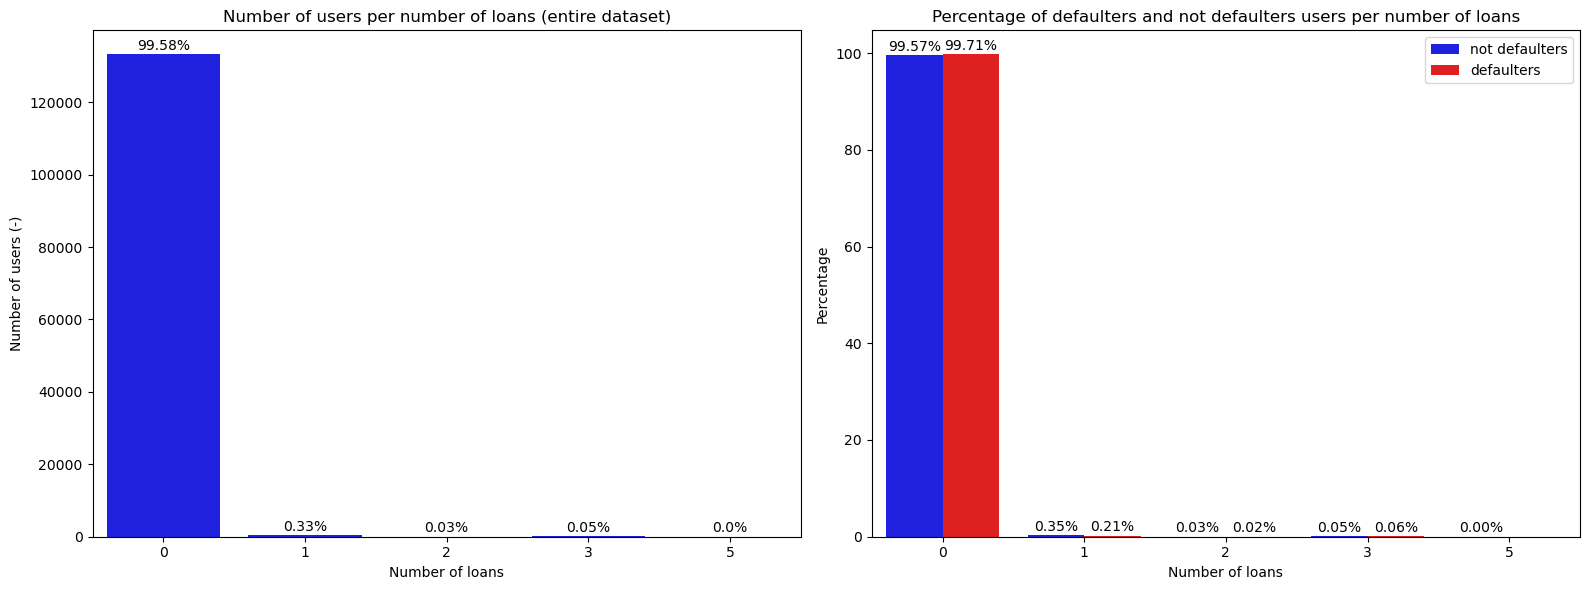

In [114]:
aux = df3.copy()

plt.figure(figsize=(16, 6))

plt.subplot(121)
ax1 = sns.countplot(x = 'number_of_loans', data = aux, color="blue")
for p in ax1.patches:
        ax1.annotate(format(str((p.get_height()/len(aux)*100).round(2)) + '%'), 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')
ax1 = plt.title("Number of users per number of loans (entire dataset)", fontsize=12)
ax1 = plt.xlabel("Number of loans", fontsize=10)
ax1 = plt.ylabel("Number of users (-)", fontsize=10)
# ax1 = plt.xticks(rotation=30)

plt.subplot(122)
ax1 = sns.barplot(x="number_of_loans", y="percentage", hue="category", data=aux3, 
                  hue_order=["not defaulters", "defaulters"], palette=["blue", "red"])

# bar labels 
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f') + '%', 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')

# titles
ax1 = plt.title("Percentage of defaulters and not defaulters users per number of loans", fontsize=12)
ax1 = plt.xlabel("Number of loans", fontsize=10)
ax1 = plt.ylabel("Percentage", fontsize=10)
# ax1 = plt.xticks(rotation=30)

# Adjustments
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

- This variable is not very informative.
- For the majority of users is the first time to make a loan. 

#### EMI 3

Since we have lots of EMIs and they are highly correlated (correlation matrix analysis), we are going to analyze only EMI 3, because it is our cutoff to define a defaulter.

In [115]:
# number of users which are not defaulters
aux1 = df3[df3["target"] == 0][["user_id", "emi_3_dpd"]].groupby("emi_3_dpd").nunique().\
                                                 reset_index().sort_values("emi_3_dpd", ascending=True).\
                                                 rename(columns={"user_id":"count"}) 
aux1["total"] = aux1["count"].sum()
aux1["percentage"] = aux1.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux1["category"] = "not defaulters"

# number of defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "emi_3_dpd"]].groupby("emi_3_dpd").\
                                    nunique().reset_index().sort_values("emi_3_dpd", ascending=True).\
                                    rename(columns={"user_id":"count"})
aux2["total"] = aux2["count"].sum()
aux2["percentage"] = aux2.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

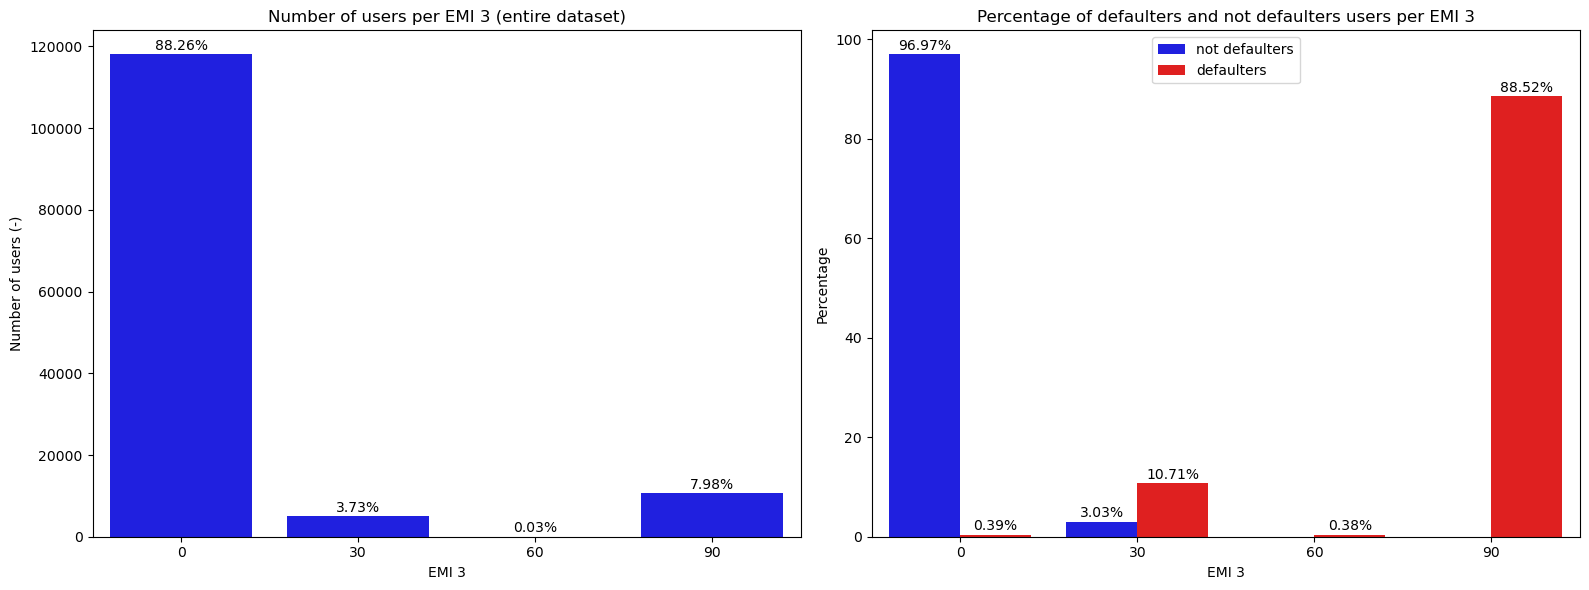

In [116]:
aux = df3.copy()

plt.figure(figsize=(16, 6))

plt.subplot(121)
ax1 = sns.countplot(x = 'emi_3_dpd', data = aux, color="blue")
for p in ax1.patches:
        ax1.annotate(format(str((p.get_height()/len(aux)*100).round(2)) + '%'), 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')
ax1 = plt.title("Number of users per EMI 3 (entire dataset)", fontsize=12)
ax1 = plt.xlabel("EMI 3", fontsize=10)
ax1 = plt.ylabel("Number of users (-)", fontsize=10)
# ax1 = plt.xticks(rotation=30)

plt.subplot(122)
ax1 = sns.barplot(x="emi_3_dpd", y="percentage", hue="category", data=aux3, 
                  hue_order=["not defaulters", "defaulters"], palette=["blue", "red"])

# bar labels 
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f') + '%', 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')

# titles
ax1 = plt.title("Percentage of defaulters and not defaulters users per EMI 3", fontsize=12)
ax1 = plt.xlabel("EMI 3", fontsize=10)
ax1 = plt.ylabel("Percentage", fontsize=10)
# ax1 = plt.xticks(rotation=30)

# Adjustments
plt.legend(loc="upper center")
plt.tight_layout()
plt.show()

- People who crossed 30 days past due (DPD) in the third intallment were more prone to be a defaulter.
- DPD 60 is another cutoff to define a defaulter. We may see after 60 days past due a high percentage of defaulters.

- This variable may be interesting to be used in the model. 
- We must decided it by using feature importance.

#### delinquencies in 2yrs ratio

This is the ratio of delinquencies per number of loans.

In [117]:
# number of users which are not defaulters
aux1 = df3[df3["target"] == 0][["user_id", "delinq_2yrs_ratio"]].groupby("delinq_2yrs_ratio").nunique().\
                                                 reset_index().sort_values("delinq_2yrs_ratio", ascending=True).\
                                                 rename(columns={"user_id":"count"}) 
aux1["total"] = aux1["count"].sum()
aux1["percentage"] = aux1.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux1["category"] = "not defaulters"

# number of defaulters
aux2 = df3[(df3["target"] == 1)][["user_id", "delinq_2yrs_ratio"]].groupby("delinq_2yrs_ratio").\
                                    nunique().reset_index().sort_values("delinq_2yrs_ratio", ascending=True).\
                                    rename(columns={"user_id":"count"})
aux2["total"] = aux2["count"].sum()
aux2["percentage"] = aux2.apply(lambda x: round(x["count"]*100/x["total"], 2), axis=1)
aux2["category"] = "defaulters"

# Concat
aux3 = pd.concat([aux1, aux2], axis=0)

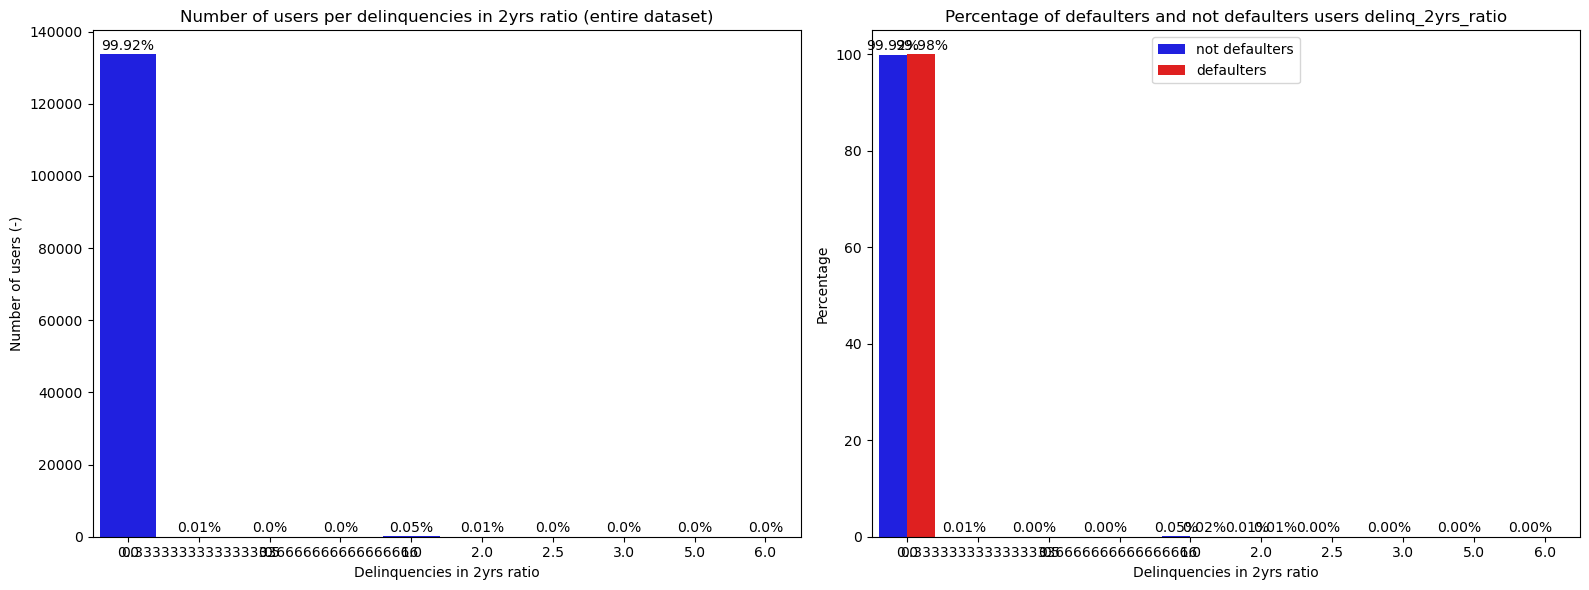

In [118]:
aux = df3.copy()

plt.figure(figsize=(16, 6))

plt.subplot(121)
ax1 = sns.countplot(x = 'delinq_2yrs_ratio', data = aux, color="blue")
for p in ax1.patches:
        ax1.annotate(format(str((p.get_height()/len(aux)*100).round(2)) + '%'), 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')
ax1 = plt.title("Number of users per delinquencies in 2yrs ratio (entire dataset)", fontsize=12)
ax1 = plt.xlabel("Delinquencies in 2yrs ratio", fontsize=10)
ax1 = plt.ylabel("Number of users (-)", fontsize=10)
# ax1 = plt.xticks(rotation=30)

plt.subplot(122)
ax1 = sns.barplot(x="delinq_2yrs_ratio", y="percentage", hue="category", data=aux3, 
                  hue_order=["not defaulters", "defaulters"], palette=["blue", "red"])

# bar labels 
for p in ax1.patches:
    ax1.annotate(format(p.get_height(), '.2f') + '%', 
                    (p.get_x() + p.get_width()/2, p.get_height()),
                    ha='center', 
                    va='center', 
                    xytext=(0,6),
                    textcoords='offset points')

# titles
ax1 = plt.title("Percentage of defaulters and not defaulters users delinq_2yrs_ratio", fontsize=12)
ax1 = plt.xlabel("Delinquencies in 2yrs ratio", fontsize=10)
ax1 = plt.ylabel("Percentage", fontsize=10)
# ax1 = plt.xticks(rotation=30)

# Adjustments
plt.legend(loc="upper center")
plt.tight_layout()
plt.show()

- It does not seem a good variable for the model, since it adds no information.
- We are going to confirm that in the feature importance section.

# 4. Balanced Dataset

In [119]:
df2.isna().sum()

user_id                    0
employment_type            0
tier_of_employment         0
industry                   0
role                       0
work_experience            0
total_income               0
gender                     0
married                    0
dependents                 0
home_type                  0
pincode                    0
has_social_profile         0
is_verified                0
delinq_2yrs                0
total_payement             0
received_principal         0
interest_received          0
number_of_loans            0
emi_1_dpd                  0
emi_2_dpd                  0
emi_3_dpd                  0
emi_4_dpd                  0
emi_5_dpd                  0
emi_6_dpd                  0
max_dpd                    0
yearmo                     0
target                     0
interest_received_ratio    0
total_payement_per_loan    0
delinq_2yrs_ratio          0
month_yearmo               0
dtype: int64

In [120]:
# removing data where variable target is null :: in this case we have no null values but it is commom in prod
df4 = df2.dropna(subset=["target"]).copy()

In [121]:
df4["target"].value_counts(normalize=True)

0   0.91
1   0.09
Name: target, dtype: float64

In [122]:
df4["target"].value_counts()

0    121687
1     12065
Name: target, dtype: int64

In [123]:
num_attributes = df4.select_dtypes(include=['int64']).columns.tolist()

for col in df4.columns:
    if col in num_attributes:
        df4[col] = df4[col].astype('int32')

In [124]:
num_attributes = df4.select_dtypes(include=['float64']).columns.tolist()

for col in df4.columns:
    if col in num_attributes:
        df4[col] = df4[col].astype('float32')

In [125]:
cat_attributes = df4.select_dtypes(include=['object']).columns.tolist()

for col in df4.columns:
    if col in cat_attributes:
        df4[col] = df4[col].astype('str')

In [126]:
del num_attributes
del cat_attributes

## 4.2. Data Balance: random oversampling

In [127]:
df4.apply(lambda x: x.unique())

user_id                    [72851048, 2425104, 2886381, 2598860, 57033271...
employment_type                             [Salaried, SI, Self - Employeed]
tier_of_employment                                 [E, SI, A, D, C, B, F, G]
industry                   [0, mLVIVxoGY7TUDJ1FyFoSIZi1SFcaBmO01AydRchaEi...
role                       [KHMbckjadbckIFGNYSEWdkcndwkcnCCM, KHMbckjadbc...
work_experience                   [0, 5-10, 0.0, <1, 1-2, 3-5, 10+, 2-3, SI]
total_income               [4000.0, 6695.0, 7000.0, 7800.0, 7956.0, 8000....
gender                                                 [Other, Female, Male]
married                                                        [SI, No, Yes]
dependents                                                   [1, 0, 3, 4, 2]
home_type                                 [rent, own, mortgage, none, other]
pincode                    [XX117X, XX30X, XX917X, XX325X, XX116X, XX185X...
has_social_profile                                             [SI, No, Yes]

In [128]:
df4.dtypes

user_id                             int32
employment_type                    object
tier_of_employment                 object
industry                           object
role                               object
work_experience                    object
total_income                      float32
gender                             object
married                            object
dependents                          int32
home_type                          object
pincode                            object
has_social_profile                 object
is_verified                        object
delinq_2yrs                         int32
total_payement                    float32
received_principal                float32
interest_received                 float32
number_of_loans                     int32
emi_1_dpd                           int32
emi_2_dpd                           int32
emi_3_dpd                           int32
emi_4_dpd                           int32
emi_5_dpd                         

In [129]:
df4.apply(lambda x: x.unique().shape[0])

user_id                    133752
employment_type                 3
tier_of_employment              8
industry                    12913
role                           46
work_experience                 9
total_income                11344
gender                          3
married                         3
dependents                      5
home_type                       5
pincode                       844
has_social_profile              3
is_verified                     4
delinq_2yrs                    22
total_payement             102216
received_principal          41878
interest_received           93402
number_of_loans                 5
emi_1_dpd                       4
emi_2_dpd                       4
emi_3_dpd                       4
emi_4_dpd                       4
emi_5_dpd                       4
emi_6_dpd                       4
max_dpd                         4
yearmo                          5
target                          2
interest_received_ratio    101609
total_payement

- Some variables has too many categories. We may delete them if the procedure does not work (based on business firstly).
- The higher number of categories for some column resulted in a high dimensionality.

In [130]:
df4 = df4.drop(columns={"industry", "pincode"})

In [131]:
df4["yearmo"] = df4["yearmo"].astype('str')

In [132]:
df4.dtypes

user_id                      int32
employment_type             object
tier_of_employment          object
role                        object
work_experience             object
total_income               float32
gender                      object
married                     object
dependents                   int32
home_type                   object
has_social_profile          object
is_verified                 object
delinq_2yrs                  int32
total_payement             float32
received_principal         float32
interest_received          float32
number_of_loans              int32
emi_1_dpd                    int32
emi_2_dpd                    int32
emi_3_dpd                    int32
emi_4_dpd                    int32
emi_5_dpd                    int32
emi_6_dpd                    int32
max_dpd                      int32
yearmo                      object
target                       int32
interest_received_ratio    float32
total_payement_per_loan    float32
delinq_2yrs_ratio   

In [133]:
# Encoder Categorical Variables
ohe = pp.OneHotEncoder()

# Numerical
num_attributes = df4.drop(columns=['target']).select_dtypes(include=['int32', 'float32']).columns.tolist()

# Categorical
cat_attributes = df4.select_dtypes(include=['object']).columns.tolist()

# encoding
df4_dummy = pd.DataFrame(ohe.fit_transform(df4[cat_attributes]).toarray(), index=df4.index)

# join numerical and categorical
data_prep = pd.concat([df4[num_attributes], df4_dummy], axis=1)
data_prep.shape

(133752, 108)

In [134]:
df4.columns = df4.columns.astype(str)

In [135]:
# define sampler
oversampling = oversamp.RandomOverSampler(sampling_strategy='all', random_state=32)

# apply sampler
X_over, y_over = oversampling.fit_resample(data_prep, df4['target'])

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.


In [136]:
df4["target"].value_counts()

0    121687
1     12065
Name: target, dtype: int64

In [137]:
y_over.value_counts()

0    121687
1    121687
Name: target, dtype: int64

In [138]:
# numerical data
df47 = X_over[num_attributes]

# categorical data
df48 = X_over.drop(num_attributes, axis=1)
df49 = pd.DataFrame(ohe.inverse_transform(df48), columns=cat_attributes, index=df48.index)
del df48

# join numerical categorical
df50 = pd.concat([df47, df49], axis=1)
del df47
del df49
df50['target'] = y_over

# copy dataset
del data_prep
data_prep = df50.copy()
del df50

In [139]:
data_prep.shape

(243374, 30)

# 5. Data Preparation

In [140]:
df5 = data_prep.copy()

There are 3 types of data preparation:

1. Normalization: the mean of the established data is 0 and the standard deviation is 1.

      - For data that follows the normal distribution before preparation.

2. Rescaling: (a) StandardScaler for data with a distribution similar to a normal distribution (symmetry), (b) MinMax Scaler for data without outliers (or with few outliers) and (c) RobustScaler for data with outliers.

      * For data that does not follow a normal distribution before preparation (skewness).

3. Transformation: (a) modification of categorical variations and (b) transformation of nature.

We see the distribution in the pandas profile report. But we can also confirm whether the distribution can be considered normal (mean close to the median; deviation very close to zero).

In [141]:
# to define data preparation method
# profile = ProfileReport(df5, title='Auto Report Pandas Profiling')
# profile.to_file(output_file='credit_risk.html')

## 5.1. Rescaling

This preparation is for numerical attributes. 

In [142]:
ssc = pp.StandardScaler()
rs = pp.RobustScaler()
mms = pp.MinMaxScaler()

In [143]:
df5.dtypes

user_id                      int32
total_income               float32
dependents                   int32
delinq_2yrs                  int32
total_payement             float32
received_principal         float32
interest_received          float32
number_of_loans              int32
emi_1_dpd                    int32
emi_2_dpd                    int32
emi_3_dpd                    int32
emi_4_dpd                    int32
emi_5_dpd                    int32
emi_6_dpd                    int32
max_dpd                      int32
interest_received_ratio    float32
total_payement_per_loan    float32
delinq_2yrs_ratio          float32
month_yearmo                 int32
employment_type             object
tier_of_employment          object
role                        object
work_experience             object
gender                      object
married                     object
home_type                   object
has_social_profile          object
is_verified                 object
yearmo              

In [144]:
# total_income - Robust Scaler 
df5['total_income'] = rs.fit_transform(df5[['total_income']].values)

# delinq_2yrs - MinMax Scaler
df5['delinq_2yrs'] = mms.fit_transform(df5[['delinq_2yrs']].values)

# total_payement - Robust Scaler
df5['total_payement'] = rs.fit_transform(df5[['total_payement']].values)

# received_principal - Robust Scaler
df5['received_principal'] = rs.fit_transform(df5[['received_principal']].values)

# interest_received - Robust Scaler
df5['interest_received'] = rs.fit_transform(df5[['interest_received']].values)

# interest_received_ratio - MinMax Scaler
df5['interest_received_ratio'] = mms.fit_transform(df5[['interest_received_ratio']].values)

# total_payement_per_loan - MinMax Scaler
df5['total_payement_per_loan'] = mms.fit_transform(df5[['total_payement_per_loan']].values)

# delinq_2yrs_ratio - MinMax Scaler
df5['delinq_2yrs_ratio'] = mms.fit_transform(df5[['delinq_2yrs_ratio']].values)

## 5.2. Categorical Encoding

- One Hot Encoder: variables without levels and with few classes.
- Target Encoder: variables without levels and with many classes.
- Label Encoding: variable with levels with a natural order.

In [145]:
df5.select_dtypes(include="object").nunique()

employment_type        3
tier_of_employment     8
role                  46
work_experience        9
gender                 3
married                3
home_type              5
has_social_profile     3
is_verified            4
yearmo                 5
dtype: int64

In [146]:
# employment_type - One Hot Encoder
df5 = pd.get_dummies(df5, prefix=['employment_type'], columns=['employment_type'])

# gender - One Hot Encoder
df5 = pd.get_dummies(df5, prefix=['gender'], columns=['gender'])

# married - One Hot Encoder
df5 = pd.get_dummies(df5, prefix=['married'], columns=['married'])

# home_type - One Hot Encoder
df5 = pd.get_dummies(df5, prefix=['home_type'], columns=['home_type'])

# is_verified - One Hot Encoder
df5 = pd.get_dummies(df5, prefix=['is_verified'], columns=['is_verified'])

In [147]:
te = TargetEncoder(cols=["role"])

# type for target
df5["target"] = df5["target"].astype("int32")

encoder = te.fit(df5[["role"]], df5['target'])
df5_prep = encoder.transform(df5[["role"]])
df5 = pd.concat([df5.drop(["role"], axis=1), df5_prep], axis=1)

In [148]:
# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# tier_of_employment
df5['tier_of_employment'] = label_encoder.fit_transform(df5['tier_of_employment'])

# work_experience
df5['work_experience'] = label_encoder.fit_transform(df5['work_experience'])

In [149]:
df5.head()

,user_id,total_income,dependents,delinq_2yrs,total_payement,received_principal,interest_received,number_of_loans,emi_1_dpd,emi_2_dpd,...,home_type_mortgage,home_type_none,home_type_other,home_type_own,home_type_rent,is_verified_Not Verified,is_verified_SI,is_verified_Source Verified,is_verified_Verified,role
0,72851048,-1.40,1,0.00,-0.70,-0.57,-0.59,0,0,0,...,0,0,0,0,1,1,0,0,0,0.53
1,2425104,-1.33,0,0.00,-0.62,-0.44,-0.68,0,0,0,...,0,0,0,1,0,0,0,0,1,0.40
2,2886381,-1.33,1,0.00,-0.37,-0.16,-0.52,0,0,0,...,0,0,0,0,1,1,0,0,0,0.52
3,2598860,-1.30,3,0.00,3.21,3.26,3.53,0,0,0,...,0,0,0,0,1,1,0,0,0,0.52
4,57033271,-1.30,1,0.00,-0.62,-0.49,-0.50,0,0,0,...,0,0,0,0,1,1,0,0,0,0.53


## 5.3. Cyclical Transformation

To variables with cyclical nature.

In [150]:
df5.dtypes

user_id                               int32
total_income                        float32
dependents                            int32
delinq_2yrs                         float64
total_payement                      float32
received_principal                  float32
interest_received                   float32
number_of_loans                       int32
emi_1_dpd                             int32
emi_2_dpd                             int32
emi_3_dpd                             int32
emi_4_dpd                             int32
emi_5_dpd                             int32
emi_6_dpd                             int32
max_dpd                               int32
interest_received_ratio             float32
total_payement_per_loan             float32
delinq_2yrs_ratio                   float32
month_yearmo                          int32
tier_of_employment                    int64
work_experience                       int64
has_social_profile                   object
yearmo                          

In [151]:
df5["yearmo"].head()

0    2022-05-01
1    2022-05-01
2    2022-05-01
3    2022-05-01
4    2022-05-01
Name: yearmo, dtype: object

In [152]:
df5["yearmo"] = pd.to_datetime(df5["yearmo"])

In [153]:
df5.dtypes

user_id                                      int32
total_income                               float32
dependents                                   int32
delinq_2yrs                                float64
total_payement                             float32
received_principal                         float32
interest_received                          float32
number_of_loans                              int32
emi_1_dpd                                    int32
emi_2_dpd                                    int32
emi_3_dpd                                    int32
emi_4_dpd                                    int32
emi_5_dpd                                    int32
emi_6_dpd                                    int32
max_dpd                                      int32
interest_received_ratio                    float32
total_payement_per_loan                    float32
delinq_2yrs_ratio                          float32
month_yearmo                                 int32
tier_of_employment             

In [154]:
df5["yearmo"].head()

0   2022-05-01
1   2022-05-01
2   2022-05-01
3   2022-05-01
4   2022-05-01
Name: yearmo, dtype: datetime64[ns]

In [155]:
# month_yearmo
df5['month_yearmo_sin'] = df5['month_yearmo'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_yearmo_cos'] = df5['month_yearmo'].apply(lambda x: np.cos(x*(2*np.pi/12)))

# 6. Feature Selection

The main reason we select variables is to follow the principle of Occam's Razor: we must choose the simplest explanation for our phenomenon. Effects of variable selection:

- Make the model easier to interpret.
- Reduce training time.
- Avoid the Curse of Dimensionality.
- Reduce overfitting.

**NOTE:** It is important to select variables with the same best-performing Machine Learning model.

In [156]:
df6 = df2.copy()

## 6.1. Feature Importance AutoML Preprocess

In [157]:
feature_importance = df6.copy()

In [158]:
feature_importance.isna().sum()

user_id                    0
employment_type            0
tier_of_employment         0
industry                   0
role                       0
work_experience            0
total_income               0
gender                     0
married                    0
dependents                 0
home_type                  0
pincode                    0
has_social_profile         0
is_verified                0
delinq_2yrs                0
total_payement             0
received_principal         0
interest_received          0
number_of_loans            0
emi_1_dpd                  0
emi_2_dpd                  0
emi_3_dpd                  0
emi_4_dpd                  0
emi_5_dpd                  0
emi_6_dpd                  0
max_dpd                    0
yearmo                     0
target                     0
interest_received_ratio    0
total_payement_per_loan    0
delinq_2yrs_ratio          0
month_yearmo               0
dtype: int64

In [159]:
# import pycaret classification and init setup
from pycaret.classification import *
feature_importance = setup(data=feature_importance.dropna(subset=["target"]), 
                           target='target', 
                           preprocess=True, 
                           fix_imbalance=True, 
                           session_id=123)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(133752, 32)"
4,Transformed data shape,"(210488, 64)"
5,Transformed train set shape,"(170362, 64)"
6,Transformed test set shape,"(40126, 64)"
7,Numeric features,19
8,Date features,1
9,Categorical features,11


In [160]:
feature_importance

In [161]:
feature_importance.dataset_transformed

,user_id,employment_type_SI,employment_type_Salaried,employment_type_Self - Employeed,tier_of_employment_SI,tier_of_employment_C,tier_of_employment_E,tier_of_employment_B,tier_of_employment_D,tier_of_employment_A,...,emi_6_dpd,max_dpd,yearmo_year,yearmo_month,yearmo_day,interest_received_ratio,total_payement_per_loan,delinq_2yrs_ratio,month_yearmo,target
82273,3326438.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,90.00,90.00,2022,2,1,0.23,0.00,0.00,2.00,1
36518,60762359.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,2022,4,1,0.28,0.00,0.00,4.00,0
3400,2633122.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,30.00,30.00,2022,5,1,0.16,0.00,0.00,5.00,0
133130,57485655.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,2022,1,1,0.29,0.00,0.00,1.00,0
15028,58467316.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,30.00,2022,5,1,0.18,0.00,0.00,5.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109540,3073262.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,2022,1,1,0.20,0.00,0.00,1.00,0
41323,3355407.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,90.00,90.00,2022,4,1,0.51,0.00,0.00,4.00,1
119266,4850806.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,2022,1,1,0.15,0.00,0.00,1.00,0
57056,2975026.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,0.00,0.00,2022,3,1,0.12,0.00,0.00,3.00,0


In [162]:
feature_importance.dataset_transformed["target"]

82273     1
36518     0
3400      0
133130    0
15028     0
         ..
109540    0
41323     1
119266    0
57056     0
26207     0
Name: target, Length: 210488, dtype: int8

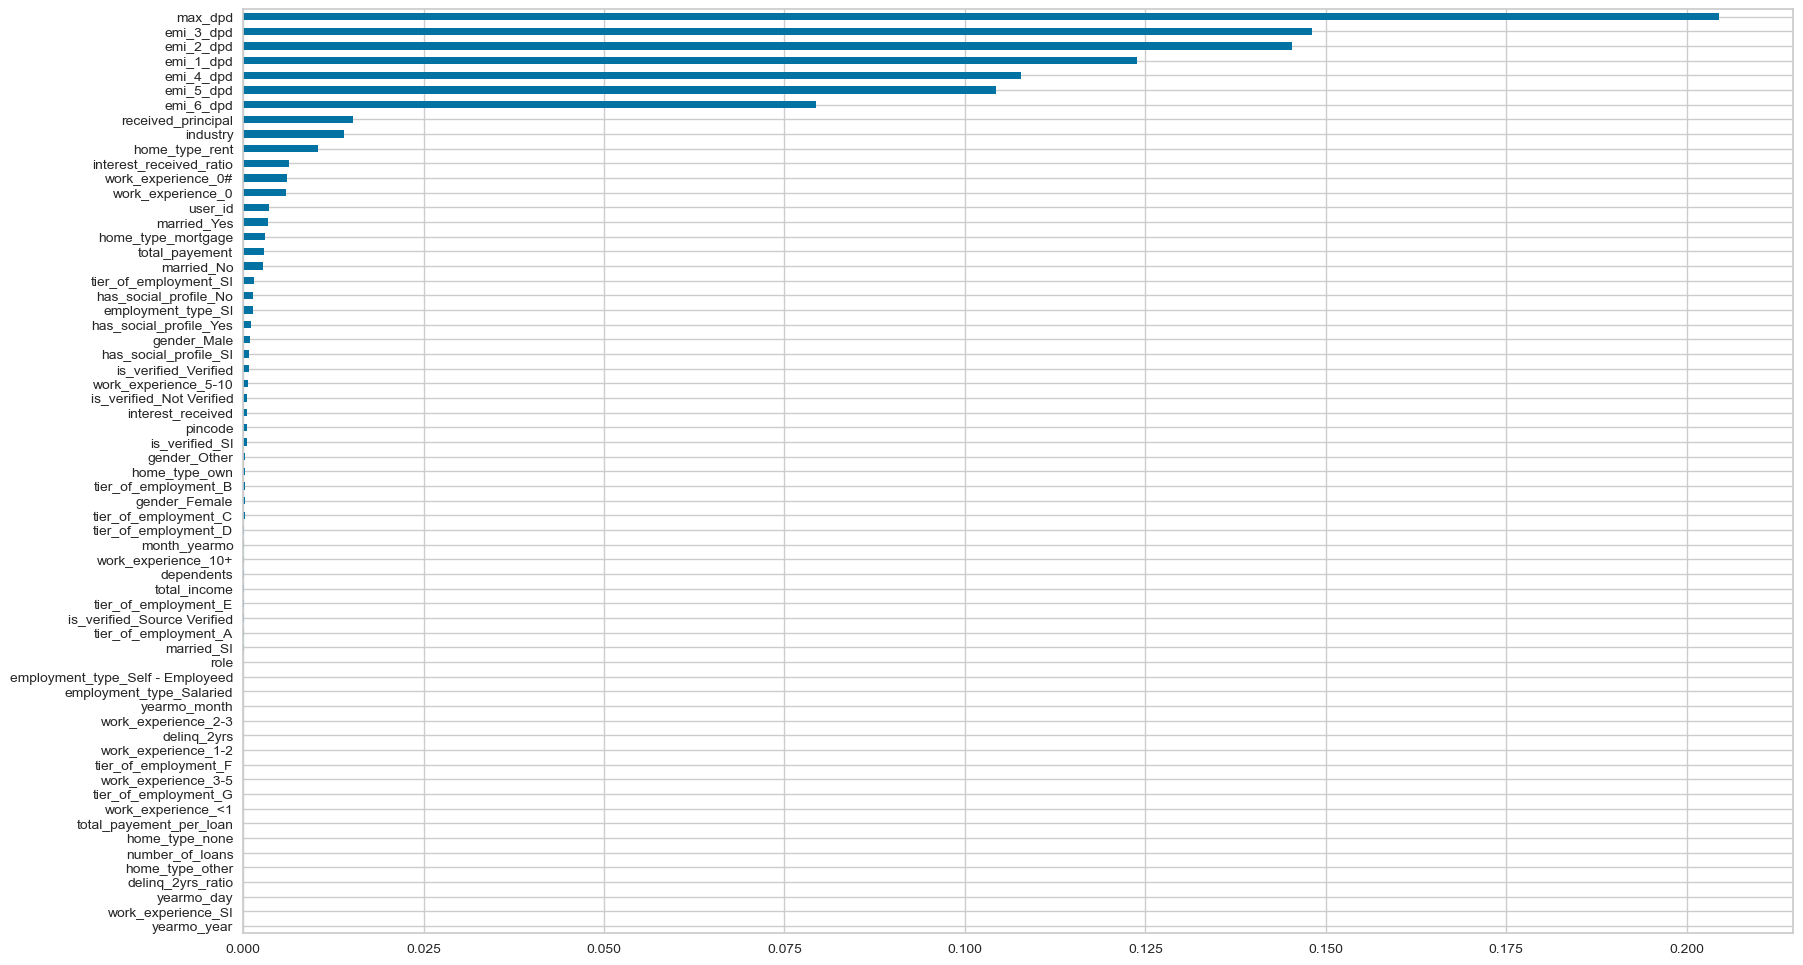

In [164]:
# instantiate model
rf = RandomForestClassifier()

# defining train datasets
x_train = feature_importance.dataset_transformed.drop(columns=["target", "user_id"])

y_train = feature_importance.dataset_transformed["target"].copy()

# checking feature importances
rf.fit(x_train, y_train)

# feature importance
feat_importances = pd.Series(rf.feature_importances_, index=x_train.columns)

# plot graph
fig = plt.figure(figsize=(20, 12))
feat_importances.sort_values().plot(kind='barh');

- max_dpd, received_principal, industry, home_type_rent, interest_received_ratio, work_experience_0#, work_experience_0, married_Yes, home_type_mortgage, total_payement, married_No.

## 6.2. Selection

In [174]:
df5["yearmo"].unique()

array(['2022-05-01T00:00:00.000000000', '2022-04-01T00:00:00.000000000',
       '2022-03-01T00:00:00.000000000', '2022-02-01T00:00:00.000000000',
       '2022-01-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [175]:
# cutoff for validation dataset
validation_date = pd.to_datetime('2022-05-01')

# Separando os conjuntos
train_test = df5[df5['yearmo'] != validation_date]
validation = df5[df5['yearmo'] == validation_date]

In [176]:
# first selection

train_test = train_test[["max_dpd", "received_principal", "home_type_rent", 
                         "interest_received_ratio", "work_experience", 
                         "married_Yes", "home_type_mortgage", "total_payement", "married_No", "target"]].copy()

validation = validation[["max_dpd", "received_principal", "home_type_rent", 
                         "interest_received_ratio", "work_experience", 
                         "married_Yes", "home_type_mortgage", "total_payement", "married_No", "target"]].copy()

# 7. Machine Learning

In [168]:
help(setup)

Help on function setup in module pycaret.classification.functional:

setup(data: Union[dict, list, tuple, numpy.ndarray, scipy.sparse._base.spmatrix, pandas.core.frame.DataFrame, NoneType] = None, data_func: Optional[Callable[[], Union[dict, list, tuple, numpy.ndarray, scipy.sparse._base.spmatrix, pandas.core.frame.DataFrame]]] = None, target: Union[int, str, list, tuple, numpy.ndarray, pandas.core.series.Series] = -1, index: Union[bool, int, str, list, tuple, numpy.ndarray, pandas.core.series.Series] = True, train_size: float = 0.7, test_data: Union[dict, list, tuple, numpy.ndarray, scipy.sparse._base.spmatrix, pandas.core.frame.DataFrame, NoneType] = None, ordinal_features: Optional[Dict[str, list]] = None, numeric_features: Optional[List[str]] = None, categorical_features: Optional[List[str]] = None, date_features: Optional[List[str]] = None, text_features: Optional[List[str]] = None, ignore_features: Optional[List[str]] = None, keep_features: Optional[List[str]] = None, preprocess:

**Missing values**

- numeric_imputation: default = mean. Média dos valores da coluna.
- categorical_imputation: default = mode. Valores mais frequentes da coluna.

**Outliers**

- remove_outliers: default = False.
- When set to True, outliers from the training data are removed using an Isolation Forest.

**Imbalance data**

- fix_imbalance: default = False. If True, then: default = "SMOTE".
- SMOTE (Synthetic Minority Over-sampling Technique) is applied by default to create synthetic datapoints for minority class.

**Preprocess**

- preprocess: default = True.
- Data must be ready for modeling (no missing values, no dates, categorical data encoding), when preprocess is set to False.

In [178]:
train_test.dtypes

max_dpd                      int32
received_principal         float32
home_type_rent               uint8
interest_received_ratio    float32
work_experience              int64
married_Yes                  uint8
home_type_mortgage           uint8
total_payement             float32
married_No                   uint8
target                       int32
dtype: object

In [177]:
# import pycaret classification and init setup
from pycaret.classification import *
df8_prep = setup(data=train_test, target='target', preprocess=False, fix_imbalance=False, session_id=123)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(194080, 10)"
4,Transformed data shape,"(194080, 10)"
5,Transformed train set shape,"(135856, 10)"
6,Transformed test set shape,"(58224, 10)"
7,Numeric features,9


## 7.1. Compare Models

1. **Accuracy:** Accuracy represents the overall accuracy of the predictions made by the model. It measures the percentage of correctly predicted instances (customers who signed or did not sign a contract) of the total predictions. However, accuracy alone may not be sufficient when dealing with imbalanced data sets, where the number of customers who signed a contract may be significantly different from those who did not. In this case, we use balanced accuracy.

    - Of the total predictions, how many were measured correctly? Accuracy.
    

2. **AUC (area under the ROC curve):** AUC is a widely used metric for evaluating binary classification models. It measures the model's ability to distinguish between positive (customers who signed a contract) and negative (customers who did not sign a contract) instances. The AUC value ranges from 0 to 1, with a higher value indicating better model performance in terms of separating the two classes.

    - Ability of the model to correctly distinguish classes: 0 or 1.
    

3. **Recall (sensitivity or true positive rate):** Recall measures the model's ability to correctly identify customers who signed a contract among all real customers who signed a contract. It is the ratio of true positives (correctly predicted positive instances) to the sum of true positives and false negatives. A larger recall means a lower chance of losing customers who are likely to sign a contract.

    - It is the model's ability to identify who will actually sign a contract (target 1).
    

4. **Accuracy:** Accuracy measures the proportion of correctly predicted positive instances (customers who signed a contract) out of all instances predicted as positive by the model. It is the ratio of true positives to the sum of true positives and false positives. Accuracy indicates how accurate the model is in predicting positive instances and avoiding false positives.

    - The percentage of true positives out of all positive predictions.
    

5. **F1 Score:** The F1 score is the harmonic mean of precision and recall. It provides a single metric that combines precision and recall into a single value. The F1 score is useful when you want to balance precision and recall as it accounts for false positives and false negatives. A higher F1 score indicates better overall model performance.

    - Weights precision and recall simultaneously to evaluate false positives and false negatives (what the model gets wrong).
    

6. **Kappa:** Cohen's Kappa is a statistic that measures the agreement between predicted classifications and true classifications, considering the possibility of agreement occurring by chance. Kappa is especially useful when dealing with imbalanced data sets and provides a more robust evaluation metric.

    - Checks whether the agreement between the predicted classifications and the true classifications occurs by chance.
    

7. **MCC (Matthews correlation coefficient):** MCC is a measure of the quality of binary (two-class) classifications. It takes into account true and false positives and negatives and produces a value between -1 and +1. A value of +1 represents a perfect prediction, 0 represents random predictions, and -1 indicates complete disagreement between predictions and observations.

    - Measure to evaluate disagreement between predictions and observations.
    

8. **TT(Sec) (Training time in seconds):** TT(Sec) represents the model training time in seconds. Indicates the time required to train the model on the training data. This metric helps to evaluate the computational efficiency of models, where shorter training time is generally desired.

    - The smaller the better.

In [179]:
# twelveth selection
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.9997,0.9999,1.0000,0.9994,0.9997,0.9994,0.9994,1.1580
knn,K Neighbors Classifier,0.9997,0.9997,1.0000,0.9994,0.9997,0.9994,0.9994,0.9680
dt,Decision Tree Classifier,0.9997,0.9997,1.0000,0.9994,0.9997,0.9994,0.9994,0.1040
svm,SVM - Linear Kernel,0.9997,0.0000,1.0000,0.9994,0.9997,0.9994,0.9994,0.1200
ridge,Ridge Classifier,0.9997,0.0000,1.0000,0.9994,0.9997,0.9994,0.9994,0.0780
rf,Random Forest Classifier,0.9997,0.9999,1.0000,0.9994,0.9997,0.9994,0.9994,1.3800
ada,Ada Boost Classifier,0.9997,0.9999,1.0000,0.9994,0.9997,0.9994,0.9994,0.7150
gbc,Gradient Boosting Classifier,0.9997,0.9998,1.0000,0.9994,0.9997,0.9994,0.9994,2.0210
lda,Linear Discriminant Analysis,0.9997,0.9997,1.0000,0.9994,0.9997,0.9994,0.9994,0.1010
et,Extra Trees Classifier,0.9997,0.9999,1.0000,0.9994,0.9997,0.9994,0.9994,1.1270


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

- The values for performance metrics are very high. That may suggests overfitting or a data leak to the model. We will evaluate them in the next sections.
- We did not set an optimum threshold since our dataset is balanced and since for a balanced dataset its optimum threshold is 0.5. 

In [180]:
type(best)

sklearn.linear_model._logistic.LogisticRegression

In [181]:
# Tune the best model 
tuned_model = tune_model(best)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9997,0.9998,1.0000,0.9994,0.9997,0.9994,0.9994
1,0.9997,0.9999,1.0000,0.9994,0.9997,0.9994,0.9994
2,0.9996,0.9997,1.0000,0.9993,0.9996,0.9993,0.9993
3,0.9999,1.0000,1.0000,0.9997,0.9999,0.9997,0.9997
4,0.9995,0.9997,1.0000,0.9990,0.9995,0.9990,0.9990
5,0.9996,0.9998,1.0000,0.9993,0.9996,0.9993,0.9993
6,0.9996,0.9998,1.0000,0.9993,0.9996,0.9993,0.9993
7,0.9998,0.9999,1.0000,0.9996,0.9998,0.9996,0.9996
8,0.9999,0.9999,1.0000,0.9999,0.9999,0.9999,0.9999


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


## 7.2. Analyze Model

### 7.2.1. Confusion Matrix

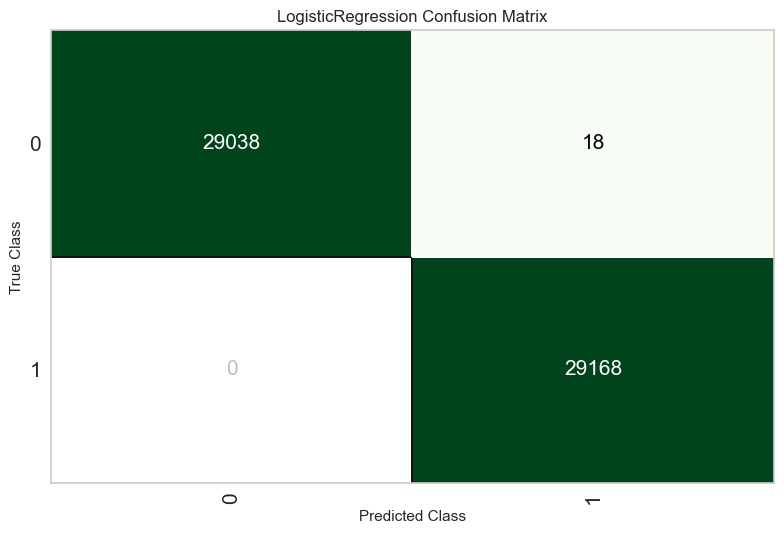

In [182]:
# plot confusion matrix
plot_model(best, plot = 'confusion_matrix')

- This is a perfect performance.
- Some predictions are wrong, thus precision for defaulters (1) is not perfect.
- But there was no mistake in the number of real defaulters (recall: 1).

### 7.2.2. AUC-ROC Curves

ROC Curves

- Used to evaluate overall forecast accuracy.
- Diagonal: indicates where an useless prediction would be.
- AUC values close to 0.50 mean that the model's prediction performance is the same as flipping a coin.
- Perfect predictions are on the left side of the diagonal: high values of true positives and low values of false positives.

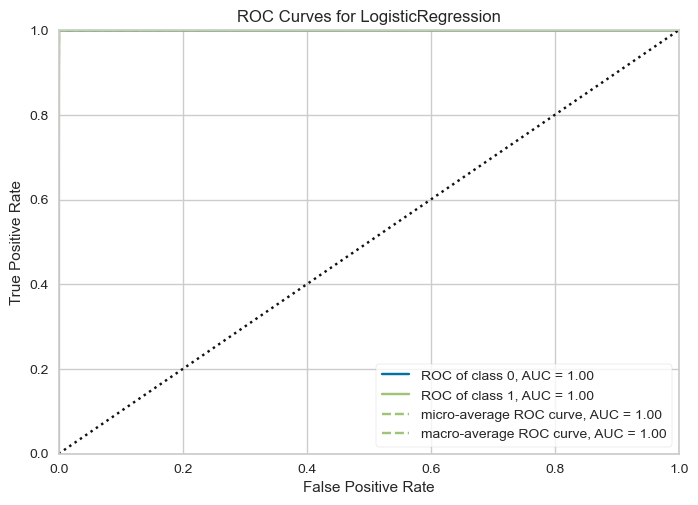

In [183]:
# plot AUC
plot_model(best, plot = 'auc')

- The most perfect scneario as possible: Roc curve in the far upper left. 
- We will evalute overfitting in the next sections.

### 7.2.3. Feature Importance

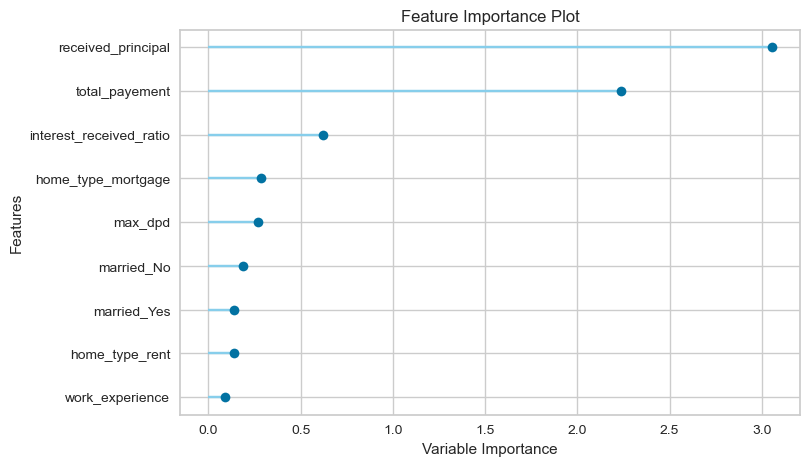

In [185]:
# plot feature importance
plot_model(best, plot = 'feature')

- Maybe 2 variables may make great predictions: received_principal and total_payement.
- These 2 variables more than 4 times higher than the others. 
- They are very informative to the model.

### 7.2.4. Error

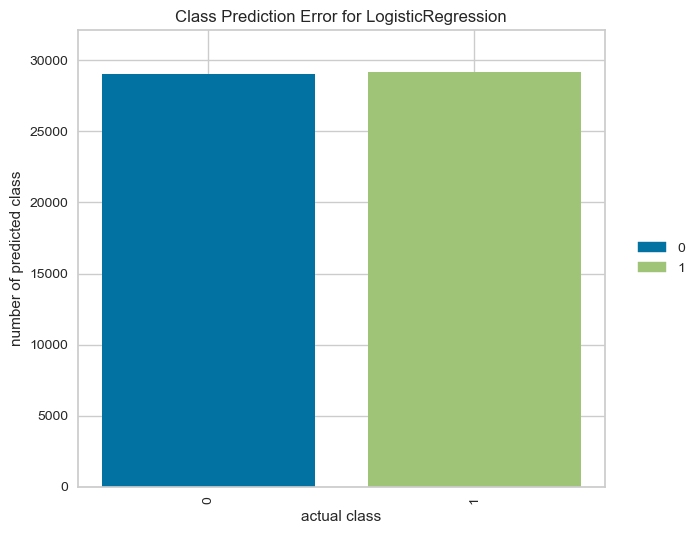

In [186]:
# error
plot_model(best, plot = 'error')

- Almost perfect. Almost no mistake. 

### 7.2.5. Hyperparameters

In [187]:
# Model hyperparameter
plot_model(best, plot = 'parameter')

,Parameters
C,1.0
class_weight,None
dual,False
fit_intercept,True
intercept_scaling,1
l1_ratio,None
max_iter,1000
multi_class,auto
n_jobs,None
penalty,l2


### 7.2.6. Learning Curve

To evaluate overfitting and underfitting in a classification problem, we can use several analysis techniques and methods. Here are some approaches we might consider:

1. Training/testing split: Split your dataset into training and testing subsets. Train your model on training data and evaluate its performance on separate test data. If the model performs significantly better on training data compared to testing data, it may be an indication of overfitting.

2. Cross-Validation: Perform cross-validation, such as k-fold cross-validation, to evaluate model performance on different subsets of data. If the model consistently performs well across different folds (subsets), this suggests a good fit. However, if there is a large variation in performance between folds, it may indicate overfitting or underfitting.

3. Learning curves: Plot learning curves that show model performance (e.g. accuracy, loss) on training and validation data as a function of training set size. If model performance on training data continues to improve while validation performance stabilizes or declines, this suggests overfitting. On the other hand, if training and validation performance remains low, this indicates underfitting.

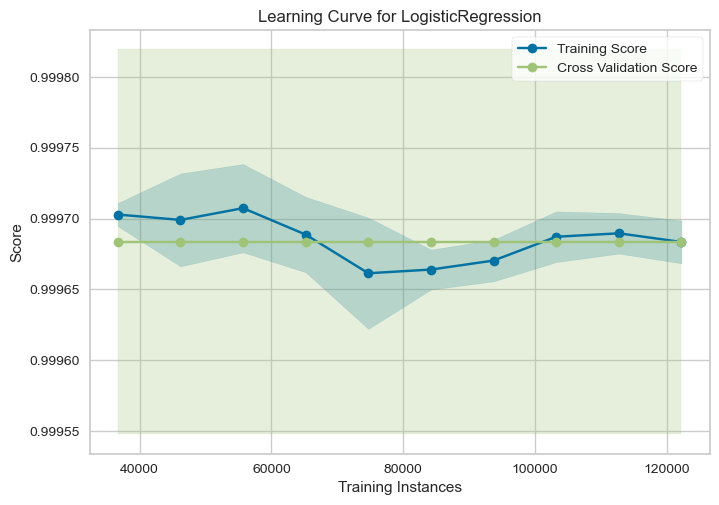

In [188]:
# Learning Curve
plot_model(best, plot = 'learning')

- Although there is variablity, the scale of it is decimal.
- The main idea: the scores are slightly different, but increasing training instance results in more close scores.
- That suggests that there is no overfitting.
- The excelent performance may happen due to the dataset is "artifical" - just for studies.

### 7.2.7. Classification Report

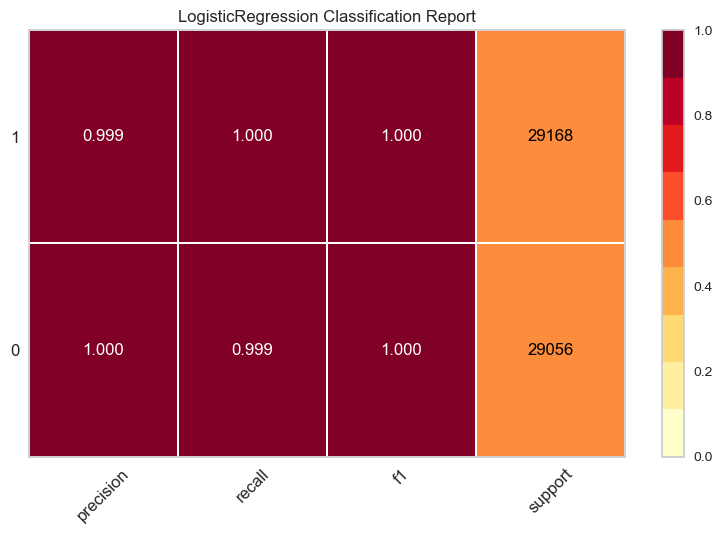

In [189]:
# Classification Report
plot_model(best, plot = 'class_report')

### 7.2.8. Docstring for Model Evaluation

In [190]:
# check docstring to see available plots
help(plot_model)

Help on function plot_model in module pycaret.classification.functional:

plot_model(estimator, plot: str = 'auc', scale: float = 1, save: bool = False, fold: Union[int, Any, NoneType] = None, fit_kwargs: Optional[dict] = None, plot_kwargs: Optional[dict] = None, groups: Union[str, Any, NoneType] = None, verbose: bool = True, display_format: Optional[str] = None) -> Optional[str]
    This function analyzes the performance of a trained model on holdout set.
    It may require re-training the model in certain cases.
    
    Example
    -------
    >>> from pycaret.datasets import get_data
    >>> juice = get_data('juice')
    >>> from pycaret.classification import *
    >>> exp_name = setup(data = juice,  target = 'Purchase')
    >>> lr = create_model('lr')
    >>> plot_model(lr, plot = 'auc')
    
    
    estimator: scikit-learn compatible object
        Trained model object
    
    
    plot: str, default = 'auc'
        List of available plots (ID - Name):
    
        * 'pipeline'

## 7.3. Prediction

The test set used is by default created during model setup. The default setting is 70% of the data for training and 30% for the test set.

- prediction_label: target variable prediction.
- prediction_score: probability of occurrence of the predicted class.

In [191]:
# predict on test set
houldout_pred = predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9997,0.9999,1.0000,0.9994,0.9997,0.9994,0.9994


- The performance metrics values from test matches the training's. 
- That suggest suitability. 
- There is no overfitting.

## 7.4. Save Model

In [193]:
# save pipeline
save_model(best, 'credit_risk')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/joblib),
          steps=[('placeholder', None),
                 ('trained_model',
                  LogisticRegression(C=1.0, class_weight=None, dual=False,
                                     fit_intercept=True, intercept_scaling=1,
                                     l1_ratio=None, max_iter=1000,
                                     multi_class='auto', n_jobs=None,
                                     penalty='l2', random_state=123,
                                     solver='lbfgs', tol=0.0001, verbose=0,
                                     warm_start=False))],
          verbose=False),
 'credit_risk.pkl')

In [194]:
# load pipeline
loaded_best_pipeline = load_model('credit_risk')
loaded_best_pipeline

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=/var/folders/p8/gqg5wqj951j06qtpr3cpkmrr0000gr/T/joblib),
         steps=[('placeholder', None),
                ('trained_model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=123,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

# 8. Validation

In [195]:
# predict model on new_data
predictions = predict_model(best, data=validation)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9997,0.9999,1.0000,0.9995,0.9997,0.9995,0.9995


In [196]:
predictions.head()

,max_dpd,received_principal,home_type_rent,interest_received_ratio,work_experience,married_Yes,home_type_mortgage,total_payement,married_No,target,prediction_label,prediction_score
0,0,-0.57,1,0.45,0,0,0,-0.70,0,0,0,1.00
1,30,-0.44,0,0.10,0,0,0,-0.62,1,0,0,0.99
2,30,-0.16,1,0.15,0,1,0,-0.37,0,0,0,0.99
3,0,3.26,1,0.32,0,1,0,3.21,0,0,0,1.00
4,0,-0.49,1,0.40,0,0,0,-0.62,0,0,0,1.00


In [198]:
predictions = predictions[["target", "prediction_label", "prediction_score"]].copy()

In [199]:
predictions.isna().sum()

target              0
prediction_label    0
prediction_score    0
dtype: int64

In [200]:
predictions["target"].value_counts(normalize=True)

0   0.50
1   0.50
Name: target, dtype: float64

Accuracy: 1.0
Balanced Accuracy: 1.0
Kappa Score: 1.0
AUC Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24835
           1       1.00      1.00      1.00     24459

    accuracy                           1.00     49294
   macro avg       1.00      1.00      1.00     49294
weighted avg       1.00      1.00      1.00     49294



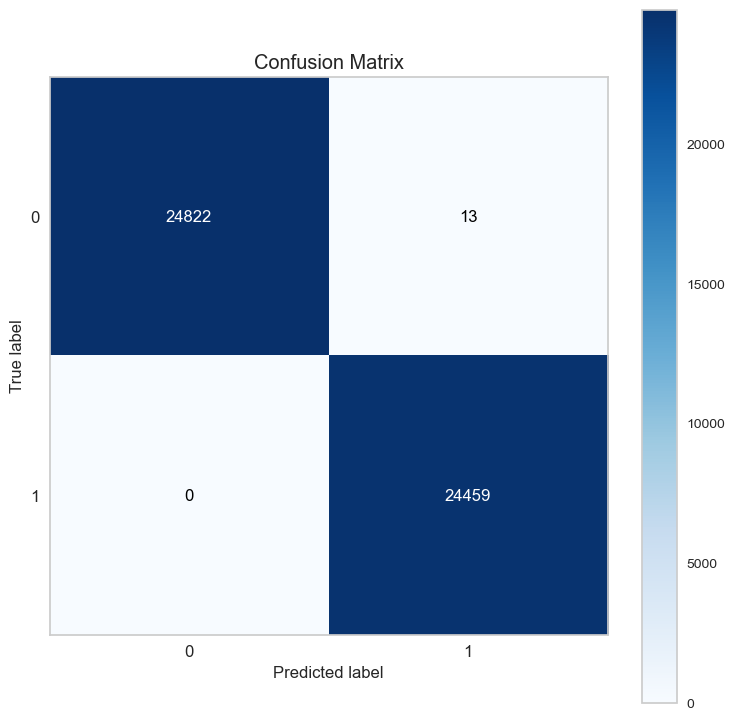

In [201]:
# Accuracy
acc = m.accuracy_score( predictions["target"], predictions["prediction_label"] )
print( 'Accuracy: {}'.format( np.round(acc, 2) ) )

# Balanced Accuracy
acc = m.balanced_accuracy_score( predictions["target"], predictions["prediction_label"] )
print( 'Balanced Accuracy: {}'.format( np.round(acc, 2) ) )

# Kappa Metrics
kappa = cohen_kappa_score( predictions["target"], predictions["prediction_label"] )
print( 'Kappa Score: {}'.format( np.round(kappa, 2 ) ) )

# AUC Metrics
auc = roc_auc_score(predictions["target"], predictions["prediction_label"])
print( 'AUC Score: {}'.format( np.round(auc, 2 ) ) )

# Classification report
print( classification_report( predictions["target"], predictions["prediction_label"] ) )

# Confusion Matrix
mt.plot_confusion_matrix(predictions["target"], predictions["prediction_label"], normalize=False, figsize=(9,9));

- Perfection in the validation.
- It seems a model is a perfect predictor of defaulters.
- However, we must consider that:
        1. It is an artifical dataset.
        2. We have data from almost same period of time: 2022 between Janurary and May.
        3. The dataset showed little variability, but in real world it it much more difficult to make this prediction.